# Character-Level GPT and Sparse Autoencoder Training

# Imports

In [ ]:
from google.colab import drive
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataclasses import dataclass
import math
from typing import Optional, Tuple, List
import time
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re

In [ ]:
!pip install -q datasets tiktoken wandb

## 1. Setup & Google Drive Mount

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create save directory
import os
SAVE_DIR = '/content/drive/MyDrive/char_gpt_sae'
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f'{SAVE_DIR}/checkpoints', exist_ok=True)
os.makedirs(f'{SAVE_DIR}/sae_checkpoints', exist_ok=True)
print(f'Models will be saved to: {SAVE_DIR}')

Mounted at /content/drive
Models will be saved to: /content/drive/MyDrive/char_gpt_sae


In [ ]:
# Install dependencies
!pip install -q datasets tiktoken wandb

# Check GPU
import torch
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Memory: 15.8 GB


## 2. Dataset: Tiny Stories



In [ ]:
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm

# Configuration for data
TARGET_CHARS = 100_000_000  # Adjust target characters for TinyStories (~10M)
VAL_SPLIT = 0.01  # 1% for validation

print("Loading TinyStories dataset as OpenWebText is unsupported...")

# Load TinyStories dataset in streaming mode
dataset = load_dataset('roneneldan/TinyStories', split='train', streaming=True)

# Collect text until we hit target size
texts = []
total_chars = 0

print(f"Collecting ~{TARGET_CHARS/1e6:.0f}M characters...")
pbar = tqdm(total=TARGET_CHARS, unit='chars', unit_scale=True)

for example in dataset:
    text = example['text']
    texts.append(text)
    total_chars += len(text)
    pbar.update(len(text))

    if total_chars >= TARGET_CHARS:
        break

pbar.close()
print(f"\nCollected {len(texts):,} documents, {total_chars:,} characters")

Loading TinyStories dataset as OpenWebText is unsupported...


README.md: 0.00B [00:00, ?B/s]

  0%|          | 0.00/100M [00:00<?, ?chars/s]


Collected 112,512 documents, 100,000,334 characters


In [ ]:
tokens_per_step = 32 * 512 * 4
max_steps = total_chars // tokens_per_step
print(f"Max steps: {max_steps:,}")
# Convert to bytes and create train/val split
print("Processing text to bytes...")

# Join all text with document separator
full_text = '\n\n'.join(texts)
data = full_text.encode('utf-8')

print(f"Total size: {len(data) / 1e6:.1f} MB")

# Split
split_idx = int(len(data) * (1 - VAL_SPLIT))
train_data = data[:split_idx]
val_data = data[split_idx:]

print(f"Train: {len(train_data) / 1e6:.1f} MB ({len(train_data):,} bytes)")
print(f"Val: {len(val_data) / 1e6:.1f} MB ({len(val_data):,} bytes)")

# Save processed data to drive for future use
data_path = f'{SAVE_DIR}/TinyStories.bin'
if not os.path.exists(data_path):
    print(f"\nSaving processed data to {data_path}...")
    with open(data_path, 'wb') as f:
        f.write(data)
    print("Saved!")
else:
    print(f"\nProcessed data already exists at {data_path}")

Max steps: 1,525
Processing text to bytes...
Total size: 100.4 MB
Train: 99.4 MB (99,364,477 bytes)
Val: 1.0 MB (1,003,682 bytes)

Processed data already exists at /content/drive/MyDrive/char_gpt_sae/TinyStories.bin


In [ ]:
# Preview some data
print("Sample from training data:")
print("=" * 60)
print(train_data[:1000].decode('utf-8', errors='replace'))
print("=" * 60)

Sample from training data:
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.

Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many

## 3. Model Definition: Character-Level GPT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import math
from typing import Optional, Tuple, List
import time


@dataclass
class GPTConfig:
    """Configuration for character-level GPT."""
    vocab_size: int = 256          # Raw bytes (0-255)
    context_length: int = 512      # Sequence length
    d_model: int = 512             # Embedding dimension
    n_heads: int = 8               # Number of attention heads
    n_layers: int = 8              # Number of transformer blocks
    d_ff: int = 2048               # Feedforward hidden dimension
    dropout: float = 0.1           # Dropout rate
    bias: bool = False             # Use bias in linear layers

    def estimate_params(self):
        """Estimate parameter count."""
        embed = self.vocab_size * self.d_model
        pos = self.context_length * self.d_model
        attn_per_layer = 4 * self.d_model ** 2
        mlp_per_layer = 2 * self.d_model * self.d_ff
        layers = self.n_layers * (attn_per_layer + mlp_per_layer)
        output = self.d_model * self.vocab_size
        return embed + pos + layers + output


class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight


class RotaryPositionalEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)."""
    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self._build_cache(max_seq_len)

    def _build_cache(self, seq_len: int):
        t = torch.arange(seq_len, device=self.inv_freq.device)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos())
        self.register_buffer("sin_cached", emb.sin())

    def forward(self, x: torch.Tensor, seq_len: int):
        if seq_len > self.max_seq_len:
            self._build_cache(seq_len)
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]


def rotate_half(x: torch.Tensor) -> torch.Tensor:
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention with RoPE."""

    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.d_model % config.n_heads == 0

        self.n_heads = config.n_heads
        self.head_dim = config.d_model // config.n_heads

        self.qkv_proj = nn.Linear(config.d_model, 3 * config.d_model, bias=config.bias)
        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=config.bias)

        self.dropout = nn.Dropout(config.dropout)
        self.rope = RotaryPositionalEmbedding(self.head_dim, config.context_length)

        self.register_buffer(
            "causal_mask",
            torch.triu(torch.ones(config.context_length, config.context_length), diagonal=1).bool()
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, T, C = x.shape

        qkv = self.qkv_proj(x)
        q, k, v = qkv.split(C, dim=-1)

        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        cos, sin = self.rope(x, T)
        cos = cos.unsqueeze(0).unsqueeze(0)
        sin = sin.unsqueeze(0).unsqueeze(0)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        scale = 1.0 / math.sqrt(self.head_dim)
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn_weights = attn_weights.masked_fill(
            self.causal_mask[:T, :T].unsqueeze(0).unsqueeze(0),
            float('-inf')
        )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.out_proj(out)

        return out, attn_weights


class MLP(nn.Module):
    """Feed-forward network with SwiGLU activation."""

    def __init__(self, config: GPTConfig):
        super().__init__()
        hidden_dim = int(2 * config.d_ff / 3)
        hidden_dim = 64 * ((hidden_dim + 63) // 64)  # Round to multiple of 64

        self.gate_proj = nn.Linear(config.d_model, hidden_dim, bias=config.bias)
        self.up_proj = nn.Linear(config.d_model, hidden_dim, bias=config.bias)
        self.down_proj = nn.Linear(hidden_dim, config.d_model, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate = F.silu(self.gate_proj(x))
        up = self.up_proj(x)
        x = gate * up
        x = self.down_proj(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    """Single transformer block with pre-norm architecture."""

    def __init__(self, config: GPTConfig, layer_idx: int):
        super().__init__()
        self.layer_idx = layer_idx
        self.norm1 = RMSNorm(config.d_model)
        self.attn = CausalSelfAttention(config)
        self.norm2 = RMSNorm(config.d_model)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor, return_residuals: bool = False):
        residuals = {} if return_residuals else None

        if return_residuals:
            residuals['pre_attn'] = x.detach()

        attn_out, attn_weights = self.attn(self.norm1(x))
        x = x + attn_out

        if return_residuals:
            residuals['mid'] = x.detach()
            residuals['attn_weights'] = attn_weights.detach()

        mlp_out = self.mlp(self.norm2(x))
        x = x + mlp_out

        if return_residuals:
            residuals['post_mlp'] = x.detach()

        return x, residuals


class CharGPT(nn.Module):
    """Character-level GPT model."""

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.dropout = nn.Dropout(config.dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(config, layer_idx=i)
            for i in range(config.n_layers)
        ])

        self.norm_f = RMSNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Weight tying
        self.tok_emb.weight = self.lm_head.weight

        self.apply(self._init_weights)

        # Special scaled init for output projections
        for block in self.blocks:
            nn.init.normal_(block.attn.out_proj.weight, std=0.02 / math.sqrt(2 * config.n_layers))
            nn.init.normal_(block.mlp.down_proj.weight, std=0.02 / math.sqrt(2 * config.n_layers))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None,
                return_residuals: bool = False, layers_to_capture: Optional[List[int]] = None):
        B, T = idx.shape
        assert T <= self.config.context_length

        x = self.tok_emb(idx)
        x = self.dropout(x)

        all_residuals = {} if return_residuals else None
        if layers_to_capture is None:
            layers_to_capture = list(range(self.config.n_layers))

        for i, block in enumerate(self.blocks):
            capture = return_residuals and (i in layers_to_capture)
            x, residuals = block(x, return_residuals=capture)
            if capture:
                all_residuals[f'layer_{i}'] = residuals

        x = self.norm_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config.vocab_size),
                targets.view(-1),
                ignore_index=-1
            )

        return {'logits': logits, 'loss': loss, 'residuals': all_residuals}

    @torch.no_grad()
    def generate(self, idx: torch.Tensor, max_new_tokens: int,
                 temperature: float = 1.0, top_k: Optional[int] = None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.config.context_length:]
            output = self(idx_cond)
            logits = output['logits'][:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)

        return idx


class CharDataset(Dataset):
    """Dataset for character-level language modeling."""

    def __init__(self, data: bytes, context_length: int):
        self.data = torch.tensor(list(data), dtype=torch.long)
        self.context_length = context_length

    def __len__(self):
        return len(self.data) - self.context_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.context_length]
        y = self.data[idx + 1:idx + self.context_length + 1]
        return x, y


print("Model classes defined!")

Model classes defined!


## 4. Training Configuration

In [ ]:
# Training hyperparameters
TRAIN_CONFIG = {
    'max_steps': 6000,        # Adjust based on time/compute
    'warmup_steps': 300,
    'max_lr': 1e-3,
    'min_lr': 1e-4,
    'batch_size': 32,          # Adjust based on GPU memory
    'grad_accum_steps': 4,     # Effective batch = 32 * 4 = 128
    'weight_decay': 0.1,
    'grad_clip': 1.0,
    'eval_interval': 200,
    'save_interval': 500,
}

# Model configuration (~50M params)
config = GPTConfig(
    vocab_size=256,
    context_length=512,
    d_model=512,
    n_heads=8,
    n_layers=8,
    d_ff=2048,
    dropout=0.1,
)

print(f"Estimated parameters: {config.estimate_params() / 1e6:.2f}M")
print(f"\nTraining config:")
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")

Estimated parameters: 25.69M

Training config:
  max_steps: 6000
  warmup_steps: 300
  max_lr: 0.001
  min_lr: 0.0001
  batch_size: 32
  grad_accum_steps: 4
  weight_decay: 0.1
  grad_clip: 1.0
  eval_interval: 200
  save_interval: 500


In [ ]:
# Create model
model = CharGPT(config).to(DEVICE)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {n_params / 1e6:.2f}M")
print(f"Trainable parameters: {n_trainable / 1e6:.2f}M")

Total parameters: 25.83M
Trainable parameters: 25.83M


In [ ]:
# Create datasets and dataloaders
train_dataset = CharDataset(train_data, config.context_length)
val_dataset = CharDataset(val_data, config.context_length)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"\nTokens per batch: {TRAIN_CONFIG['batch_size'] * config.context_length:,}")
print(f"Effective tokens per step: {TRAIN_CONFIG['batch_size'] * config.context_length * TRAIN_CONFIG['grad_accum_steps']:,}")

Train batches: 3,105,124
Val batches: 31,350

Tokens per batch: 16,384
Effective tokens per step: 65,536


## 5. Training Loop

In [ ]:
def get_lr(step, warmup_steps, max_steps, max_lr, min_lr):
    """Cosine learning rate schedule with warmup."""
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    if step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)


@torch.no_grad()
def evaluate(model, val_loader, max_batches=50):
    """Evaluate model on validation set."""
    model.eval()
    losses = []
    for i, (x, y) in enumerate(val_loader):
        if i >= max_batches:
            break
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x, targets=y)
        losses.append(output['loss'].item())
    model.train()
    return sum(losses) / len(losses)


def save_checkpoint(model, optimizer, step, loss, path):
    """Save model checkpoint."""
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'step': step,
        'loss': loss,
        'config': model.config,
    }, path)
    print(f"  → Saved checkpoint to {path}")

In [ ]:
# Setup optimizer
param_groups = [
    {"params": [p for n, p in model.named_parameters() if p.dim() >= 2],
     "weight_decay": TRAIN_CONFIG['weight_decay']},
    {"params": [p for n, p in model.named_parameters() if p.dim() < 2],
     "weight_decay": 0.0}
]
optimizer = torch.optim.AdamW(param_groups, lr=TRAIN_CONFIG['max_lr'], betas=(0.9, 0.95))

# Mixed precision
scaler = torch.amp.GradScaler('cuda') if DEVICE == 'cuda' else None

# Training state
train_losses = []
val_losses = []
best_val_loss = float('inf')

In [ ]:
# Main training loop
print("Starting training...")
print("=" * 60)

model.train()
train_iter = iter(train_loader)
optimizer.zero_grad()

t0 = time.time()
tokens_processed = 0

for step in range(TRAIN_CONFIG['max_steps']):
    # Update learning rate
    lr = get_lr(
        step,
        TRAIN_CONFIG['warmup_steps'],
        TRAIN_CONFIG['max_steps'],
        TRAIN_CONFIG['max_lr'],
        TRAIN_CONFIG['min_lr']
    )
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Gradient accumulation
    loss_accum = 0.0
    for micro_step in range(TRAIN_CONFIG['grad_accum_steps']):
        try:
            x, y = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            x, y = next(train_iter)

        x, y = x.to(DEVICE), y.to(DEVICE)
        tokens_processed += x.numel()

        # Forward pass with mixed precision
        if DEVICE == 'cuda':
            with torch.amp.autocast('cuda'):
                output = model(x, targets=y)
                loss = output['loss'] / TRAIN_CONFIG['grad_accum_steps']
            scaler.scale(loss).backward()
        else:
            output = model(x, targets=y)
            loss = output['loss'] / TRAIN_CONFIG['grad_accum_steps']
            loss.backward()

        loss_accum += loss.item()

    # Gradient clipping and optimizer step
    if DEVICE == 'cuda':
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CONFIG['grad_clip'])
        scaler.step(optimizer)
        scaler.update()
    else:
        torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CONFIG['grad_clip'])
        optimizer.step()

    optimizer.zero_grad(set_to_none=True)

    # Logging
    train_losses.append(loss_accum)

    if step % 100 == 0:
        dt = time.time() - t0
        tokens_per_sec = tokens_processed / dt
        print(f"step {step:5d} | loss {loss_accum:.4f} | lr {lr:.2e} | {tokens_per_sec/1e3:.1f}k tok/s")

    # Evaluation
    if step > 0 and step % TRAIN_CONFIG['eval_interval'] == 0:
        val_loss = evaluate(model, val_loader)
        val_losses.append((step, val_loss))
        print(f"  → val_loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(
                model, optimizer, step, val_loss,
                f'{SAVE_DIR}/checkpoints/best_model.pt'
            )

    # Periodic checkpoint
    if step > 0 and step % TRAIN_CONFIG['save_interval'] == 0:
        save_checkpoint(
            model, optimizer, step, loss_accum,
            f'{SAVE_DIR}/checkpoints/step_{step}.pt'
        )

print("\n" + "=" * 60)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...
step     0 | loss 5.5288 | lr 3.33e-06 | 16.6k tok/s
step   100 | loss 1.6597 | lr 3.37e-04 | 30.8k tok/s
step   200 | loss 1.0293 | lr 6.70e-04 | 30.9k tok/s
  → val_loss: 1.0265
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
step   300 | loss 0.8840 | lr 1.00e-03 | 29.8k tok/s
step   400 | loss 0.8127 | lr 9.99e-04 | 30.1k tok/s
  → val_loss: 0.8430
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
step   500 | loss 0.7612 | lr 9.97e-04 | 29.7k tok/s
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/step_500.pt
step   600 | loss 0.7078 | lr 9.94e-04 | 29.9k tok/s
  → val_loss: 0.7313
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
step   700 | loss 0.6758 | lr 9.89e-04 | 29.5k tok/s
step   800 | loss 0.6585 | lr 9.83e-04 | 29.7k tok/s
  → val_loss: 0.6807
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best

In [ ]:
# Save final model
final_path = f'{SAVE_DIR}/char_gpt_final.pt'
torch.save({
    'model': model.state_dict(),
    'config': model.config,
    'train_losses': train_losses,
    'val_losses': val_losses,
}, final_path)
print(f"Saved final model to {final_path}")

Saved final model to /content/drive/MyDrive/char_gpt_sae/char_gpt_final.pt


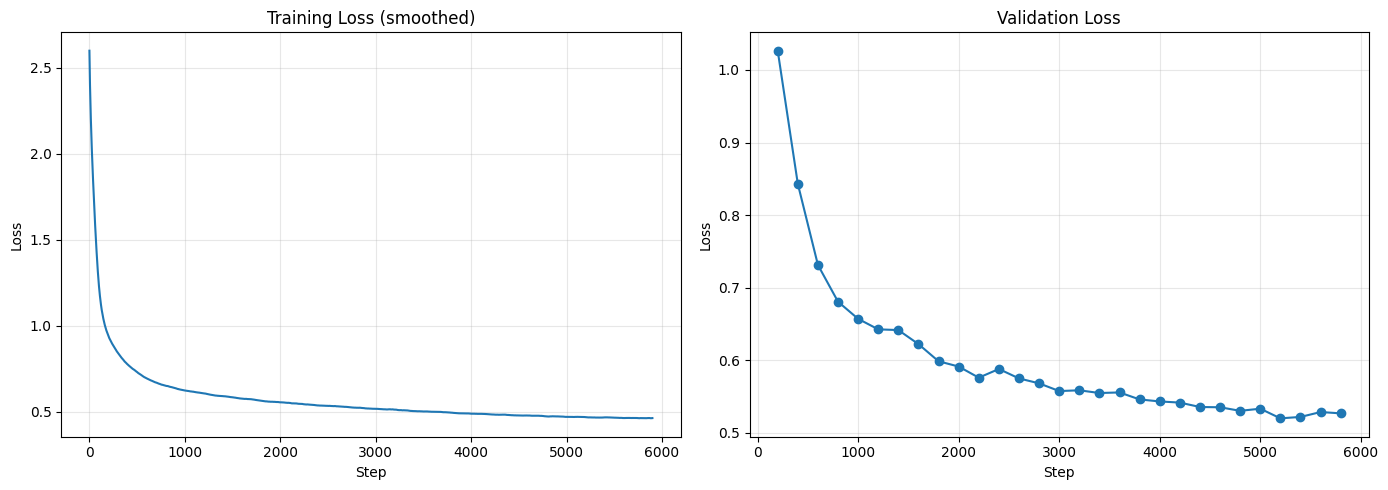

In [ ]:
# Plot training curves
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training loss (smoothed)
window = 100
smoothed = np.convolve(train_losses, np.ones(window)/window, mode='valid')
ax1.plot(smoothed)
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss (smoothed)')
ax1.grid(True, alpha=0.3)

# Validation loss
if val_losses:
    steps, losses = zip(*val_losses)
    ax2.plot(steps, losses, 'o-')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Loss')
    ax2.set_title('Validation Loss')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/training_curves.png', dpi=150)
plt.show()

## 6. Test Generation

In [ ]:
# Generate sample text
model.eval()

prompts = [
    "The meaning of life is",
    "In a world where artificial intelligence",
    "Once upon a time, there was a",
    "The best way to learn programming is",
]

print("Sample generations:")
print("=" * 60)

for prompt in prompts:
    idx = torch.tensor([list(prompt.encode('utf-8'))], dtype=torch.long, device=DEVICE)
    output = model.generate(idx, max_new_tokens=150, temperature=0.8, top_k=40)
    text = bytes(output[0].tolist()).decode('utf-8', errors='replace')

    print(f"\nPrompt: {prompt}")
    print(f"Output: {text}")
    print("-" * 60)

Sample generations:

Prompt: The meaning of life is
Output: The meaning of life is a magical part of a raisy way. She has a special pink wagon that can take things that are allowed to touch.

Once upon a time there was a big party. 
------------------------------------------------------------

Prompt: In a world where artificial intelligence
Output: In a world where artificial intelligence and a whale wanted to be saved!

The fish and the whale worked together to build a river. Soon the whale was sailing around the river with soap! Ever
------------------------------------------------------------

Prompt: Once upon a time, there was a
Output: Once upon a time, there was a big man who had a special gun. He had a stick and he helped to pull things that were not toys. One day, the man asked a little girl to help him pull 
------------------------------------------------------------

Prompt: The best way to learn programming is
Output: The best way to learn programming is more important th

---

## 7. Sparse Autoencoder (SAE) Training

Now we train a sparse autoencoder on the residual stream to extract interpretable features.

In [ ]:
# Load model from Google Drive checkpoint
import torch

# Options: 'best', 'final', or a specific step number like 1000
CHECKPOINT_TYPE = 'best'

# Construct path based on checkpoint type
if CHECKPOINT_TYPE == 'best':
    checkpoint_path = f'{SAVE_DIR}/checkpoints/best_model.pt'
elif CHECKPOINT_TYPE == 'final':
    checkpoint_path = f'{SAVE_DIR}/char_gpt_final.pt'
else:
    checkpoint_path = f'{SAVE_DIR}/checkpoints/step_{CHECKPOINT_TYPE}.pt'

print(f"Loading checkpoint from: {checkpoint_path}")

# Load checkpoint - disable weights_only since we trust our own checkpoint
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
# Reconstruct config
config = checkpoint['config']
print(f"\nModel config:")
print(f"  d_model: {config.d_model}")
print(f"  n_layers: {config.n_layers}")
print(f"  n_heads: {config.n_heads}")
print(f"  context_length: {config.context_length}")

# Create model and load weights
model = CharGPT(config).to(DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()

# Print checkpoint info
if 'step' in checkpoint:
    print(f"\nCheckpoint step: {checkpoint['step']}")
if 'loss' in checkpoint:
    print(f"Checkpoint loss: {checkpoint['loss']:.4f}")

n_params = sum(p.numel() for p in model.parameters())
print(f"Loaded model with {n_params / 1e6:.2f}M parameters")

Loading checkpoint from: /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt

Model config:
  d_model: 512
  n_layers: 8
  n_heads: 8
  context_length: 512

Checkpoint step: 5200
Checkpoint loss: 0.5201
Loaded model with 25.83M parameters


In [ ]:
from collections import defaultdict
import json

@dataclass
class SAEConfig:
    """Configuration for Sparse Autoencoder."""
    d_model: int = 512              # Input dimension
    n_features: int = 16384         # SAE features (32x expansion)
    k: int = 32                     # Top-k active features

    learning_rate: float = 1e-4
    batch_size: int = 4096
    warmup_steps: int = 1000
    total_steps: int = 30000

    tied_weights: bool = False
    normalize_decoder: bool = True

    aux_k: int = 256
    aux_loss_coef: float = 1/32

    dead_threshold: int = 10000
    resample_dead: bool = True


class TopKSparseAutoencoder(nn.Module):
    """Sparse Autoencoder with Top-K activation selection."""

    def __init__(self, config: SAEConfig):
        super().__init__()
        self.config = config

        self.encoder = nn.Linear(config.d_model, config.n_features, bias=True)
        self.decoder = nn.Linear(config.n_features, config.d_model, bias=False)
        self.pre_bias = nn.Parameter(torch.zeros(config.d_model))

        self._init_weights()

        self.register_buffer('feature_activation_counts',
                           torch.zeros(config.n_features, dtype=torch.long))
        self.register_buffer('total_steps', torch.tensor(0, dtype=torch.long))

    def _init_weights(self):
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.decoder.weight, a=math.sqrt(5))
        with torch.no_grad():
            # Normalize columns of the decoder weight matrix (features directions)
            self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=1)
        nn.init.zeros_(self.encoder.bias)
        nn.init.zeros_(self.pre_bias)

    def normalize_decoder_(self):
        with torch.no_grad():
            # Normalize columns of the decoder weight matrix (features directions)
            self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=1)

    def encode(self, x):
        x_centered = x - self.pre_bias
        z_pre = self.encoder(x_centered)
        z_relu = F.relu(z_pre)
        topk_values, topk_indices = torch.topk(z_relu, self.config.k, dim=-1)
        z_topk = torch.zeros_like(z_pre)
        z_topk.scatter_(dim=-1, index=topk_indices, src=topk_values)
        return z_topk, topk_indices, topk_values

    def decode(self, z):
        # z is [batch, n_features], decoder.weight is [d_model, n_features]
        # Need to transpose: [batch, n_features] @ [n_features, d_model] = [batch, d_model]
        return z @ self.decoder.weight.T + self.pre_bias

    def forward(self, x, return_aux=True):
        z, topk_indices, topk_values = self.encode(x)
        x_hat = self.decode(z)

        recon_loss = F.mse_loss(x_hat, x)

        if self.training:
            self.total_steps += 1
            unique_features = topk_indices.unique()
            self.feature_activation_counts[unique_features] = self.total_steps

        aux_loss = torch.tensor(0.0, device=x.device)
        if return_aux and self.config.aux_loss_coef > 0:
            residual = x - x_hat
            z_pre_residual = self.encoder(residual)
            z_relu_residual = F.relu(z_pre_residual)

            mask = torch.ones_like(z_relu_residual)
            mask.scatter_(dim=-1, index=topk_indices,
                        src=torch.zeros_like(topk_indices, dtype=mask.dtype))
            z_masked = z_relu_residual * mask

            aux_values, aux_indices = torch.topk(z_masked, self.config.aux_k, dim=-1)
            z_aux = torch.zeros_like(z_pre_residual)
            z_aux.scatter_(dim=-1, index=aux_indices, src=aux_values)

            residual_hat = self.decode(z_aux)
            aux_loss = F.mse_loss(residual_hat, residual)

        loss = recon_loss + self.config.aux_loss_coef * aux_loss

        return {
            'x_hat': x_hat, 'z': z,
            'topk_indices': topk_indices, 'topk_values': topk_values,
            'loss': loss, 'recon_loss': recon_loss, 'aux_loss': aux_loss,
        }

    def get_dead_features(self):
        steps_since = self.total_steps - self.feature_activation_counts
        return (steps_since > self.config.dead_threshold).nonzero().squeeze(-1)

    @torch.no_grad()
    def resample_dead_features(self, data_sample):
        dead_indices = self.get_dead_features()
        if len(dead_indices) == 0:
            return 0

        output = self.forward(data_sample, return_aux=False)
        losses = (output['x_hat'] - data_sample).pow(2).mean(dim=-1)
        probs = losses / losses.sum()
        sample_indices = torch.multinomial(probs, len(dead_indices), replacement=True)

        for i, dead_idx in enumerate(dead_indices):
            new_dir = data_sample[sample_indices[i]] - self.pre_bias
            new_dir = F.normalize(new_dir, dim=-1)
            self.encoder.weight.data[dead_idx] = new_dir * 0.2
            self.encoder.bias.data[dead_idx] = 0.0
            # Update the corresponding column in the decoder weight matrix
            self.decoder.weight.data[:, dead_idx] = new_dir

        self.feature_activation_counts[dead_indices] = self.total_steps
        return len(dead_indices)


print("SAE classes defined!")

SAE classes defined!


## 8. Collect Activations from GPT

In [ ]:
# Configuration
LAYER_IDX = 4            # Middle layer often has good features
POSITION = 'mid'         # After attention, before MLP
MAX_ACTIVATIONS = 10_000_000 # Number of activation vectors to collect

print(f"Collecting activations from layer {LAYER_IDX}, position '{POSITION}'")
print(f"Target: {MAX_ACTIVATIONS:,} vectors")

Target: 10,000,000 vectors


In [ ]:
# Create datasets and dataloaders
train_dataset = CharDataset(train_data, config.context_length)
val_dataset = CharDataset(val_data, config.context_length)

In [ ]:
# Collect activations - memory efficient version
model.eval()

# Pre-allocate tensor on CPU
activations = torch.empty(MAX_ACTIVATIONS, config.d_model, dtype=torch.float32)
total_collected = 0

activation_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0  # reduce to 0 to save RAM
)

pbar = tqdm(total=MAX_ACTIVATIONS, desc="Collecting activations")

with torch.no_grad():
    for x, _ in activation_loader:
        x = x.to(DEVICE)

        output = model(x, return_residuals=True, layers_to_capture=[LAYER_IDX])

        layer_key = f'layer_{LAYER_IDX}'
        if layer_key in output['residuals']:
            acts = output['residuals'][layer_key][POSITION]
            acts = acts.view(-1, acts.size(-1)).cpu()  # [B*T, d_model]

            # Calculate how many we can still add
            n_to_add = min(acts.size(0), MAX_ACTIVATIONS - total_collected)

            # Write directly into pre-allocated tensor
            activations[total_collected:total_collected + n_to_add] = acts[:n_to_add]
            total_collected += n_to_add
            pbar.update(n_to_add)

            if total_collected >= MAX_ACTIVATIONS:
                break

pbar.close()

# Trim if needed (shouldn't be necessary)
activations = activations[:total_collected]

print(f"\nCollected {len(activations):,} activation vectors")
print(f"Shape: {activations.shape}")
print(f"Memory: {activations.numel() * 4 / 1e9:.2f} GB")
print(f"Mean: {activations.mean():.4f}, Std: {activations.std():.4f}")


Collected 250,000 activation vectors
Shape: torch.Size([250000, 512])
Memory: 0.51 GB
Mean: -0.0177, Std: 3.0300


In [ ]:
# Save activations to Drive (optional, for resuming)
act_path = f'{SAVE_DIR}/activations_layer{LAYER_IDX}_{POSITION}.pt'
torch.save(activations, act_path)
print(f"Saved activations to {act_path}")

Saved activations to /content/drive/MyDrive/char_gpt_sae/activations_layer4_mid.pt


## 9. Train SAE

In [ ]:
# SAE Configuration
sae_config = SAEConfig(
    d_model=config.d_model,  # 512
    n_features=16384,        # 32x expansion
    k=32,                    # Top-k sparsity
    learning_rate=1e-4,
    batch_size=4096,
    total_steps=30000,
)

print(f"SAE Configuration:")
print(f"  Input dim: {sae_config.d_model}")
print(f"  Features: {sae_config.n_features}")
print(f"  Top-k: {sae_config.k}")
print(f"  Expansion: {sae_config.n_features / sae_config.d_model:.1f}x")

# Create SAE
sae = TopKSparseAutoencoder(sae_config).to(DEVICE)
n_sae_params = sum(p.numel() for p in sae.parameters())
print(f"  Parameters: {n_sae_params / 1e6:.2f}M")

SAE Configuration:
  Input dim: 512
  Features: 16384
  Top-k: 32
  Expansion: 32.0x
  Parameters: 16.79M


In [ ]:
# Training setup
sae_optimizer = torch.optim.Adam(sae.parameters(), lr=sae_config.learning_rate)

# Create activation dataset
class ActivationDataset(Dataset):
    def __init__(self, activations):
        self.activations = activations
    def __len__(self):
        return len(self.activations)
    def __getitem__(self, idx):
        return self.activations[idx]

act_dataset = ActivationDataset(activations)
act_loader = DataLoader(
    act_dataset,
    batch_size=sae_config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Activation batches: {len(act_loader)}")

NameError: name 'activations' is not defined

In [ ]:
# Patch the decode method
def fixed_decode(self, z):
    return z @ self.decoder.weight.T + self.pre_bias

# Apply fix
import types
sae.decode = types.MethodType(fixed_decode, sae)

print("Fixed SAE decode method")
print(f"z shape will be: [batch, {sae_config.n_features}]")
print(f"decoder.weight shape: {sae.decoder.weight.shape}")
print(f"output shape will be: [batch, {sae_config.d_model}]")

Fixed SAE decode method
z shape will be: [batch, 16384]
decoder.weight shape: torch.Size([512, 16384])
output shape will be: [batch, 512]


In [ ]:
temp_step = step

In [ ]:
# SAE Training loop
print("\nStarting SAE training...")
print("=" * 60)

sae.train()
act_iter = iter(act_loader)
sae_metrics = defaultdict(list)

for step in range(temp_step, sae_config.total_steps):
    # Learning rate warmup
    if step < sae_config.warmup_steps:
        lr = sae_config.learning_rate * (step + 1) / sae_config.warmup_steps
        for pg in sae_optimizer.param_groups:
            pg['lr'] = lr

    # Get batch
    try:
        batch = next(act_iter)
    except StopIteration:
        act_iter = iter(act_loader)
        batch = next(act_iter)

    batch = batch.to(DEVICE)

    # Forward
    output = sae(batch)
    loss = output['loss']

    # Backward
    sae_optimizer.zero_grad()
    loss.backward()
    sae_optimizer.step()

    # Normalize decoder
    sae.normalize_decoder_()

    # Logging
    if step % 500 == 0:
        with torch.no_grad():
            n_active = (output['z'] > 0).float().sum(dim=-1).mean().item()
            n_dead = len(sae.get_dead_features())
            utilization = 1 - n_dead / sae_config.n_features

            x_var = batch.var()
            residual_var = (batch - output['x_hat']).var()
            explained_var = (1 - residual_var / x_var).item()

        sae_metrics['step'].append(step)
        sae_metrics['recon_loss'].append(output['recon_loss'].item())
        sae_metrics['explained_var'].append(explained_var)
        sae_metrics['utilization'].append(utilization)

        print(f"step {step:5d} | recon {output['recon_loss'].item():.4f} | "
              f"aux {output['aux_loss'].item():.4f} | active {n_active:.1f} | "
              f"util {utilization:.1%} | expl_var {explained_var:.1%}")

    # Resample dead features
    if sae_config.resample_dead and step > 0 and step % 5000 == 0:
        sample_idx = torch.randperm(len(activations))[:10000]
        sample = activations[sample_idx].to(DEVICE)
        n_resampled = sae.resample_dead_features(sample)
        if n_resampled > 0:
            print(f"  → Resampled {n_resampled} dead features")

    # Save checkpoint
    if step > 0 and step % 10000 == 0:
        import dataclasses # Ensure dataclasses is imported
        sae_path = f'{SAVE_DIR}/sae_checkpoints/sae_step_{step}.pt'
        torch.save({
            'model': sae.state_dict(),
            'config': dataclasses.asdict(sae_config), # Save config as dict
            'optimizer': sae_optimizer.state_dict(),
            'step': step,
        }, sae_path)
        print(f"  → Saved SAE to {sae_path}")

print("\n" + "=" * 60)
print("SAE Training complete!")


Starting SAE training...
step     0 | recon 11.0336 | aux 21.8279 | active 32.0 | util 100.0% | expl_var -20.7%
step   500 | recon 6.0558 | aux 8.5559 | active 32.0 | util 100.0% | expl_var 34.2%
step  1000 | recon 2.5415 | aux 2.9205 | active 32.0 | util 100.0% | expl_var 72.4%
step  1500 | recon 1.7359 | aux 1.6465 | active 32.0 | util 100.0% | expl_var 81.2%
step  2000 | recon 1.4215 | aux 1.1937 | active 32.0 | util 100.0% | expl_var 84.5%
step  2500 | recon 1.2594 | aux 0.9752 | active 32.0 | util 100.0% | expl_var 86.1%
step  3000 | recon 1.1651 | aux 0.8464 | active 32.0 | util 100.0% | expl_var 87.3%
step  3500 | recon 1.0741 | aux 0.7375 | active 32.0 | util 100.0% | expl_var 88.2%
step  4000 | recon 1.0097 | aux 0.6643 | active 32.0 | util 100.0% | expl_var 89.0%
step  4500 | recon 0.9549 | aux 0.6046 | active 32.0 | util 100.0% | expl_var 89.6%
step  5000 | recon 0.9241 | aux 0.5630 | active 32.0 | util 100.0% | expl_var 90.0%
step  5500 | recon 0.8702 | aux 0.5138 | active

PicklingError: Can't pickle <class '__main__.SAEConfig'>: it's not the same object as __main__.SAEConfig

In [ ]:
 # Save checkpoint

import dataclasses # Ensure dataclasses is imported
sae_path = f'{SAVE_DIR}/sae_checkpoints/sae_step_{step}.pt'
torch.save({
    'model': sae.state_dict(),
    'config': dataclasses.asdict(sae_config), # Save config as dict
    'step': step,
}, sae_path)
print(f"  → Saved SAE to {sae_path}")

  → Saved SAE to /content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_10000.pt


In [ ]:
# Resume SAE training from checkpoint
import torch
import dataclasses # Import dataclasses

# Find the latest SAE checkpoint
sae_ckpt_dir = f'{SAVE_DIR}/sae_checkpoints'
sae_checkpoints = [f for f in os.listdir(sae_ckpt_dir) if f.startswith('sae_step_')]

if not sae_checkpoints:
    raise FileNotFoundError("No SAE checkpoints found!")

# Get the latest one
latest_step = max(int(f.split('_')[-1].replace('.pt', '')) for f in sae_checkpoints)
sae_ckpt_path = f'{sae_ckpt_dir}/sae_step_{latest_step}.pt'

print(f"Resuming from: {sae_ckpt_path}")

# Load checkpoint
sae_ckpt = torch.load(sae_ckpt_path, map_location=DEVICE, weights_only=False)

# Recreate SAE and load weights
sae_config_dict = sae_ckpt['config'] # Load as dict
# Reconstruct SAEConfig object from the dictionary
sae_config = SAEConfig(**sae_config_dict)
sae = TopKSparseAutoencoder(sae_config).to(DEVICE)
sae.load_state_dict(sae_ckpt['model'])

# Apply the decode fix again
import types
def fixed_decode(self, z):
    return z @ self.decoder.weight.T + self.pre_bias
sae.decode = types.MethodType(fixed_decode, sae)

# Recreate optimizer
sae_optimizer = torch.optim.Adam(sae.parameters(), lr=sae_config.learning_rate)

start_step = sae_ckpt['step']
print(f"Resuming from step {start_step}")
print(f"Will train until step {sae_config.total_steps}")

Resuming from: /content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_10000.pt
Resuming from step 10000
Will train until step 30000


In [ ]:
# Resume SAE training loop
print(f"\nResuming SAE training from step {start_step}...")
print("=" * 60)

sae.train()
act_iter = iter(act_loader)
sae_metrics = defaultdict(list)

for step in range(start_step + 1, sae_config.total_steps):
    # Learning rate (no warmup since we're past it)
    lr = sae_config.learning_rate
    for pg in sae_optimizer.param_groups:
        pg['lr'] = lr

    # Get batch
    try:
        batch = next(act_iter)
    except StopIteration:
        act_iter = iter(act_loader)
        batch = next(act_iter)

    batch = batch.to(DEVICE)

    # Forward
    output = sae(batch)
    loss = output['loss']

    # Backward
    sae_optimizer.zero_grad()
    loss.backward()
    sae_optimizer.step()

    # Normalize decoder
    sae.normalize_decoder_()

    # Logging
    if step % 500 == 0:
        with torch.no_grad():
            n_active = (output['z'] > 0).float().sum(dim=-1).mean().item()
            n_dead = len(sae.get_dead_features())
            utilization = 1 - n_dead / sae_config.n_features

            x_var = batch.var()
            residual_var = (batch - output['x_hat']).var()
            explained_var = (1 - residual_var / x_var).item()

        sae_metrics['step'].append(step)
        sae_metrics['recon_loss'].append(output['recon_loss'].item())
        sae_metrics['explained_var'].append(explained_var)
        sae_metrics['utilization'].append(utilization)

        print(f"step {step:5d} | recon {output['recon_loss'].item():.4f} | "
              f"aux {output['aux_loss'].item():.4f} | active {n_active:.1f} | "
              f"util {utilization:.1%} | expl_var {explained_var:.1%}")

    # Resample dead features
    if sae_config.resample_dead and step > 0 and step % 5000 == 0:
        sample_idx = torch.randperm(len(activations))[:10000]
        sample = activations[sample_idx].to(DEVICE)
        n_resampled = sae.resample_dead_features(sample)
        if n_resampled > 0:
            print(f"  → Resampled {n_resampled} dead features")

    # Save checkpoint (more frequently to be safe)
    # Save checkpoint
    if step > 0 and step % 10000 == 0:
        import dataclasses # Ensure dataclasses is imported
        sae_path = f'{SAVE_DIR}/sae_checkpoints/sae_step_{step}.pt'
        torch.save({
            'model': sae.state_dict(),
            'config': dataclasses.asdict(sae_config), # Save config as dict
            'step': step,
        }, sae_path)
        print(f"  → Saved SAE to {sae_path}")

print("\n" + "=" * 60)
print("SAE Training complete!")

# Save final
sae_final_path = f'{SAVE_DIR}/sae_final.pt'
torch.save({
    'model': sae.state_dict(),
    'config': sae_config,
    'metrics': dict(sae_metrics),
    'layer_idx': LAYER_IDX,
    'optimizer': sae_optimizer.state_dict(),
    'position': POSITION,
}, sae_final_path)
print(f"Saved final SAE to {sae_final_path}")


Resuming SAE training from step 10000...
step 10500 | recon 1.5819 | aux 0.7519 | active 32.0 | util 100.0% | expl_var 83.0%
step 11000 | recon 1.2796 | aux 0.6214 | active 32.0 | util 100.0% | expl_var 86.1%
step 11500 | recon 1.1465 | aux 0.5630 | active 32.0 | util 99.9% | expl_var 87.4%
step 12000 | recon 1.0748 | aux 0.5375 | active 32.0 | util 99.9% | expl_var 88.3%
step 12500 | recon 1.0188 | aux 0.5190 | active 32.0 | util 99.7% | expl_var 88.9%
step 13000 | recon 0.9841 | aux 0.5070 | active 32.0 | util 99.1% | expl_var 89.2%
step 13500 | recon 0.9563 | aux 0.5027 | active 32.0 | util 98.4% | expl_var 89.6%
step 14000 | recon 0.9156 | aux 0.4892 | active 32.0 | util 97.5% | expl_var 90.1%
step 14500 | recon 0.8944 | aux 0.4888 | active 32.0 | util 96.7% | expl_var 90.3%
step 15000 | recon 0.8650 | aux 0.4776 | active 32.0 | util 96.1% | expl_var 90.6%
  → Resampled 641 dead features
step 15500 | recon 0.8800 | aux 0.4706 | active 32.0 | util 99.7% | expl_var 90.4%
step 16000 

In [ ]:

# Save final SAE
sae_final_path = f'{SAVE_DIR}/sae_final.pt'
torch.save({
    'model': sae.state_dict(),
    'config': sae_config,
    'metrics': dict(sae_metrics),
    'layer_idx': LAYER_IDX,
    'position': POSITION,
    'optimizer': sae_optimizer.state_dict(),
}, sae_final_path)
print(f"Saved final SAE to {sae_final_path}")

Saved final SAE to /content/drive/MyDrive/char_gpt_sae/sae_final.pt


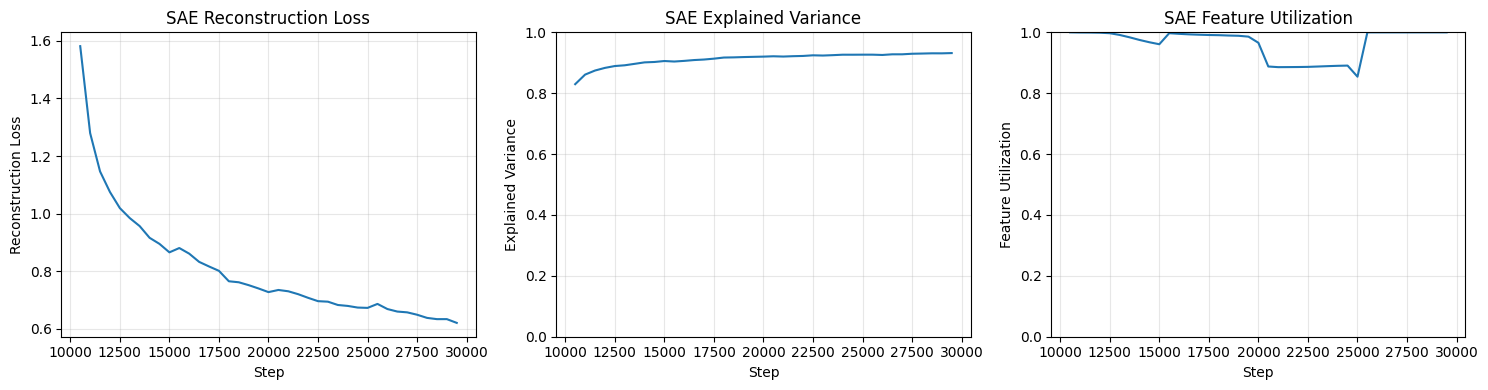

In [ ]:
import matplotlib.pyplot as plt
# Plot SAE training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(sae_metrics['step'], sae_metrics['recon_loss'])
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Reconstruction Loss')
axes[0].set_title('SAE Reconstruction Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sae_metrics['step'], sae_metrics['explained_var'])
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Explained Variance')
axes[1].set_title('SAE Explained Variance')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

axes[2].plot(sae_metrics['step'], sae_metrics['utilization'])
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Feature Utilization')
axes[2].set_title('SAE Feature Utilization')
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/sae_training_curves.png', dpi=150)
plt.show()

## 10. Feature Analysis

In [ ]:
# Analyze feature activation patterns
sae.eval()

# Compute activation statistics
feature_counts = torch.zeros(sae_config.n_features)
feature_sums = torch.zeros(sae_config.n_features)
feature_max = torch.zeros(sae_config.n_features)
n_samples = 0

with torch.no_grad():
    for i in range(0, len(activations), 4096):
        batch = activations[i:i+4096].to(DEVICE)
        output = sae(batch, return_aux=False)
        z = output['z'].cpu()

        feature_counts += (z > 0).float().sum(dim=0)
        feature_sums += z.sum(dim=0)
        feature_max = torch.maximum(feature_max, z.max(dim=0).values)
        n_samples += len(batch)

activation_freq = feature_counts / n_samples
mean_activation = feature_sums / feature_counts.clamp(min=1)

print(f"Feature Statistics:")
print(f"  Total features: {sae_config.n_features}")
print(f"  Dead features (never activated): {(feature_counts == 0).sum().item()}")
print(f"  Rare features (<0.1%): {(activation_freq < 0.001).sum().item()}")
print(f"  Mean activation frequency: {activation_freq.mean():.4f}")
print(f"  Median activation frequency: {activation_freq.median():.4f}")

Feature Statistics:
  Total features: 16384
  Dead features (never activated): 2844
  Rare features (<0.1%): 10311
  Mean activation frequency: 0.0020
  Median activation frequency: 0.0007


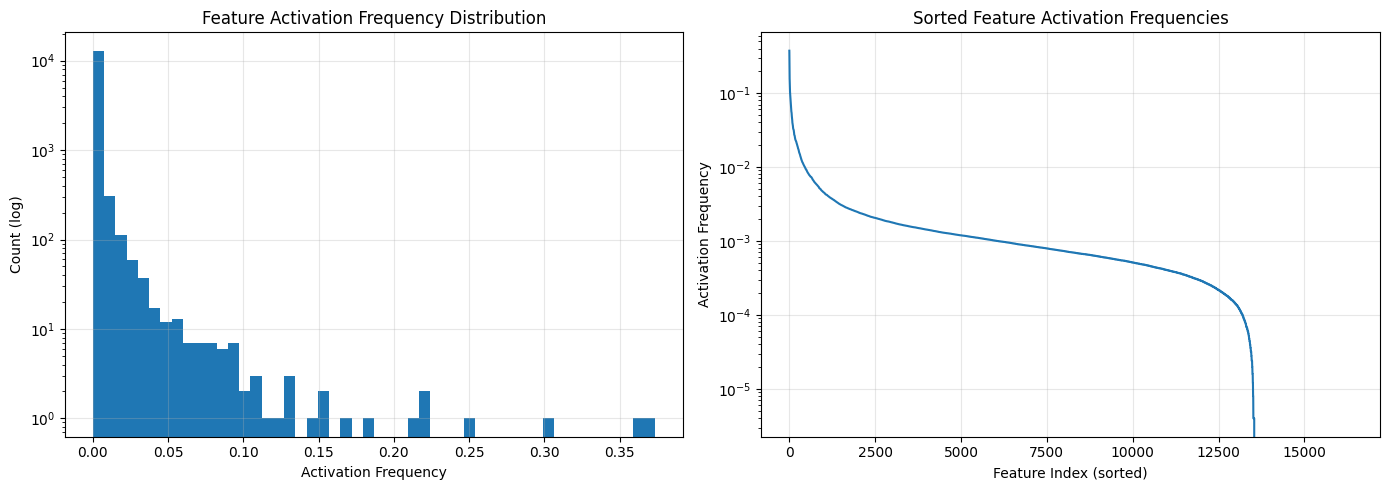

In [ ]:
# Plot activation frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log histogram of activation frequencies
freq_nonzero = activation_freq[activation_freq > 0]
axes[0].hist(freq_nonzero.numpy(), bins=50, log=True)
axes[0].set_xlabel('Activation Frequency')
axes[0].set_ylabel('Count (log)')
axes[0].set_title('Feature Activation Frequency Distribution')
axes[0].grid(True, alpha=0.3)

# Sorted activation frequencies
sorted_freq = activation_freq.sort(descending=True).values
axes[1].plot(sorted_freq.numpy())
axes[1].set_xlabel('Feature Index (sorted)')
axes[1].set_ylabel('Activation Frequency')
axes[1].set_title('Sorted Feature Activation Frequencies')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/feature_analysis.png', dpi=150)
plt.show()

In [ ]:
# Find most common features and what they activate on
print("\nTop 10 Most Frequent Features:")
print("=" * 60)

top_features = activation_freq.argsort(descending=True)[:10]

for rank, feat_idx in enumerate(top_features):
    freq = activation_freq[feat_idx].item()
    max_act = feature_max[feat_idx].item()
    print(f"  {rank+1}. Feature {feat_idx.item()}: freq={freq:.4f}, max={max_act:.2f}")


Top 10 Most Frequent Features:
  1. Feature 10503: freq=0.3737, max=697.86
  2. Feature 15275: freq=0.3594, max=255.81
  3. Feature 11508: freq=0.3026, max=250.28
  4. Feature 4102: freq=0.2506, max=562.77
  5. Feature 9512: freq=0.2223, max=516.23
  6. Feature 1764: freq=0.2169, max=249.57
  7. Feature 12676: freq=0.2103, max=241.37
  8. Feature 9885: freq=0.1801, max=208.10
  9. Feature 3818: freq=0.1668, max=327.46
  10. Feature 7046: freq=0.1536, max=202.25


## 11. Summary

Your trained models are saved to Google Drive at:

In [ ]:
print(f"📁 Save Directory: {SAVE_DIR}")
print(f"")
print(f"GPT Model:")
print(f"  • Final: {SAVE_DIR}/char_gpt_final.pt")
print(f"  • Best: {SAVE_DIR}/checkpoints/best_model.pt")
print(f"")
print(f"SAE Model:")
print(f"  • Final: {SAVE_DIR}/sae_final.pt")
print(f"  • Layer {LAYER_IDX}, position '{POSITION}'")
print(f"")
print(f"Data:")
print(f"  • Processed text: {SAVE_DIR}/openwebtext_500m.bin")
print(f"  • Activations: {SAVE_DIR}/activations_layer{LAYER_IDX}_{POSITION}.pt")
print(f"")
print(f"Plots:")
print(f"  • {SAVE_DIR}/training_curves.png")
print(f"  • {SAVE_DIR}/sae_training_curves.png")
print(f"  • {SAVE_DIR}/feature_analysis.png")

📁 Save Directory: /content/drive/MyDrive/char_gpt_sae

GPT Model:
  • Final: /content/drive/MyDrive/char_gpt_sae/char_gpt_final.pt
  • Best: /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt

SAE Model:
  • Final: /content/drive/MyDrive/char_gpt_sae/sae_final.pt
  • Layer 4, position 'mid'

Data:
  • Processed text: /content/drive/MyDrive/char_gpt_sae/openwebtext_500m.bin
  • Activations: /content/drive/MyDrive/char_gpt_sae/activations_layer4_mid.pt

Plots:
  • /content/drive/MyDrive/char_gpt_sae/training_curves.png
  • /content/drive/MyDrive/char_gpt_sae/sae_training_curves.png
  • /content/drive/MyDrive/char_gpt_sae/feature_analysis.png


In [ ]:
# List all saved files
!find {SAVE_DIR} -type f -name "*.pt" -o -name "*.png" -o -name "*.bin" | head -20

/content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_1000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_1500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_2000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_2500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_3000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_3500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_4000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_4500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_5000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_5500.pt
/content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_10000.pt
/content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_20000.pt
/content/drive/MyDrive/char_gpt_sae/TinyStories.bin
/content/drive/MyDrive/char_gpt_sae/char_gpt_final.pt
/content/drive/MyDrive

# Analysis

In [ ]:
# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_DIR = '/content/drive/MyDrive/char_gpt_sae'
gpt_path = f'{SAVE_DIR}/checkpoints/best_model.pt'
sae_path = f'{SAVE_DIR}/sae_final.pt'

print(f"Loading from {SAVE_DIR} on {DEVICE}...")

# 1. Load GPT Model (Best Checkpoint)
if os.path.exists(gpt_path):
    print(f"Loading GPT (BEST) from {gpt_path}...")
    # weights_only=False is required because the checkpoint contains the custom Config object
    checkpoint = torch.load(gpt_path, map_location=DEVICE, weights_only=False)

    # Reconstruct Config
    if isinstance(checkpoint['config'], dict):
        gpt_config = GPTConfig(**checkpoint['config'])
    else:
        gpt_config = checkpoint['config']

    # Instantiate and Load
    # Ensure CharGPT class is defined (run the model definition cell first if needed)
    model = CharGPT(gpt_config)
    model.load_state_dict(checkpoint['model'])
    model.to(DEVICE)
    model.eval()
    print("GPT Model (Best) loaded successfully!")
else:
    print(f"WARNING: GPT model not found at {gpt_path}")

# 2. Load SAE Model
if os.path.exists(sae_path):
    print(f"Loading SAE from {sae_path}...")

    # !!! FIX: Added weights_only=False here !!!
    sae_checkpoint = torch.load(sae_path, map_location=DEVICE, weights_only=False)

    raw_sae_config = sae_checkpoint['config']
    if isinstance(raw_sae_config, dict):
        sae_config = SAEConfig(**raw_sae_config)
    else:
        sae_config = raw_sae_config

    sae = TopKSparseAutoencoder(sae_config)
    sae.load_state_dict(sae_checkpoint['model'])
    sae.to(DEVICE)
    sae.eval()
    print("SAE Model loaded successfully!")
else:
    print(f"WARNING: SAE model not found at {sae_path}")

Loading from /content/drive/MyDrive/char_gpt_sae on cuda...
Loading GPT (BEST) from /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt...
GPT Model (Best) loaded successfully!
Loading SAE from /content/drive/MyDrive/char_gpt_sae/sae_final.pt...
SAE Model loaded successfully!


Identifying common words...
Top words to test: ['the', 'and', 'was', 'to', 'a', 'he', 'it', 'she', 'they', 'his']

Scanning 500 batches for word occurrences...

Results: Top SAE Features per Word
------------------------------------------------------------
Word 'the       ': Feat 1094 (freq=77341, avg=140.13), Feat 1882 (freq=77341, avg=116.48), Feat 6367 (freq=77341, avg=116.69)
Word 'and       ': Feat 3885 (freq=76520, avg=107.35), Feat 2224 (freq=72757, avg=136.95), Feat 10855 (freq=51224, avg=43.95)
Word 'was       ': Feat 11763 (freq=44967, avg=80.11), Feat 2732 (freq=44907, avg=87.28), Feat 3512 (freq=44416, avg=115.70)
Word 'to        ': Feat 8327 (freq=53163, avg=89.50), Feat 13571 (freq=53163, avg=87.20), Feat 14996 (freq=53163, avg=66.74)
Word 'a         ': Feat 4878 (freq=39205, avg=99.34), Feat 15454 (freq=39205, avg=92.26), Feat 15165 (freq=39203, avg=128.81)
Word 'he        ': Feat 12282 (freq=36055, avg=146.78), Feat 14080 (freq=36039, avg=134.81), Feat 4938 (freq=35797,

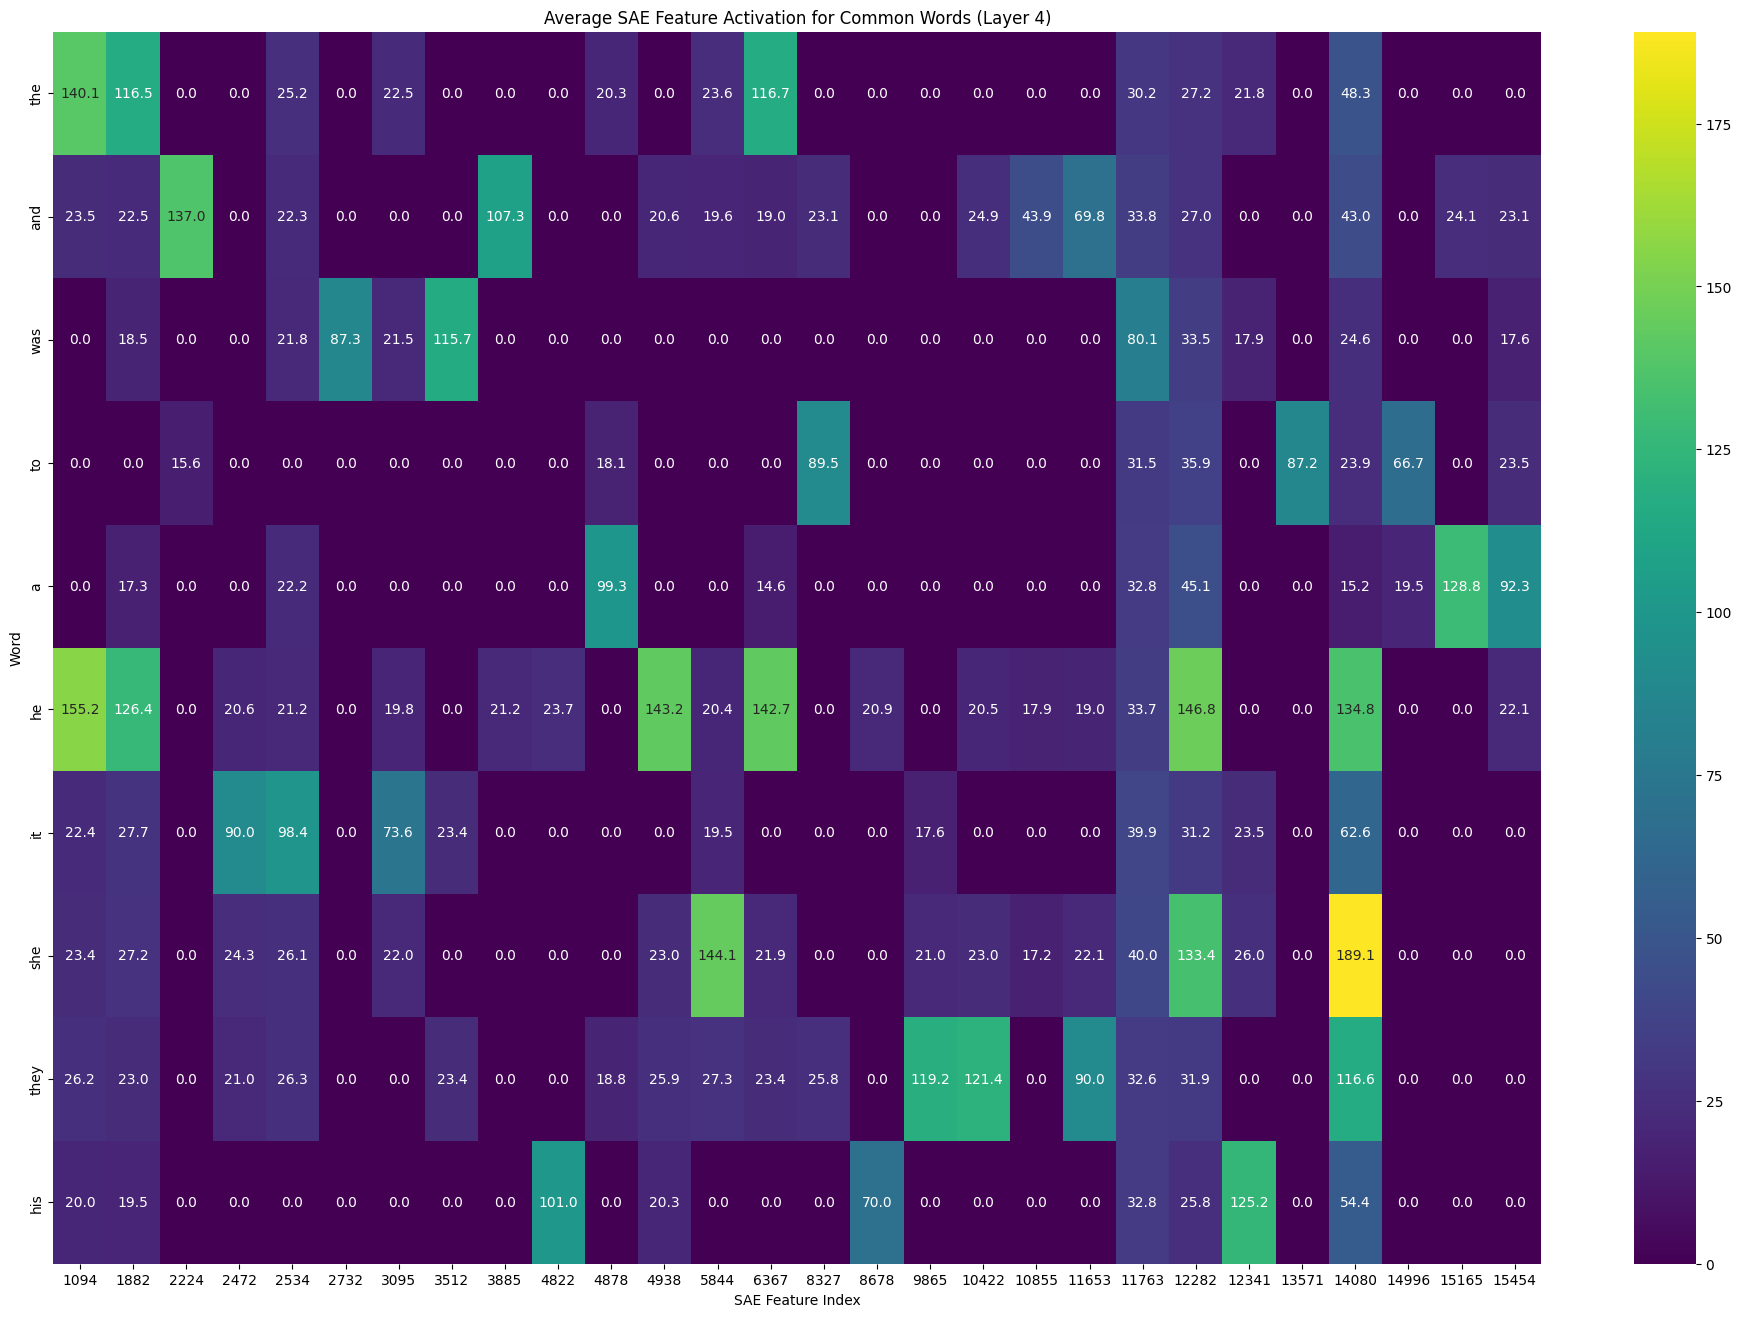

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
import re

# --- Configuration ---
# Words to test (automatically finds top words, or you can set a custom list)
NUM_TOP_WORDS = 10
NUM_BATCHES_TO_SCAN = 500  # How much data to scan
LAYER_TO_PROBE = 4        # Must match the layer you trained the SAE on
POSITION_TO_PROBE = 'mid' # Must match SAE training ('mid' or 'post_mlp')

# 1. Identify Common Words in Validation Data
# ------------------------------------------
print("Identifying common words...")
decoder = {i: chr(i) for i in range(256)}
def decode_tokens(tokens):
    return "".join([decoder[t.item()] for t in tokens])

# Scan a bit of data to find frequencies
sample_text = val_data[:100000].decode('utf-8', errors='replace')
# Simple split by whitespace to count words
words = re.findall(r'\b\w+\b', sample_text.lower())
common_words = [w for w, c in Counter(words).most_common(NUM_TOP_WORDS)]
print(f"Top words to test: {common_words}")

# 2. Collect SAE Activations for these words
# ------------------------------------------
print(f"\nScanning {NUM_BATCHES_TO_SCAN} batches for word occurrences...")
word_feature_acts = defaultdict(list)

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(val_loader):
        if batch_idx >= NUM_BATCHES_TO_SCAN:
            break

        x = x.to(DEVICE)

        # Run GPT to get activations
        gpt_out = model(x, return_residuals=True, layers_to_capture=[LAYER_TO_PROBE])
        # [Batch, Seq_Len, D_Model]
        acts = gpt_out['residuals'][f'layer_{LAYER_TO_PROBE}'][POSITION_TO_PROBE]

        # Analyze text in this batch
        for b in range(x.shape[0]):
            text = decode_tokens(x[b])

            for word in common_words:
                # Find the word padded by spaces to ensure whole-word matching
                # (We search for " word " or " word." etc)
                # For simplicity in this script, we look for the literal sequence
                # and take the index of the last character of the word.

                # Regex to find word boundaries
                matches = list(re.finditer(rf'\b{re.escape(word)}\b', text, re.IGNORECASE))

                for m in matches:
                    end_idx = m.end() - 1 # Index of the last character

                    if end_idx < config.context_length:
                        # Grab the vector at the end of the word
                        # acts is [Batch, Seq, Dim]
                        vector = acts[b, end_idx, :] # [Dim]

                        # Pass through SAE
                        # encode returns: z, topk_indices, topk_values
                        _, topk_ind, topk_val = sae.encode(vector)

                        # Store the active features for this word instance
                        # We store pairs of (feature_index, activation_value)
                        for feat_idx, feat_val in zip(topk_ind.tolist(), topk_val.tolist()):
                            if feat_val > 0:
                                word_feature_acts[word].append((feat_idx, feat_val))

# 3. Aggregate and Visualize
# ------------------------------------------
print("\nResults: Top SAE Features per Word")
print("-" * 60)

unique_features_found = set()

# Prepare data for plotting
plot_data = []

for word in common_words:
    if word not in word_feature_acts:
        print(f"Word '{word}': No occurrences found in scan.")
        continue

    # Aggregate feature activations
    feature_counts = Counter()
    feature_sums = defaultdict(float)

    occurrences = len([x for x in word_feature_acts[word]]) # Rough proxy for total hits

    for fid, val in word_feature_acts[word]:
        feature_counts[fid] += 1
        feature_sums[fid] += val

    # Get top 3 features by frequency of firing
    top_features = feature_counts.most_common(3)

    feats_str = []
    for fid, count in top_features:
        avg_act = feature_sums[fid] / count
        feats_str.append(f"Feat {fid} (freq={count}, avg={avg_act:.2f})")
        unique_features_found.add(fid)
        plot_data.append({'Word': word, 'Feature': str(fid), 'Score': avg_act * count}) # Score = Total Activation Mass

    print(f"Word '{word:<10}': {', '.join(feats_str)}")

# 4. Heatmap Visualization
# ------------------------------------------
if plot_data:
    # Create a matrix: Words x Top Unique Features
    # We collect all unique features that appeared in top-3 lists
    top_feats_list = sorted(list(unique_features_found))
    matrix = np.zeros((len(common_words), len(top_feats_list)))

    for i, word in enumerate(common_words):
        if word not in word_feature_acts: continue

        # Re-calculate average activation for these specific top features
        # to fill the matrix (even if it wasn't the #1 feature for this word)
        current_word_data = word_feature_acts[word] # list of (fid, val)
        feat_map = defaultdict(float)
        count_map = defaultdict(int)
        for fid, val in current_word_data:
            feat_map[fid] += val
            count_map[fid] += 1

        for j, fid in enumerate(top_feats_list):
            if count_map[fid] > 0:
                # Metric: Average activation magnitude
                matrix[i, j] = feat_map[fid] / count_map[fid]

    plt.figure(figsize=(24, 16))
    sns.heatmap(matrix, xticklabels=top_feats_list, yticklabels=common_words, cmap="viridis", annot=True, fmt=".1f")
    plt.title(f"Average SAE Feature Activation for Common Words (Layer {LAYER_TO_PROBE})")
    plt.xlabel("SAE Feature Index")
    plt.ylabel("Word")
    plt.show()

In [ ]:
import torch
import re
from collections import defaultdict, Counter
import pandas as pd

# --- Configuration ---
NUM_WORDS_TO_TEST = 50       # Look at top 50 words
ACTIVATION_THRESHOLD = 1.0   # Only count features with activation > this value
MIN_FIRING_RATE = 0.4        # Feature must fire in at least 40% of the word's occurrences to be listed
NUM_BATCHES = 100            # Scan more data for better statistics

# 1. Identify Words
# -----------------
print(f"identifying top {NUM_WORDS_TO_TEST} words...")
# Helper to decode for finding words
decoder = {i: chr(i) for i in range(256)}
def decode_str(tokens):
    return "".join([decoder[t.item()] for t in tokens])

# Get a sample text to find common words
sample_text = val_data[:200000].decode('utf-8', errors='replace')
words_found = re.findall(r'\b[a-zA-Z]+\b', sample_text.lower()) # simple alpha words
target_words = [w for w, c in Counter(words_found).most_common(NUM_WORDS_TO_TEST)]

print(f"Target words: {target_words}")

# 2. Collect Stats
# ----------------
# Structure: word_stats[word][feature_index] = list of activation values
word_stats = defaultdict(lambda: defaultdict(list))
word_counts = Counter()

# --- Configuration ---
MIN_OCCURRENCES = 30       # Target: Find at least 30 examples of each word
MAX_BATCHES = 500          # Safety limit: Don't scan forever if a word is super rare
# ---------------------

print(f"\nScanning until we find {MIN_OCCURRENCES} examples per word (or limit {MAX_BATCHES} batches)...")

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        # Stop if we have enough data for ALL words OR we hit the limit
        all_satisfied = all(word_counts[w] >= MIN_OCCURRENCES for w in target_words)
        if all_satisfied:
            print(f"Stopping early at batch {batch_idx}: collected enough samples for all words.")
            break
        if batch_idx >= MAX_BATCHES:
            print(f"Stopping at max limit {batch_idx} batches.")
            break

        x = x.to(DEVICE)

        # ... (Rest of the activation harvesting code is the same) ...
        # Get Model Activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid']

        for b in range(x.shape[0]):
            text = decode_str(x[b])
            for word in target_words:
                # OPTIMIZATION: Skip processing this word if we already have enough samples
                if word_counts[word] >= MIN_OCCURRENCES:
                    continue

                for m in re.finditer(rf'\b{re.escape(word)}\b', text, re.IGNORECASE):
                    end_idx = m.end() - 1
                    if end_idx < config.context_length:
                        # ... (encode and record stats) ...
                        vector = acts[b, end_idx, :]
                        _, topk_ind, topk_val = sae.encode(vector)

                        word_counts[word] += 1

                        inds = topk_ind.cpu().numpy()
                        vals = topk_val.cpu().numpy()
                        for idx, val in zip(inds, vals):
                            if val > ACTIVATION_THRESHOLD:
                                word_stats[word][idx].append(val)
# 3. Process and Display Results
# ------------------------------
print(f"\n{'='*80}")
print(f"{'WORD':<15} | {'COUNT':<5} | {'SIGNIFICANT FEATURES (> threshold & consistent)'}")
print(f"{'='*80}")

# Store for reverse lookup (Feature -> Words)
feature_to_words = defaultdict(list)

for word in target_words:
    count = word_counts[word]
    if count == 0: continue

    significant_features = []

    # Analyze features for this word
    for fid, values in word_stats[word].items():
        firing_count = len(values)
        firing_rate = firing_count / count
        avg_act = sum(values) / firing_count

        if firing_rate >= MIN_FIRING_RATE:
            feat_desc = f"F{fid}({firing_rate:.0%}, {avg_act:.1f})"
            significant_features.append((fid, firing_rate, feat_desc))

            # Save for reverse lookup
            feature_to_words[fid].append((word, firing_rate))

    # Sort by firing rate (consistency)
    significant_features.sort(key=lambda x: x[1], reverse=True)

    # Format output
    feats_str = ", ".join([x[2] for x in significant_features[:10]]) # Show top n
    if len(significant_features) > 5:
        feats_str += ", ..."

    print(f"{word:<15} | {count:<5} | {feats_str}")

# 4. (Optional) Reverse Lookup: What do specific features mean?
# -------------------------------------------------------------
print(f"\n{'='*80}")
print("REVERSE LOOKUP: Features shared by multiple words")
print(f"{'='*80}")

sorted_features = sorted(feature_to_words.items(), key=lambda x: len(x[1]), reverse=True)

for fid, word_list in sorted_features[:10]: # Top 10 most common features
    if len(word_list) > 1:
        words_str = ", ".join([f"{w}({rate:.0%})" for w, rate in word_list])
        print(f"Feature {fid:<6} : {words_str}")

identifying top 50 words...
Target words: ['the', 'and', 'to', 'was', 'a', 'he', 'it', 'she', 'her', 'they', 'so', 'his', 'in', 'day', 'of', 'said', 'that', 'had', 'little', 'but', 'with', 'there', 'one', 'time', 's', 'very', 'once', 'for', 'girl', 'on', 'you', 'big', 'mom', 'happy', 'were', 'upon', 'saw', 'all', 't', 'i', 'wanted', 'tim', 'went', 'at', 'him', 'as', 'friends', 'around', 'when', 'back']

Scanning until we find 30 examples per word (or limit 500 batches)...
Stopping at max limit 500 batches.

WORD            | COUNT | SIGNIFICANT FEATURES (> threshold & consistent)
the             | 32    | F1094(100%, 148.8), F1882(100%, 131.2), F6367(100%, 106.0), F5033(100%, 84.9), F14927(100%, 85.9), F2006(100%, 85.1), F202(100%, 84.6), F3876(100%, 78.2), F9722(100%, 68.1), F2163(88%, 66.1), ...
and             | 30    | F2224(100%, 148.9), F3885(100%, 117.6), F10855(100%, 76.0), F2205(100%, 47.0), F12992(100%, 46.0), F6090(100%, 44.7), F11508(100%, 57.4), F10747(100%, 32.8), F11763(

In [ ]:
import torch
import torch.nn.functional as F

# --- Configuration ---
# 1. Enter the Feature IDs you found interesting from the previous step
# (Example: The features you found for 'the')
INTERESTING_FEATURES = [1094, 1882, 6367, 5033]

# 2. Settings
NUM_BATCHES_DEEP_DIVE = 50
EXAMPLE_CONTEXT_SIZE = 20  # Show 20 chars around the activation

# Storage
feature_data = {fid: {'activations': [], 'contexts': []} for fid in INTERESTING_FEATURES}

print(f"Deep diving into features: {INTERESTING_FEATURES}...")

# 1. Collect Data (Max Activating Examples)
# -----------------------------------------
model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        if batch_idx >= NUM_BATCHES_DEEP_DIVE:
            break

        x = x.to(DEVICE)

        # Get activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid'] # [Batch, Seq, Dim]

        # We need to flatten to run SAE efficiently or loop
        # Let's loop for clarity and context extraction
        for b in range(x.shape[0]):
            # Get the SAE feature activations for this entire sequence
            # Vector: [Seq, Dim] -> SAE -> [Seq, Num_Features] (sparse)
            # Optimization: Only compute if we strictly need to, but explicit loop is safer for context

            # For speed, let's run the whole sequence through the SAE encoder
            # acts[b]: [Seq, Dim]
            _, topk_ind, topk_val = sae.encode(acts[b])

            # topk_ind is [Seq, k], topk_val is [Seq, k]
            # We check if any of our interesting features are in the top-k

            # Convert to CPU for processing
            inds_np = topk_ind.cpu().numpy()
            vals_np = topk_val.cpu().numpy()

            text = decode_str(x[b])

            for t in range(inds_np.shape[0]): # Iterate over sequence positions
                current_feats = inds_np[t]
                current_vals = vals_np[t]

                for k_idx, fid in enumerate(current_feats):
                    if fid in feature_data:
                        val = current_vals[k_idx]
                        if val > 1.0: # Only significant hits
                            # Grab context window
                            start = max(0, t - EXAMPLE_CONTEXT_SIZE)
                            end = min(len(text), t + EXAMPLE_CONTEXT_SIZE)

                            # Mark the specific character with brackets
                            # e.g., "hello t[h]ere world"
                            prefix = text[start:t+1]
                            suffix = text[t+1:end]
                            snippet = f"{prefix}|{suffix}"

                            feature_data[fid]['activations'].append(val)
                            feature_data[fid]['contexts'].append(snippet)

# 2. Analyze & Print Results
# --------------------------
print(f"\n{'='*80}")
print("DEEP DIVE ANALYSIS")
print(f"{'='*80}")

vocab_weights = model.lm_head.weight # [Vocab, D_Model]
# If weights are tied, this might be model.tok_emb.weight
if vocab_weights is None:
    vocab_weights = model.tok_emb.weight

for fid in INTERESTING_FEATURES:
    print(f"\nFeature {fid}")
    print(f"{'-'*20}")

    # A. Max Activating Examples
    # Sort by activation strength descending
    data = list(zip(feature_data[fid]['activations'], feature_data[fid]['contexts']))
    data.sort(key=lambda x: x[0], reverse=True)

    print("Top 5 Max Activating Contexts (Where the feature screams):")
    if not data:
        print("  (No activations found)")
    else:
        for val, ctx in data[:5]:
            # Replace newlines for clean printing
            ctx_clean = ctx.replace('\n', '\\n')
            print(f"  Act {val:>6.1f} | ...{ctx_clean}...")

    # B. Logit Lens (What does this feature PREDICT?)
    # We look at the decoder vector for this feature and project it to the vocab
    # Decoder row: [D_Model]
    feature_vector = sae.decoder.weight[:, fid] # [D_Model]

    # Project to vocabulary: [D_Model] @ [D_Model, Vocab] -> [Vocab]
    # Note: lm_head.weight is usually [Vocab, D_Model], so we transpose it
    logits = feature_vector @ vocab_weights.T

    # Get top tokens
    top_tokens_val, top_tokens_ind = torch.topk(logits, 10)

    print("\nLogit Lens: What token does this feature promote?")
    tokens_str = []
    for val, idx in zip(top_tokens_val, top_tokens_ind):
        token_char = decoder.get(idx.item(), '')
        if token_char == '\n': token_char = '\\n'
        if token_char == ' ': token_char = '␣'
        tokens_str.append(f"'{token_char}'({val:.1f})")

    print(f"  promotes: {', '.join(tokens_str)}")

    # Check what it SUPPRESSES (Negative logits)
    bot_tokens_val, bot_tokens_ind = torch.topk(logits, 5, largest=False)
    neg_tokens_str = []
    for val, idx in zip(bot_tokens_val, bot_tokens_ind):
        token_char = decoder.get(idx.item(), '')
        if token_char == '\n': token_char = '\\n'
        neg_tokens_str.append(f"'{token_char}'({val:.1f})")
    print(f"  suppresses: {', '.join(neg_tokens_str)}")

Deep diving into features: [1094, 1882, 6367, 5033]...

DEEP DIVE ANALYSIS

Feature 1094
--------------------
Top 5 Max Activating Contexts (Where the feature screams):
  Act  204.1 | ...ld the|m that it was impor...
  Act  203.0 | ...t the| day he outsmarted ...
  Act  203.0 | ...t the| kids how to use th...
  Act  202.1 | ...e told the|m that it was impor...
  Act  200.7 | ... told the|m that it was impor...

Logit Lens: What token does this feature promote?
  promotes: 'r'(0.0), '␣'(0.0), 'Ã'(0.0), 'n'(0.0), 'E'(0.0), 'd'(0.0), ''(0.0), 'y'(0.0), 'c'(0.0), 'a'(0.0)
  suppresses: ''(-0.0), 'X'(-0.0), 'Ü'(-0.0), ''(-0.0), 'Ó'(-0.0)

Feature 1882
--------------------
Top 5 Max Activating Contexts (Where the feature screams):
  Act  197.4 | ...t the| day he outsmarted ...
  Act  197.4 | ...t the| kids how to use th...
  Act  195.3 | ...the| little fish was qu...
  Act  195.3 | ...the| nick of time, avoi...
  Act  195.3 | ...the| shark's attack as ...

Logit Lens: What token does this

## Selectivity

In [ ]:
import torch
import re
from collections import defaultdict, Counter

# --- Configuration ---
NUM_BATCHES_UNIQUENESS = 100    # Scan this many batches
ACTIVATION_THRESHOLD = 2.0      # Higher threshold (2.0) helps find cleaner, specific features
MIN_FEATURE_FIRINGS = 5         # Feature must fire at least 5 times total to be considered
TARGET_WORD_COUNT = 100         # Check uniqueness for top 100 words

# 1. Setup & Identify Words
# -------------------------
print(f"Scanning {NUM_BATCHES_UNIQUENESS} batches for unique feature associations...")
# We reuse the previously loaded 'val_loader' and 'sae'

# Identify top words again to focus our report
decoder = {i: chr(i) for i in range(256)}
def decode_str(tokens):
    return "".join([decoder[t.item()] for t in tokens])

# We need a quick way to map "End Index" -> "Word" for every batch
# We will do this on the fly.

# Storage
# feature_total_counts[fid] = Total times this feature fired anywhere
feature_total_counts = Counter()

# feature_word_hits[fid][word] = Times this feature fired at the end of 'word'
feature_word_hits = defaultdict(Counter)

# word_total_occurrences[word] = Total times we saw the word (for context)
word_total_occurrences = Counter()

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        if batch_idx >= NUM_BATCHES_UNIQUENESS:
            break

        x = x.to(DEVICE)

        # Get activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid']

        # Process each sequence in batch
        for b in range(x.shape[0]):
            text = decode_str(x[b])

            # 1. Map indices to words
            # We want to know: if a feature fires at index 5, is that the end of "the"?
            index_to_word = {}

            # Find all words
            for m in re.finditer(r'\b[a-zA-Z]+\b', text):
                word = m.group().lower()
                end_idx = m.end() - 1
                if end_idx < config.context_length:
                    index_to_word[end_idx] = word
                    word_total_occurrences[word] += 1

            # 2. Get active features for this sequence
            # Run SAE on all positions (or just loop relevant ones for speed?
            # To get "Total Counts" correctly, we strictly need to check ALL positions
            # to ensure the feature doesn't fire on random whitespace/punctuation).

            # For efficiency in Python, we'll iterate only positions where SAE is likely active?
            # No, correct way is to run full encode.

            # acts[b]: [Seq, Dim]
            _, topk_ind, topk_val = sae.encode(acts[b])

            # Convert to CPU
            inds_np = topk_ind.cpu().numpy() # [Seq, k]
            vals_np = topk_val.cpu().numpy() # [Seq, k]

            # 3. Accumulate Stats
            # Iterate over every position in the sequence
            for t in range(inds_np.shape[0]):
                current_feats = inds_np[t]
                current_vals = vals_np[t]

                word_at_pos = index_to_word.get(t, None)

                for k, fid in enumerate(current_feats):
                    val = current_vals[k]
                    if val > ACTIVATION_THRESHOLD:
                        feature_total_counts[fid] += 1

                        if word_at_pos:
                            feature_word_hits[fid][word_at_pos] += 1

# 2. Analyze Specificity (Purity)
# -------------------------------
print(f"\n{'='*90}")
print(f"{'WORD':<15} | {'OCCURRENCES':<11} | {'UNIQUE FEATURES (Purity > 80%)'}")
print(f"{'='*90}")

# Filter to top N words found
top_words = [w for w, c in word_total_occurrences.most_common(TARGET_WORD_COUNT)]

for word in top_words:
    unique_features = []

    # Check all features that ever fired for this word
    # (In a real scalable DB, we'd index this differently, but here we can iterate)
    # Optimization: We only need to check features that are in feature_word_hits[*][word]
    # But our dict structure is [fid][word].

    # Let's collect candidates
    candidates = []
    for fid, word_counts in feature_word_hits.items():
        if word in word_counts:
            candidates.append(fid)

    for fid in candidates:
        hits_on_this_word = feature_word_hits[fid][word]
        total_firings = feature_total_counts[fid]

        if total_firings < MIN_FEATURE_FIRINGS:
            continue

        purity = hits_on_this_word / total_firings

        if purity >= 0.80: # 80% threshold for "Unique"
            # Calculate Average Activation for context
            avg_act = 0 # (Approximation, we didn't store sums to save RAM)
            unique_features.append((fid, purity, total_firings))

    # Sort by Purity (desc), then Frequency
    unique_features.sort(key=lambda x: (x[1], x[2]), reverse=True)

    if unique_features:
        feats_str_parts = []
        for fid, purity, freq in unique_features[:6]: # Show top 6
            # Check what else it fired on (the impure part)
            if purity < 1.0:
                # Find the primary distractor
                other_words = feature_word_hits[fid].copy()
                del other_words[word]
                if other_words:
                    distractor = other_words.most_common(1)[0][0]
                    note = f"mostly, also '{distractor}'"
                else:
                    note = "noise" # Fired on non-word positions (space, punctuation)
            else:
                note = "pure"

            feats_str_parts.append(f"F{fid}({purity:.0%} purity, n={freq})")

        feats_str = ", ".join(feats_str_parts)
        print(f"{word:<15} | {word_total_occurrences[word]:<11} | {feats_str}")
    else:
        # If no unique features, maybe print nothing or a dash
        # print(f"{word:<15} | {word_total_occurrences[word]:<11} | -")
        pass

Scanning 100 batches for unique feature associations...

WORD            | OCCURRENCES | UNIQUE FEATURES (Purity > 80%)
to              | 15206       | F6154(100% purity, n=1521), F11087(100% purity, n=1302), F8113(100% purity, n=1030), F6479(100% purity, n=948), F999(100% purity, n=699), F1024(100% purity, n=203)
and             | 14259       | F1064(100% purity, n=459), F6334(100% purity, n=493), F6777(99% purity, n=329), F1645(98% purity, n=7363), F7722(96% purity, n=466), F14185(95% purity, n=269)
the             | 13672       | F6785(100% purity, n=10), F3224(100% purity, n=1606), F15744(100% purity, n=554), F3795(99% purity, n=173), F7881(99% purity, n=1106), F6275(98% purity, n=2403)
he              | 10899       | F13623(100% purity, n=331), F1651(100% purity, n=136), F6674(99% purity, n=5295), F12730(90% purity, n=796), F11294(88% purity, n=11488), F12582(87% purity, n=5047)
was             | 9655        | F6144(100% purity, n=1684), F15723(100% purity, n=42), F15469(100% puri

## Selectivity 2

In [ ]:
import torch
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
import re

# --- Configuration ---
NUM_BATCHES_METRIC = 200     # Scan size
MIN_MASS = 50.0              # Feature must have at least this much total activation sum (to ignore dead/rare features)
TOP_VOCAB_CHECK = 1000       # Only check top 1000 words (to avoid rare word noise)

print(f"Calculating Activation-Weighted Selectivity (AWS) over {NUM_BATCHES_METRIC} batches...")

# 1. Data Structures
# ------------------
# total_mass[fid] = Sum of activation of feature fid across ALL tokens
feature_total_mass = defaultdict(float)

# word_mass[fid][word] = Sum of activation of feature fid specifically on 'word'
feature_word_mass = defaultdict(lambda: defaultdict(float))

# Track word counts to filter for top vocab later
word_counts = Counter()

model.eval()
sae.eval()

# 2. Scanning Loop
# ----------------
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES_METRIC)):
        if batch_idx >= NUM_BATCHES_METRIC:
            break

        x = x.to(DEVICE)

        # Get GPT activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid'] # [Batch, Seq, Dim]

        # Flatten for SAE
        B, T, D = acts.shape
        flat_acts = acts.view(-1, D)

        # Run SAE
        _, topk_ind, topk_val = sae.encode(flat_acts)

        # To CPU
        topk_ind = topk_ind.cpu().numpy()
        topk_val = topk_val.cpu().numpy()

        # Get texts for word mapping
        texts = [val_data[i:i+config.context_length].decode('utf-8', errors='replace')
                 if isinstance(val_data, bytes) else decode_str(x[b])
                 for i, b in zip(range(0, len(val_data), config.context_length), range(B))]
                 # Note: The decode logic above depends on how your dataset is structured.
                 # If x is token indices, use your decode_tokens function:
        texts = [decode_str(seq) for seq in x]

        for b in range(B):
            text = texts[b]

            # Create a map: index -> word (if index is end of word)
            index_to_word = {}
            for m in re.finditer(r'\b[a-zA-Z]+\b', text):
                word = m.group().lower()
                end_idx = m.end() - 1
                if end_idx < config.context_length:
                    index_to_word[end_idx] = word
                    word_counts[word] += 1

            # Iterate positions
            for t in range(T):
                flat_idx = b*T + t

                # Get active features
                current_feats = topk_ind[flat_idx]
                current_vals = topk_val[flat_idx]

                # Check if this position is a word
                current_word = index_to_word.get(t, None)

                for k, fid in enumerate(current_feats):
                    val = current_vals[k]

                    # 1. Add to Total Mass (Energy of the feature)
                    feature_total_mass[fid] += val

                    # 2. Add to Word Mass (if applicable)
                    if current_word:
                        feature_word_mass[fid][current_word] += val

# 3. Compute Metrics
# ------------------
print("\nCompiling metrics...")

results = []
target_vocab = set([w for w, c in word_counts.most_common(TOP_VOCAB_CHECK)])

# We want to find the "Best" word for each feature, then check if it's exclusive
for fid, total_val in feature_total_mass.items():
    if total_val < MIN_MASS:
        continue

    # Who owns this feature?
    if len(feature_word_mass[fid]) == 0:
        continue

    # Find word with max mass for this feature
    # dict.items() gives (word, mass)
    best_word, best_mass = max(feature_word_mass[fid].items(), key=lambda item: item[1])

    if best_word not in target_vocab:
        continue

    # Calculate Selectivity
    selectivity = best_mass / total_val

    if selectivity > 0.5: # Only keep interesting ones (>50% exclusive)
        results.append({
            'Word': best_word,
            'Feature': fid,
            'Selectivity': selectivity,
            'Feature_Energy': total_val # How "loud" is this feature overall?
        })

# 4. Create DataFrame & Display
# -----------------------------
df_aws = pd.DataFrame(results)

# For each word, keep only the SINGLE most selective feature (or top 3)
# Let's show the top feature for each word
best_features_per_word = df_aws.sort_values('Selectivity', ascending=False).groupby('Word').head(3)

# Sort the final list by Selectivity
final_table = best_features_per_word.sort_values(['Selectivity', 'Feature_Energy'], ascending=False)

print(f"\n{'='*80}")
print(f"TOP EXCLUSIVE FEATURES (Weighted Selectivity)")
print(f"{'='*80}")
print(final_table[['Word', 'Feature', 'Selectivity', 'Feature_Energy']].head(50).to_string(index=False))

# Optional: Visualize specific word
# print(final_table[final_table['Word'] == 'happy'])

Calculating Activation-Weighted Selectivity (AWS) over 200 batches...


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Compiling metrics...

TOP EXCLUSIVE FEATURES (Weighted Selectivity)
   Word  Feature  Selectivity  Feature_Energy
    was     6144          1.0   285847.375000
    one     8079          1.0   234044.031250
      a     8611          1.0   225840.359375
      a     6227          1.0   115601.539062
     of    16318          1.0    71726.890625
   they    11398          1.0    56934.386719
   said    10007          1.0    55053.332031
      a     9030          1.0    54731.285156
   said    15194          1.0    37672.839844
   they    13174          1.0    37171.160156
   girl     3698          1.0    33106.703125
    she     9386          1.0    32051.185547
  there    12393          1.0    25579.175781
   girl      482          1.0    22621.640625
    day     9097          1.0    22145.953125
  loved     4550          1.0    21702.947266
    she    15999          1.0    20968.628906
license    14986          1.0    20659.423828
    the     6785          1.0    17936.046875
curious    

In [ ]:
import torch
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
import re

# --- Configuration ---
# 1. Scan Settings
NUM_BATCHES_FULL_SCAN = 300   # Scan enough text to find rare words
MIN_WORD_OCCURRENCES = 10     # Word must appear 10+ times to be considered (avoids 'one-off' noise)
MIN_FEATURE_MASS = 20.0       # Feature must have some total activity

# 2. Selectivity Definition
# "High Selectivity" = A feature puts >75% of its total energy into this one word
SELECTIVITY_THRESHOLD = 0.75

print(f"Scanning for ALL words with high-selectivity features (> {SELECTIVITY_THRESHOLD:.0%})...")

# --- Data Structures ---
# feature_total_mass[fid] = Total activation sum of feature everywhere
feature_total_mass = defaultdict(float)

# feature_word_mass[fid][word] = Total activation sum of feature on specific word
feature_word_mass = defaultdict(lambda: defaultdict(float))

# Track word counts to ensure statistical significance
word_counts = Counter()

model.eval()
sae.eval()

# --- 1. The Scan ---
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES_FULL_SCAN)):
        if batch_idx >= NUM_BATCHES_FULL_SCAN:
            break

        x = x.to(DEVICE)

        # Get Model Activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid']

        # Flatten and Encode with SAE
        B, T, D = acts.shape
        flat_acts = acts.view(-1, D)
        _, topk_ind, topk_val = sae.encode(flat_acts)

        # To CPU
        topk_ind = topk_ind.cpu().numpy()
        topk_val = topk_val.cpu().numpy()

        # Decode Texts
        texts = [decode_str(x[b]) for b in range(B)]

        for b in range(B):
            text = texts[b]

            # Map index -> word (only at end of word)
            index_to_word = {}
            for m in re.finditer(r'\b[a-zA-Z]+\b', text):
                word = m.group().lower()
                end_idx = m.end() - 1
                if end_idx < config.context_length:
                    index_to_word[end_idx] = word
                    word_counts[word] += 1

            # Process Features
            for t in range(T):
                flat_idx = b*T + t

                # If no features active, skip
                if len(topk_ind[flat_idx]) == 0: continue

                current_word = index_to_word.get(t, None)

                current_feats = topk_ind[flat_idx]
                current_vals = topk_val[flat_idx]

                for k, fid in enumerate(current_feats):
                    val = current_vals[k]

                    # Accumulate Global Energy
                    feature_total_mass[fid] += val

                    # Accumulate Word Energy (if it's a word)
                    if current_word:
                        feature_word_mass[fid][current_word] += val

# --- 2. Filter & Compile ---
print("\nCompiling Master List...")

word_features_map = defaultdict(list)

# Iterate over ALL features found
for fid, total_mass in feature_total_mass.items():
    if total_mass < MIN_FEATURE_MASS:
        continue

    if len(feature_word_mass[fid]) == 0:
        continue

    # Find the primary word for this feature
    best_word, word_mass = max(feature_word_mass[fid].items(), key=lambda item: item[1])

    # Check 1: Is the word common enough?
    if word_counts[best_word] < MIN_WORD_OCCURRENCES:
        continue

    # Check 2: Is the Selectivity High Enough?
    selectivity = word_mass / total_mass

    if selectivity >= SELECTIVITY_THRESHOLD:
        word_features_map[best_word].append({
            'Feature': fid,
            'Selectivity': selectivity,
            'Energy': total_mass
        })

# --- 3. Output ---
results = []

for word, feats in word_features_map.items():
    # Sort features by selectivity
    feats.sort(key=lambda x: x['Selectivity'], reverse=True)

    # Format "F123(99%)"
    feat_strs = [f"F{f['Feature']}({f['Selectivity']:.0%})" for f in feats]

    # Get the single best score for sorting
    best_score = feats[0]['Selectivity']

    results.append({
        'Word': word,
        'Occurrences': word_counts[word],
        'Dedicated_Features': len(feats),
        'Best_Selectivity': best_score,
        'Features_List': ", ".join(feat_strs)
    })

df_all = pd.DataFrame(results)

# Sort by: 1. Number of dedicated features, 2. Best Selectivity
df_all = df_all.sort_values(['Dedicated_Features', 'Best_Selectivity'], ascending=False)

print(f"\n{'='*100}")
print(f"MASTER LIST: Found {len(df_all)} words with High-Selectivity Features (> {SELECTIVITY_THRESHOLD:.0%})")
print(f"{'='*100}")
pd.set_option('display.max_colwidth', None)
print(df_all[['Word', 'Occurrences', 'Dedicated_Features', 'Features_List']].to_string(index=False))

Scanning for ALL words with high-selectivity features (> 75%)...


100%|██████████| 300/300 [05:52<00:00,  1.17s/it]



Compiling Master List...

MASTER LIST: Found 262 words with High-Selectivity Features (> 75%)
       Word  Occurrences  Dedicated_Features                                                                                                                                                                                                                                                                                                                                     Features_List
        was        32063                  27 F16208(100%), F6144(100%), F12773(100%), F10412(100%), F4400(99%), F15469(98%), F15619(98%), F15723(97%), F14513(97%), F6833(97%), F15580(96%), F9284(96%), F8795(96%), F3388(96%), F2732(95%), F6489(95%), F6280(94%), F15848(93%), F9111(93%), F9871(92%), F1104(89%), F4160(87%), F12387(85%), F413(84%), F11640(83%), F14052(76%), F8566(76%)
         it        28110                  26                F12012(100%), F5256(100%), F9934(99%), F9739(99%), F14597(99%), F3507(97%), F58

#Mid Word Feature Probing

ANALYSIS 1: Activation Trajectories Throughout Words

Tracking how features activate at each character position within words...
(A true word-level feature should activate EARLY, not just at the end)



Scanning:   0%|          | 0/200 [00:00<?, ?it/s]


PREDICTIVE WORD FEATURES (activate early in words)

WORD         | LENGTH   | TOP PREDICTIVE FEATURES                                     
-------------------------------------------------------------------------------------
the          | 3        | F3155(pred=0.96, early=0.89), F8048(pred=0.95, early=0.88), F7822(pred=0.95, early=0.87)
and          | 3        | F11341(pred=0.97, early=0.93), F10915(pred=0.97, early=0.92), F10971(pred=0.96, early=0.89)
was          | 3        | F6062(pred=0.95, early=0.88), F10915(pred=0.95, early=0.87), F128(pred=0.94, early=0.86)
that         | 4        | F7277(pred=0.95, early=0.89), F2894(pred=0.95, early=0.88), F15272(pred=0.94, early=0.85)
with         | 4        | F4102(pred=0.96, early=0.90), F7277(pred=0.96, early=0.89), F1004(pred=0.95, early=0.87)
have         | 4        | F7277(pred=0.96, early=0.91), F4915(pred=0.95, early=0.87), F10503(pred=0.94, early=0.86)
this         | 4        | F10503(pred=0.97, early=0.93), F4915(pred=0.96, early

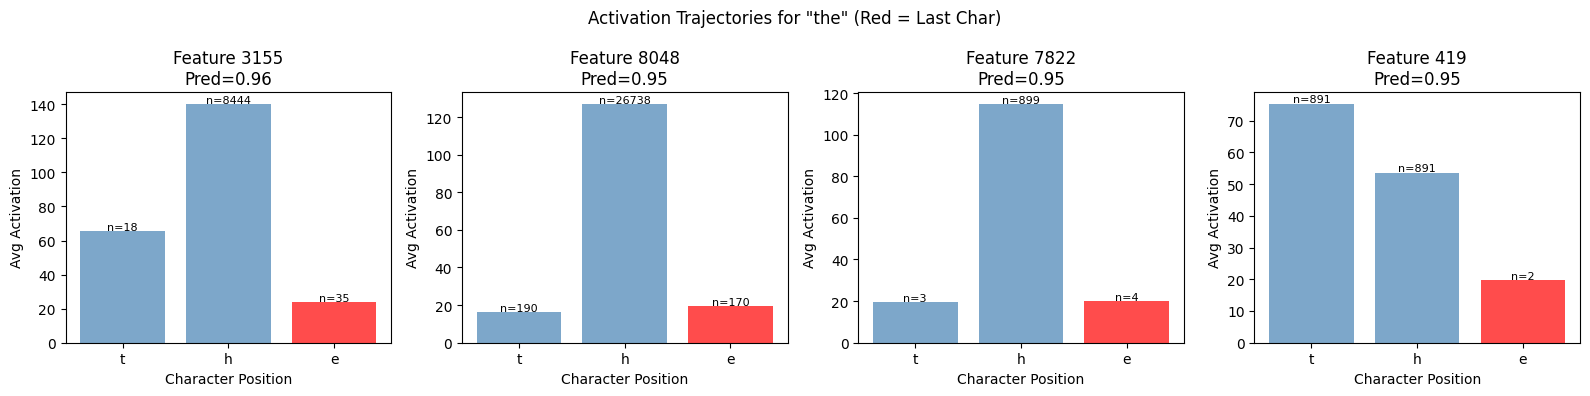

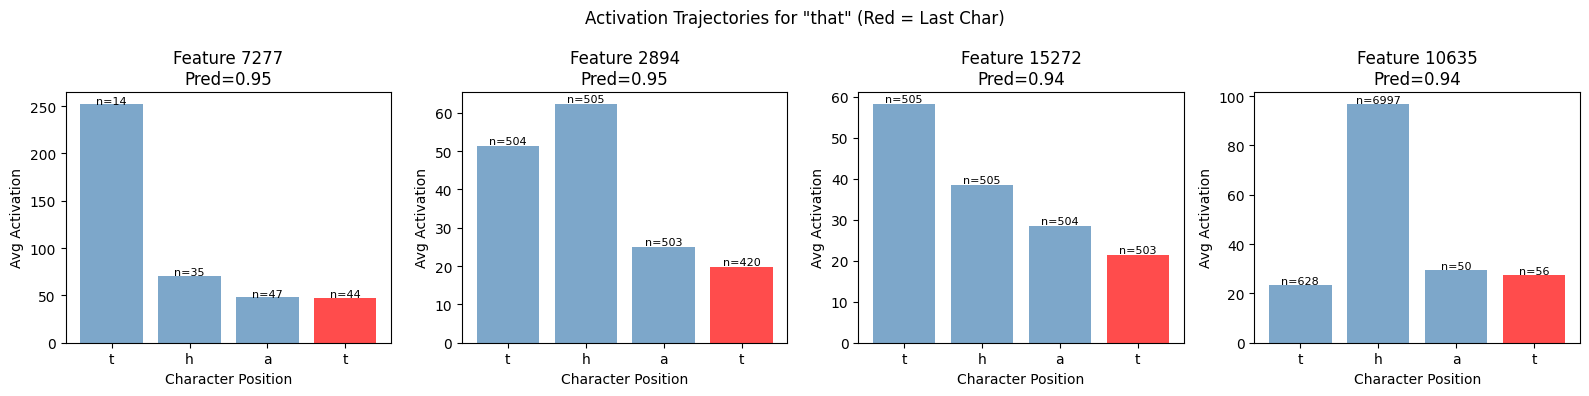

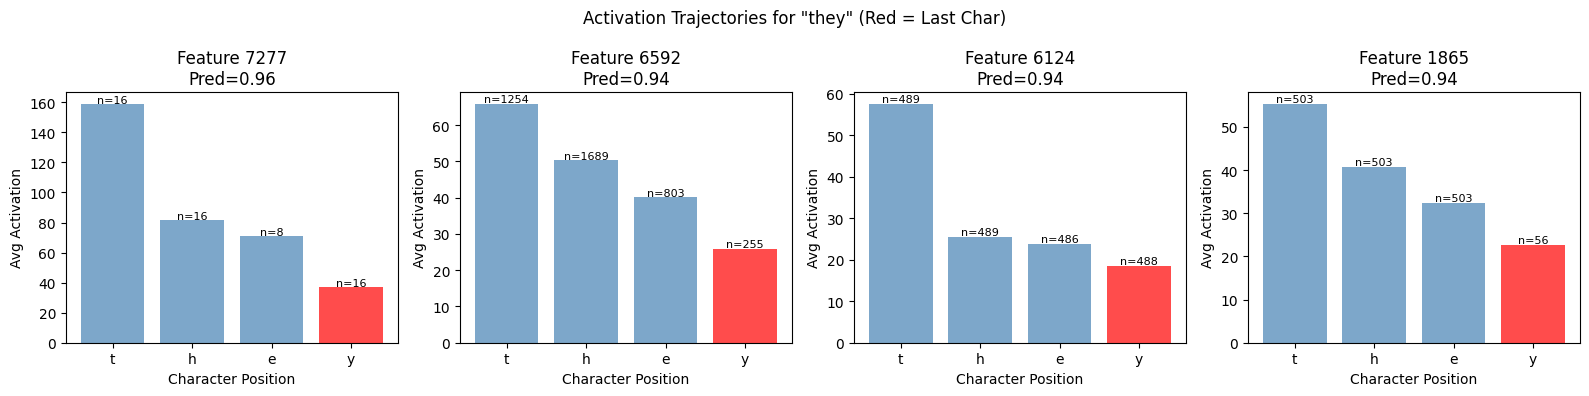

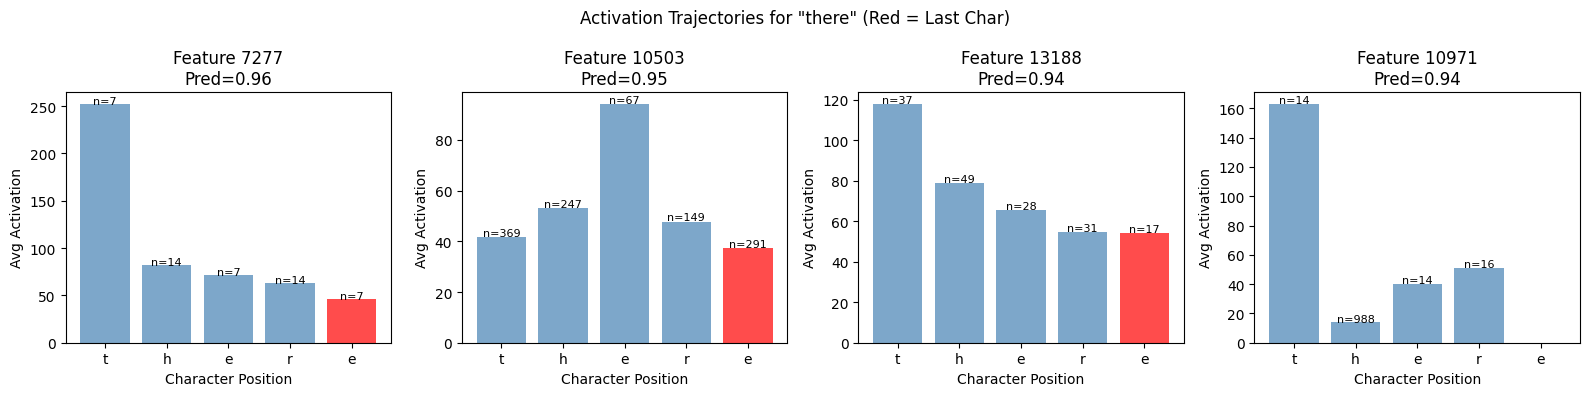


ANALYSIS 2: Prefix Disambiguation

Looking for features that distinguish words with shared prefixes...
(e.g., 'the' vs 'that' vs 'they' after seeing 'th')



Prefix analysis:   0%|          | 0/200 [00:00<?, ?it/s]


PREFIX DISAMBIGUATION RESULTS:
--------------------------------------------------------------------------------

[PREFIX 'th'] -> ['the', 'that', 'this', 'they', 'their', 'there', 'them', 'then']
  📍 Pos 0 (the:t/that:t/this:t): F4->they(1.00), F5->them(1.00), F7->their(1.00)
  📍 Pos 1 (the:h/that:h/this:h): F0->that(1.00), F3->they(1.00), F25->the(1.00)
     Pos 2 (the:e/that:a/this:i): F0->the(1.00), F25->that(1.00), F26->they(1.00)
     Pos 3 (the:-/that:t/this:s): F0->they(1.00), F7->that(1.00), F26->this(1.00)
     Pos 4 (the:-/that:-/this:-): F7680->their(1.00), F2051->there(1.00), F5637->their(1.00)

[PREFIX 'wh'] -> ['what', 'when', 'where', 'while', 'who', 'why']
  📍 Pos 0 (what:w/when:w/where:w): F2->when(1.00), F6148->why(1.00), F10245->when(1.00)
  📍 Pos 1 (what:h/when:h/where:h): F10242->when(1.00), F14338->while(1.00), F6148->why(1.00)
     Pos 2 (what:a/when:e/where:e): F12288->what(1.00), F10243->who(1.00), F4100->who(1.00)
     Pos 3 (what:t/when:n/where:r): F10245->w

Classifying:   0%|          | 0/200 [00:00<?, ?it/s]


FEATURE TYPE DISTRIBUTION:
----------------------------------------
  WORD_INTERNAL  :  6346 ( 48.3%)
  WORD_BOUNDARY  :  4645 ( 35.4%)
  NON_WORD       :  1450 ( 11.0%)
  MIXED          :   685 (  5.2%)

TOP WORD-INTERNAL FEATURES (Potential Word-Level Features!)

Feature  | Internal%  | Start%     | Mid%       | End%      
-------------------------------------------------------
12042    |     100.0% |       0.0% |     100.0% |       0.0%
8032     |     100.0% |       0.0% |     100.0% |       0.0%
1615     |     100.0% |       0.0% |     100.0% |       0.0%
12139    |     100.0% |       0.0% |     100.0% |       0.0%
10066    |     100.0% |       0.0% |     100.0% |       0.0%
12777    |     100.0% |       0.0% |     100.0% |       0.0%
10965    |     100.0% |       0.0% |     100.0% |       0.0%
4644     |     100.0% |       0.0% |     100.0% |       0.0%
12847    |     100.0% |       0.0% |     100.0% |       0.0%
3104     |     100.0% |       0.0% |     100.0% |       0.0%
5638  

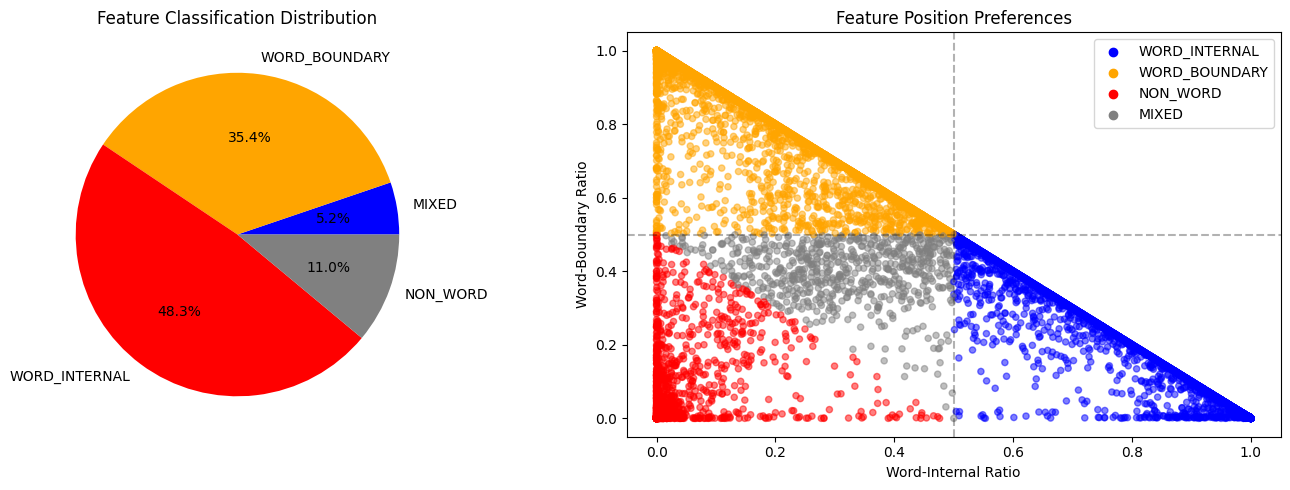


ANALYSIS COMPLETE!

KEY FINDINGS TO INTERPRET:

1. ACTIVATION TRAJECTORIES:
   - Features with high 'predictive_score' that activate early are evidence
     of word-level representations being used for prediction.
   - If a feature only activates at the last character, it's likely a 
     word-boundary marker, not a predictive word feature.

2. PREFIX DISAMBIGUATION:
   - Features that distinguish 'the' from 'that' AFTER seeing 'th' show
     the model is tracking word hypotheses.
   - Look for selective features at positions WITHIN the shared prefix.

3. FEATURE CLASSIFICATION:
   - A large population of WORD_INTERNAL features suggests word-level
     structure in the representations.
   - WORD_INTERNAL features are more likely to be true word-level features
     than WORD_BOUNDARY features.

NEXT STEPS:
- Deep dive into specific high-scoring features using logit lens
- Check if WORD_INTERNAL features are selective for specific words
- Compare features across different layers



In [ ]:
# =============================================================================
# WORD-LEVEL FEATURE ANALYSIS: Mid-Word Activation Patterns
# =============================================================================
#
# This analysis looks for features that activate THROUGHOUT words, not just
# at word boundaries. This is the right way to find predictive word features
# because the model needs word hypotheses DURING prediction.
#
# Run this cell after loading your model and SAE in your existing notebook.
# =============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re
from tqdm.auto import tqdm

# --- Configuration ---
LAYER_TO_PROBE = 4
POSITION_TO_PROBE = 'mid'
NUM_BATCHES = 200
MIN_WORD_LENGTH = 3
ACTIVATION_THRESHOLD = 1.0

# Target words and prefix groups for analysis
TARGET_WORDS = ['the', 'and', 'was', 'that', 'with', 'have', 'this',
                'from', 'they', 'there', 'their', 'would', 'could']

PREFIX_GROUPS = {
    'th': ['the', 'that', 'this', 'they', 'their', 'there', 'them', 'then', 'think'],
    'wh': ['what', 'when', 'where', 'which', 'while', 'who', 'why'],
    'ha': ['had', 'has', 'have', 'happy', 'hand', 'happened'],
    'sa': ['said', 'saw', 'same', 'sat'],
}

# --- Helper Functions ---
decoder_map = {i: chr(i) for i in range(256)}

def decode_str(tokens):
    return "".join([decoder_map.get(t.item() if hasattr(t, 'item') else t, '?') for t in tokens])

def get_word_positions(text):
    """Find all words and their character positions."""
    words = []
    for m in re.finditer(r'\b[a-zA-Z]+\b', text):
        word = m.group().lower()
        start = m.start()
        end = m.end() - 1
        words.append({
            'word': word,
            'start': start,
            'end': end,
            'length': len(word),
            'all_positions': list(range(start, end + 1)),
        })
    return words


# =============================================================================
# ANALYSIS 1: Activation Trajectories - How features evolve during word spelling
# =============================================================================

print("="*80)
print("ANALYSIS 1: Activation Trajectories Throughout Words")
print("="*80)
print("\nTracking how features activate at each character position within words...")
print("(A true word-level feature should activate EARLY, not just at the end)\n")

# Storage: word -> char_position -> feature_id -> list of activations
trajectories = {word: defaultdict(lambda: defaultdict(list)) for word in TARGET_WORDS}

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES, desc="Scanning")):
        if batch_idx >= NUM_BATCHES:
            break

        x = x.to(DEVICE)
        out = model(x, return_residuals=True, layers_to_capture=[LAYER_TO_PROBE])
        acts = out['residuals'][f'layer_{LAYER_TO_PROBE}'][POSITION_TO_PROBE]

        for b in range(x.shape[0]):
            text = decode_str(x[b])
            word_info_list = get_word_positions(text)

            _, topk_ind, topk_val = sae.encode(acts[b])
            topk_ind = topk_ind.cpu().numpy()
            topk_val = topk_val.cpu().numpy()

            for word_info in word_info_list:
                word = word_info['word']

                if word not in TARGET_WORDS or word_info['length'] < MIN_WORD_LENGTH:
                    continue

                for char_idx in range(word_info['length']):
                    abs_pos = word_info['start'] + char_idx

                    if abs_pos >= config.context_length:
                        continue

                    active_feats = topk_ind[abs_pos]
                    active_vals = topk_val[abs_pos]

                    for fid, val in zip(active_feats, active_vals):
                        if val > ACTIVATION_THRESHOLD:
                            trajectories[word][char_idx][fid].append(val)

# Analyze trajectories to find PREDICTIVE features
print("\n" + "="*80)
print("PREDICTIVE WORD FEATURES (activate early in words)")
print("="*80)

predictive_features = {}

for word in TARGET_WORDS:
    char_data = trajectories[word]
    word_len = len(word)

    if not char_data:
        continue

    all_features = set()
    for feat_data in char_data.values():
        all_features.update(feat_data.keys())

    feature_scores = {}

    for fid in all_features:
        activations_by_pos = []
        counts_by_pos = []

        for char_idx in range(word_len):
            if fid in char_data[char_idx]:
                acts = char_data[char_idx][fid]
                activations_by_pos.append(np.mean(acts))
                counts_by_pos.append(len(acts))
            else:
                activations_by_pos.append(0)
                counts_by_pos.append(0)

        total_count = sum(counts_by_pos)
        if total_count < 10:
            continue

        # Early activation score
        early_mass = sum(activations_by_pos[:-1]) if len(activations_by_pos) > 1 else 0
        total_mass = sum(activations_by_pos)
        early_ratio = early_mass / max(total_mass, 1e-6)

        # Consistency across positions
        positions_active = sum(1 for a in activations_by_pos if a > 0)
        consistency = positions_active / word_len

        # Early onset
        first_active = next((i for i, a in enumerate(activations_by_pos) if a > 0), word_len)
        early_onset = 1 - (first_active / word_len)

        # Combined predictive score
        predictive_score = 0.4 * early_ratio + 0.3 * consistency + 0.3 * early_onset

        feature_scores[fid] = {
            'predictive_score': predictive_score,
            'early_ratio': early_ratio,
            'consistency': consistency,
            'early_onset': early_onset,
            'total_count': total_count,
            'activation_pattern': activations_by_pos,
            'count_pattern': counts_by_pos,
        }

    predictive_features[word] = feature_scores

# Print results
print("\n{:<12} | {:<8} | {:<60}".format("WORD", "LENGTH", "TOP PREDICTIVE FEATURES"))
print("-" * 85)

for word in TARGET_WORDS:
    if word not in predictive_features or not predictive_features[word]:
        continue

    sorted_feats = sorted(
        predictive_features[word].items(),
        key=lambda x: x[1]['predictive_score'],
        reverse=True
    )[:3]

    feats_str = ", ".join([
        f"F{fid}(pred={s['predictive_score']:.2f}, early={s['early_ratio']:.2f})"
        for fid, s in sorted_feats
    ])
    print(f"{word:<12} | {len(word):<8} | {feats_str}")


# =============================================================================
# Visualize activation trajectories
# =============================================================================

print("\n" + "="*80)
print("VISUALIZATION: Activation Trajectories")
print("="*80)

words_to_plot = ['the', 'that', 'they', 'there'][:4]  # Adjust as needed

for word in words_to_plot:
    if word not in predictive_features or not predictive_features[word]:
        continue

    # Get top 4 features by predictive score
    sorted_feats = sorted(
        predictive_features[word].items(),
        key=lambda x: x[1]['predictive_score'],
        reverse=True
    )[:4]

    if not sorted_feats:
        continue

    fig, axes = plt.subplots(1, len(sorted_feats), figsize=(4*len(sorted_feats), 4))
    if len(sorted_feats) == 1:
        axes = [axes]

    for ax, (fid, scores) in zip(axes, sorted_feats):
        pattern = scores['activation_pattern']
        counts = scores['count_pattern']

        x = range(len(pattern))
        colors = ['red' if i == len(pattern)-1 else 'steelblue' for i in x]

        bars = ax.bar(x, pattern, color=colors, alpha=0.7)

        for i, (p, c) in enumerate(zip(pattern, counts)):
            if c > 0:
                ax.text(i, p + 0.5, f'n={c}', ha='center', fontsize=8)

        ax.set_xlabel('Character Position')
        ax.set_ylabel('Avg Activation')
        ax.set_title(f'Feature {fid}\nPred={scores["predictive_score"]:.2f}')
        ax.set_xticks(x)
        ax.set_xticklabels(list(word[:len(pattern)]))

    plt.suptitle(f'Activation Trajectories for "{word}" (Red = Last Char)', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/trajectory_{word}.png', dpi=150)
    plt.show()


# =============================================================================
# ANALYSIS 2: Prefix Disambiguation - Do features distinguish words early?
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS 2: Prefix Disambiguation")
print("="*80)
print("\nLooking for features that distinguish words with shared prefixes...")
print("(e.g., 'the' vs 'that' vs 'they' after seeing 'th')\n")

# Collect features for prefix analysis
word_features = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
all_prefix_words = set()
for words in PREFIX_GROUPS.values():
    all_prefix_words.update(w.lower() for w in words)

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES, desc="Prefix analysis")):
        if batch_idx >= NUM_BATCHES:
            break

        x = x.to(DEVICE)
        out = model(x, return_residuals=True, layers_to_capture=[LAYER_TO_PROBE])
        acts = out['residuals'][f'layer_{LAYER_TO_PROBE}'][POSITION_TO_PROBE]

        for b in range(x.shape[0]):
            text = decode_str(x[b])
            word_info_list = get_word_positions(text)

            _, topk_ind, topk_val = sae.encode(acts[b])
            topk_ind = topk_ind.cpu().numpy()
            topk_val = topk_val.cpu().numpy()

            for word_info in word_info_list:
                word = word_info['word']
                if word not in all_prefix_words:
                    continue

                for char_idx in range(word_info['length']):
                    abs_pos = word_info['start'] + char_idx
                    if abs_pos >= config.context_length:
                        continue

                    for fid, val in zip(topk_ind[abs_pos], topk_val[abs_pos]):
                        if val > ACTIVATION_THRESHOLD:
                            word_features[word][char_idx][fid].append(val)

# Analyze disambiguation
print("\nPREFIX DISAMBIGUATION RESULTS:")
print("-" * 80)

for prefix, words in PREFIX_GROUPS.items():
    words_found = [w for w in words if w.lower() in word_features]

    if len(words_found) < 2:
        continue

    print(f"\n[PREFIX '{prefix}'] -> {words_found}")

    prefix_len = len(prefix)
    max_word_len = max(len(w) for w in words_found)

    for pos in range(max_word_len):
        word_feat_avgs = {}

        for word in words_found:
            if pos in word_features[word.lower()]:
                feat_data = word_features[word.lower()][pos]
                word_feat_avgs[word] = {f: np.mean(v) for f, v in feat_data.items()}
            else:
                word_feat_avgs[word] = {}

        # Find selective features
        all_feats = set()
        for avgs in word_feat_avgs.values():
            all_feats.update(avgs.keys())

        selective = []
        for feat in all_feats:
            activations = {w: word_feat_avgs[w].get(feat, 0) for w in words_found}
            max_act = max(activations.values())
            min_act = min(activations.values())

            if max_act > 0:
                selectivity = (max_act - min_act) / max_act
                best_word = max(activations, key=activations.get)

                if selectivity > 0.6:
                    selective.append((feat, best_word, selectivity))

        if selective:
            within_prefix = "📍" if pos < prefix_len else "  "
            char_at_pos = {w: w[pos] if pos < len(w) else '-' for w in words_found}
            chars_str = "/".join([f"{w}:{char_at_pos[w]}" for w in words_found[:3]])

            selective.sort(key=lambda x: -x[2])
            feats_str = ", ".join([f"F{f}->{w}({s:.2f})" for f, w, s in selective[:3]])

            print(f"  {within_prefix} Pos {pos} ({chars_str}): {feats_str}")


# =============================================================================
# ANALYSIS 3: Feature Type Classification
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS 3: Feature Type Classification")
print("="*80)
print("\nClassifying features by WHERE they fire (mid-word vs boundary vs non-word)...\n")

feature_positions = defaultdict(lambda: {
    'word_start': 0, 'word_mid': 0, 'word_end': 0, 'non_word': 0,
    'total_activation': 0.0, 'examples': []
})

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES, desc="Classifying")):
        if batch_idx >= NUM_BATCHES:
            break

        x = x.to(DEVICE)
        out = model(x, return_residuals=True, layers_to_capture=[LAYER_TO_PROBE])
        acts = out['residuals'][f'layer_{LAYER_TO_PROBE}'][POSITION_TO_PROBE]

        for b in range(x.shape[0]):
            text = decode_str(x[b])
            word_info_list = get_word_positions(text)

            pos_type = {}
            for word_info in word_info_list:
                for i, abs_pos in enumerate(word_info['all_positions']):
                    if i == 0:
                        pos_type[abs_pos] = 'word_start'
                    elif i == word_info['length'] - 1:
                        pos_type[abs_pos] = 'word_end'
                    else:
                        pos_type[abs_pos] = 'word_mid'

            _, topk_ind, topk_val = sae.encode(acts[b])
            topk_ind = topk_ind.cpu().numpy()
            topk_val = topk_val.cpu().numpy()

            for t in range(min(len(text), config.context_length)):
                ptype = pos_type.get(t, 'non_word')

                for fid, val in zip(topk_ind[t], topk_val[t]):
                    if val > ACTIVATION_THRESHOLD:
                        feature_positions[fid][ptype] += 1
                        feature_positions[fid]['total_activation'] += val

# Classify features
classifications = {}

for fid, counts in feature_positions.items():
    total = sum(counts[k] for k in ['word_start', 'word_mid', 'word_end', 'non_word'])

    if total < 20:
        continue

    internal_ratio = counts['word_mid'] / total
    boundary_ratio = (counts['word_start'] + counts['word_end']) / total

    if internal_ratio > 0.5:
        category = 'WORD_INTERNAL'
    elif boundary_ratio > 0.5:
        category = 'WORD_BOUNDARY'
    elif counts['non_word'] / total > 0.5:
        category = 'NON_WORD'
    else:
        category = 'MIXED'

    classifications[fid] = {
        'category': category,
        'internal_ratio': internal_ratio,
        'boundary_ratio': boundary_ratio,
        'start_ratio': counts['word_start'] / total,
        'mid_ratio': counts['word_mid'] / total,
        'end_ratio': counts['word_end'] / total,
        'total_firings': total,
    }

# Summary
category_counts = Counter(c['category'] for c in classifications.values())

print("\nFEATURE TYPE DISTRIBUTION:")
print("-" * 40)
for cat, count in sorted(category_counts.items(), key=lambda x: -x[1]):
    pct = 100 * count / len(classifications)
    print(f"  {cat:<15}: {count:5d} ({pct:5.1f}%)")

# Find most "word-internal" features (potential word-level features!)
print("\n" + "="*80)
print("TOP WORD-INTERNAL FEATURES (Potential Word-Level Features!)")
print("="*80)

word_internal = [(fid, data) for fid, data in classifications.items()
                 if data['category'] == 'WORD_INTERNAL' and data['total_firings'] > 50]
word_internal.sort(key=lambda x: -x[1]['internal_ratio'])

print("\n{:<8} | {:<10} | {:<10} | {:<10} | {:<10}".format(
    "Feature", "Internal%", "Start%", "Mid%", "End%"))
print("-" * 55)

for fid, data in word_internal[:20]:
    print("{:<8} | {:>9.1f}% | {:>9.1f}% | {:>9.1f}% | {:>9.1f}%".format(
        fid,
        data['internal_ratio'] * 100,
        data['start_ratio'] * 100,
        data['mid_ratio'] * 100,
        data['end_ratio'] * 100
    ))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax1 = axes[0]
labels = list(category_counts.keys())
sizes = list(category_counts.values())
colors_pie = ['blue', 'orange', 'red', 'gray']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_pie[:len(labels)])
ax1.set_title('Feature Classification Distribution')

# Scatter plot
ax2 = axes[1]
internal = [c['internal_ratio'] for c in classifications.values()]
boundary = [c['boundary_ratio'] for c in classifications.values()]
categories = [c['category'] for c in classifications.values()]

colors_map = {'WORD_INTERNAL': 'blue', 'WORD_BOUNDARY': 'orange', 'NON_WORD': 'red', 'MIXED': 'gray'}
c = [colors_map.get(cat, 'gray') for cat in categories]

ax2.scatter(internal, boundary, c=c, alpha=0.5, s=20)
ax2.set_xlabel('Word-Internal Ratio')
ax2.set_ylabel('Word-Boundary Ratio')
ax2.set_title('Feature Position Preferences')
ax2.axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
ax2.axvline(x=0.5, color='k', linestyle='--', alpha=0.3)

handles = [plt.scatter([], [], c=colors_map[cat], label=cat) for cat in colors_map]
ax2.legend(handles=handles, labels=list(colors_map.keys()))

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/feature_classification.png', dpi=150)
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("""
KEY FINDINGS TO INTERPRET:

1. ACTIVATION TRAJECTORIES:
   - Features with high 'predictive_score' that activate early are evidence
     of word-level representations being used for prediction.
   - If a feature only activates at the last character, it's likely a
     word-boundary marker, not a predictive word feature.

2. PREFIX DISAMBIGUATION:
   - Features that distinguish 'the' from 'that' AFTER seeing 'th' show
     the model is tracking word hypotheses.
   - Look for selective features at positions WITHIN the shared prefix.

3. FEATURE CLASSIFICATION:
   - A large population of WORD_INTERNAL features suggests word-level
     structure in the representations.
   - WORD_INTERNAL features are more likely to be true word-level features
     than WORD_BOUNDARY features.

NEXT STEPS:
- Deep dive into specific high-scoring features using logit lens
- Check if WORD_INTERNAL features are selective for specific words
- Compare features across different layers
""")

# Mid Word Feature Probing


╔══════════════════════════════════════════════════════════════════════════════╗
║              SELECTIVE MID-WORD FEATURE ANALYSIS                             ║
║                                                                              ║
║  Finding features with SPIKY word distributions:                             ║
║  - Fire strongly for specific words                                          ║
║  - Don't fire broadly across all words                                       ║
║  - Focus on MID-WORD positions (not start/end)                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

SELECTIVE MID-WORD FEATURE ANALYSIS

Goal: Find features with SPIKY word distributions
      (fire strongly for specific words, not broadly)

STEP 1: Collecting feature-word distributions
------------------------------------------------------------
Layer: 4, Position: mid




Collection complete:
  Total features with firings: 16338
  Total unique words: 2828
  Features with word associations: 16196

STEP 2: Analyzing feature selectivity
------------------------------------------------------------
Analyzing feature selectivity...


Analyzing features:   0%|          | 0/16196 [00:00<?, ?it/s]


Analysis complete:
  Features analyzed: 15997
  Selective features: 3890

RESULTS: MOST SELECTIVE MID-WORD FEATURES

Found 3890 selective features (out of 15997 analyzed)

Criteria: Gini >= 0.5, Top-1 >= 0.15, Entropy ratio <= 0.5

----------------------------------------------------------------------------------------------------
Feature    | Gini   | Top1%  | EffVocab | Top Words                                         
----------------------------------------------------------------------------------------------------
15786      | 0.967  | 64.5%  | 3.7      | little(65%), time(22%), amy(2%)                   
1966       | 0.961  | 84.8%  | 2.1      | little(85%), things(6%), this(3%)                 
7149       | 0.956  | 73.3%  | 3.0      | little(73%), thought(13%), daughter(4%)           
9313       | 0.955  | 92.5%  | 1.5      | little(92%), hugged(4%), strong(1%)               
11521      | 0.955  | 74.0%  | 3.3      | little(74%), license(10%), normal(3%)             
7309   

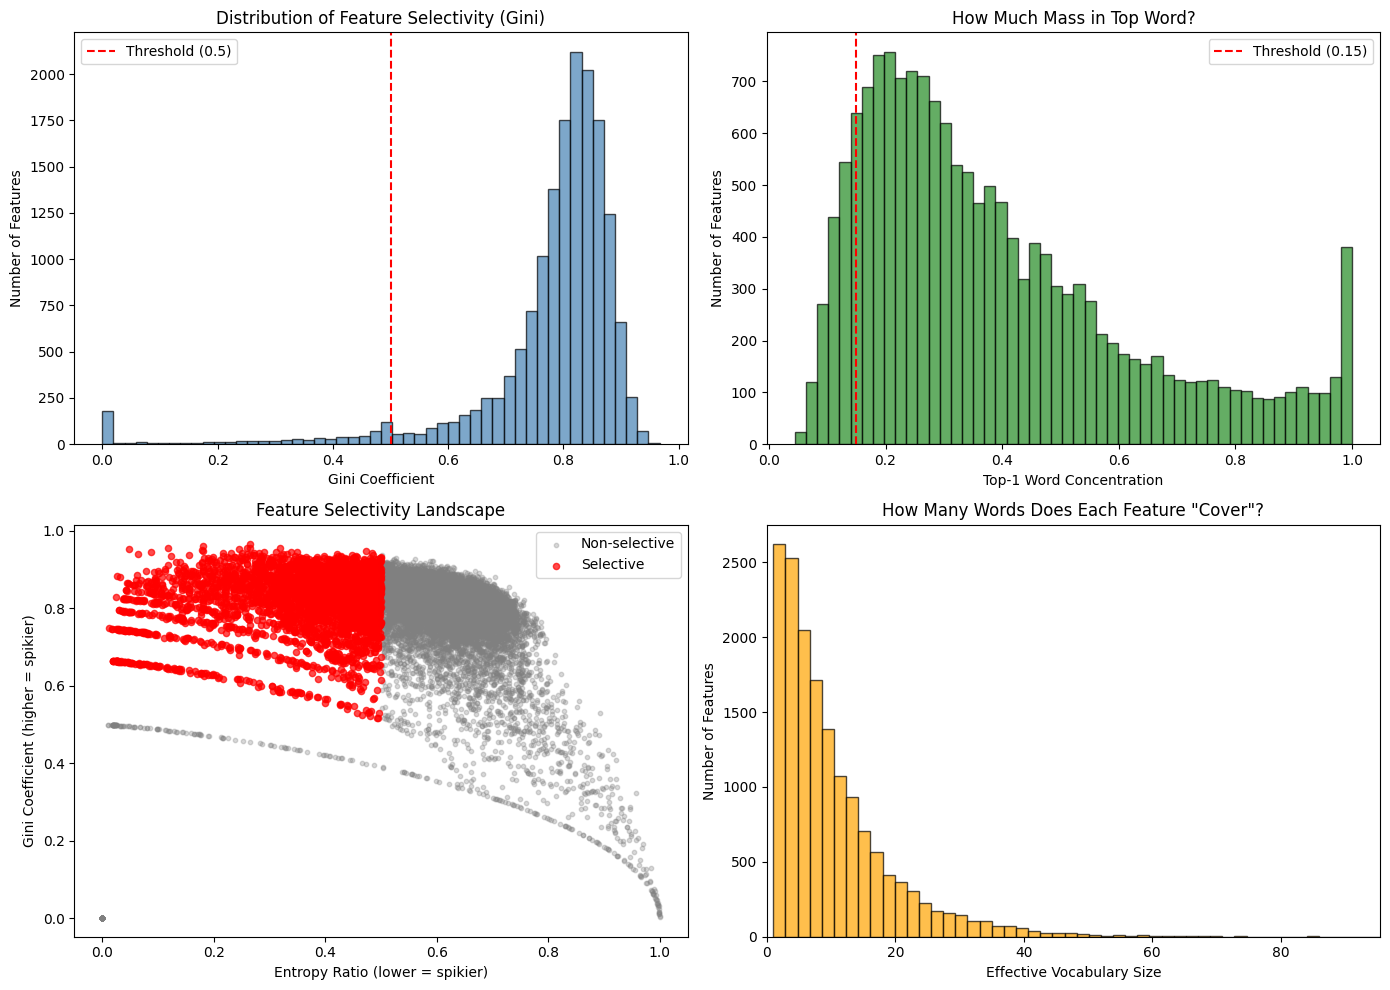


Plotting top selective features...


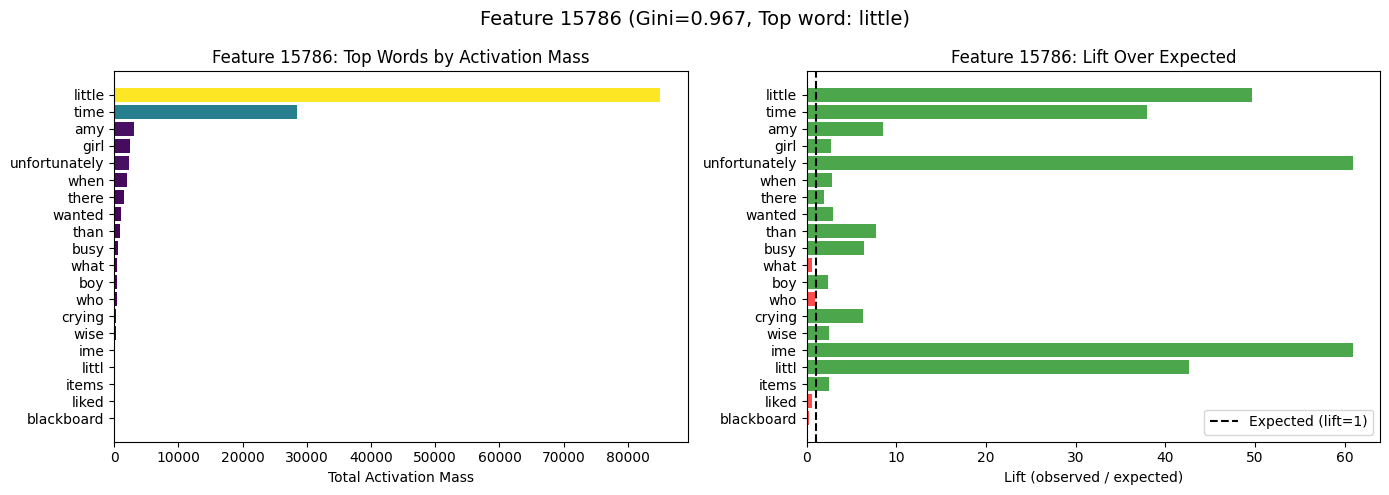

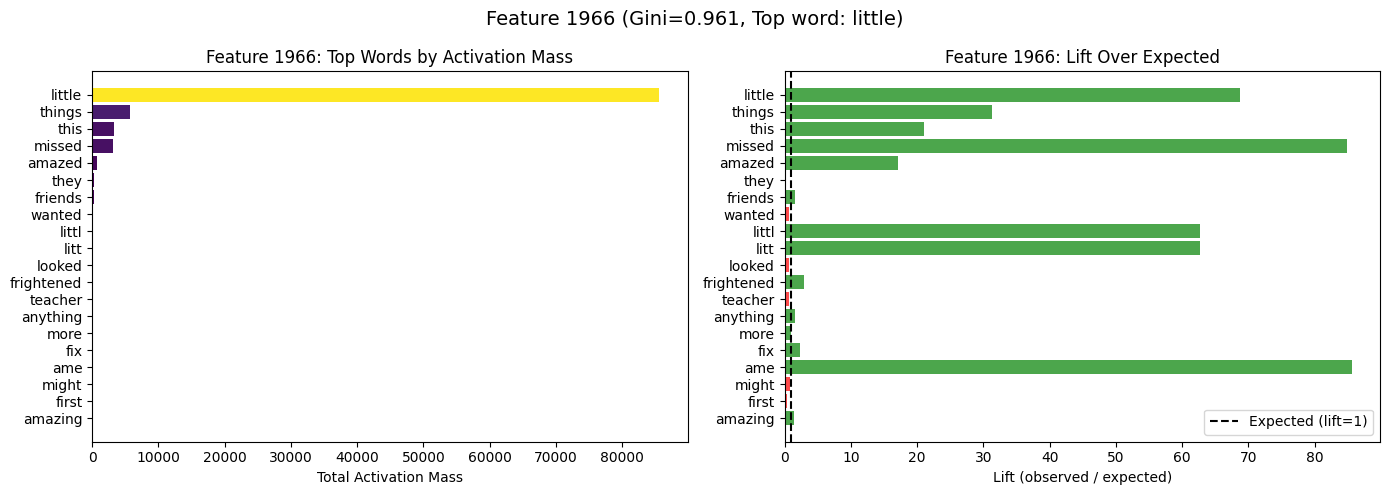

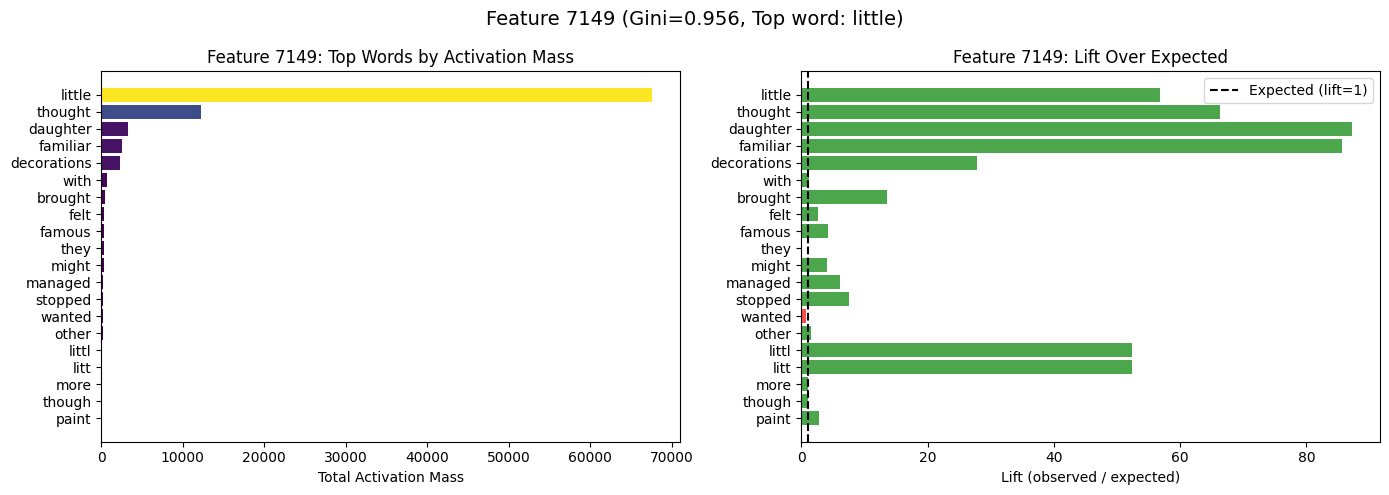

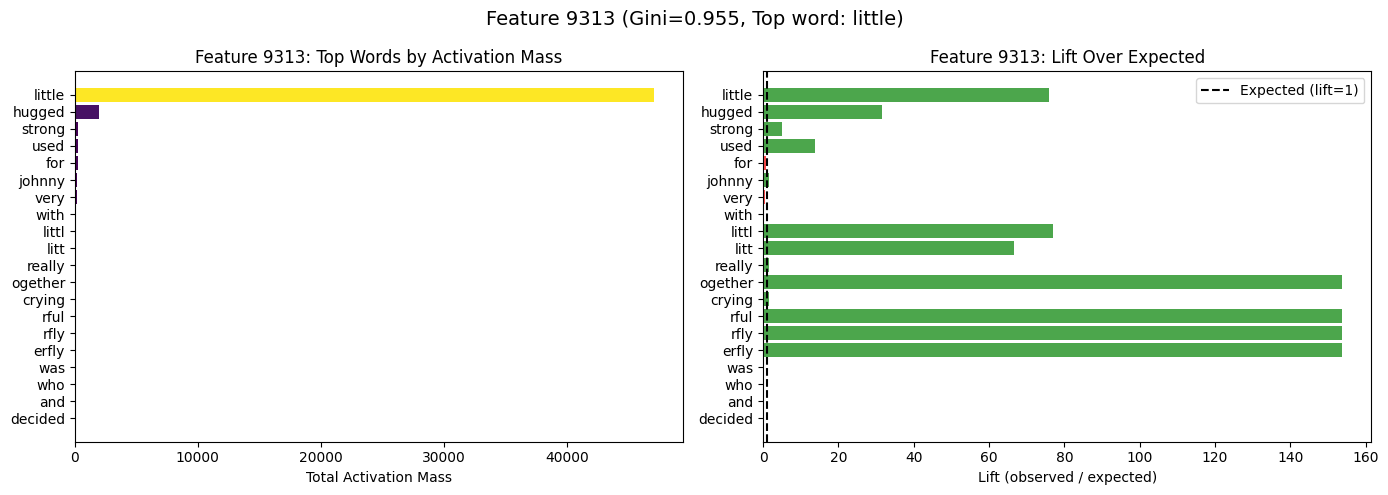

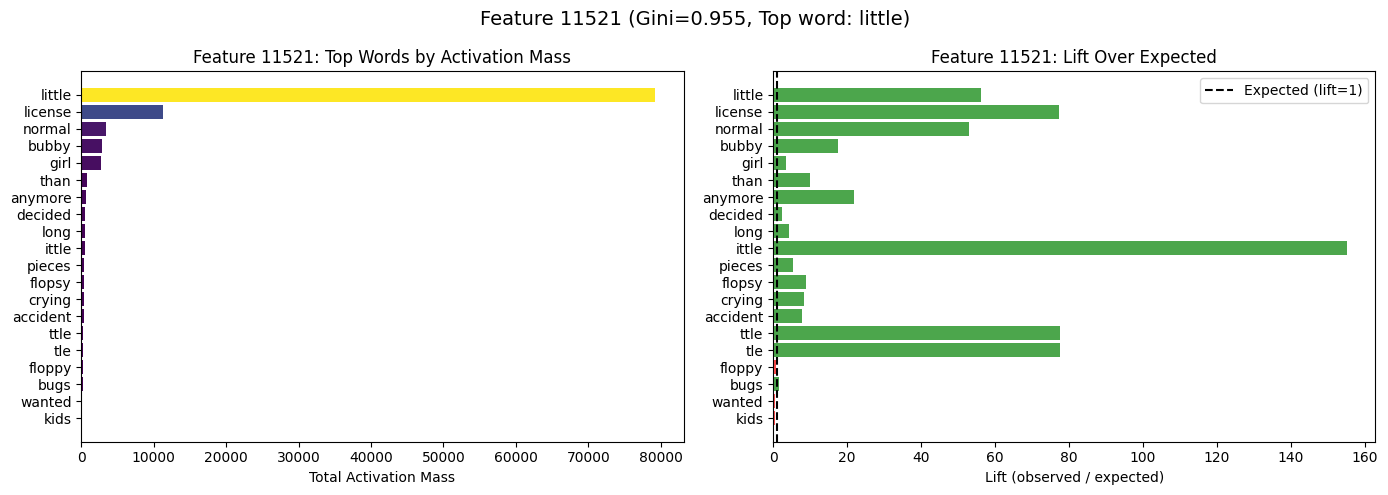


SUMMARY DATA STRUCTURE

Created selective_midword_features dict with 526 words
Use this for causal intervention experiments!

Example usage:
  features_for_word = selective_midword_features['happy']
  top_feature = features_for_word[0]['feature_id']

Results saved to /content/drive/MyDrive/char_gpt_sae/selective_midword_features.pt

╔══════════════════════════════════════════════════════════════════════════════╗
║                         ANALYSIS COMPLETE                                     ║
╚══════════════════════════════════════════════════════════════════════════════╝

KEY OUTPUTS:
1. selective_midword_features: Dict mapping words to their selective features
   Usage: selective_midword_features['happy'] -> list of feature dicts

2. df_selective_features: DataFrame of all selective features with metrics

3. Saved plots showing:
   - Overall selectivity distribution
   - Word distributions for top selective features

NEXT STEPS:
1. Use selective_midword_features in causal interventi

In [ ]:
# =============================================================================
# SELECTIVE MID-WORD FEATURE ANALYSIS
# =============================================================================
#
# This analysis finds SAE features that have SPIKY word distributions:
# - Fire strongly for a few specific words
# - Don't fire broadly across all words
#
# Key insight: Instead of asking "what features represent word X?", we ask
# "what words does feature F represent?" and look for selective features.
#
# This handles the common-prefix problem: features firing on "th" will show
# up for "the", "that", "they", etc., but truly word-level features should
# be selective for specific words even when they share prefixes.
# =============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from scipy import stats
from scipy.stats import entropy
import re
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import pandas as pd

# =============================================================================
# CONFIGURATION
# =============================================================================

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LAYER_TO_PROBE = 4
POSITION_TO_PROBE = 'mid'

# Data collection parameters
NUM_BATCHES = 500           # More batches = better statistics
MIN_FEATURE_FIRINGS = 50    # Minimum total firings for a feature to be analyzed
MIN_WORD_OCCURRENCES = 20   # Minimum times we need to see a word
ACTIVATION_THRESHOLD = 1.0  # Minimum activation to count as "firing"

# Selectivity parameters
TOP_N_WORDS_PER_FEATURE = 20    # Consider top N words for each feature
MIN_WORD_LENGTH = 3              # Skip very short words
MAX_WORDS_TO_TRACK = 5000        # Vocabulary size limit

# Spikiness thresholds
MIN_GINI_COEFFICIENT = 0.5       # Minimum Gini for "spiky" distribution
MIN_TOP1_CONCENTRATION = 0.15    # Top word must have at least 15% of feature's mass
MAX_ENTROPY_RATIO = 0.5          # Entropy must be < 50% of max possible entropy

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

decoder_map = {i: chr(i) for i in range(256)}

def decode_str(tokens) -> str:
    """Convert token tensor to string."""
    if isinstance(tokens, torch.Tensor):
        tokens = tokens.cpu().tolist()
    return bytes(tokens).decode('utf-8', errors='replace')

def get_word_positions(text: str) -> List[Dict]:
    """Find all words and their character positions."""
    words = []
    for m in re.finditer(r'\b[a-zA-Z]+\b', text):
        word = m.group().lower()
        if len(word) >= MIN_WORD_LENGTH:
            words.append({
                'word': word,
                'start': m.start(),
                'end': m.end() - 1,
                'length': len(word),
                'mid_positions': list(range(m.start() + 1, m.end() - 1)) if len(word) > 2 else [],
            })
    return words


def calculate_gini(values: np.ndarray) -> float:
    """
    Calculate Gini coefficient of a distribution.

    Gini = 0: perfect equality (uniform distribution)
    Gini = 1: perfect inequality (all mass on one item)

    Higher Gini = spikier distribution = more selective feature
    """
    if len(values) == 0 or np.sum(values) == 0:
        return 0.0

    values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(values)

    return (2 * np.sum((np.arange(1, n + 1) * values)) - (n + 1) * np.sum(values)) / (n * np.sum(values))


def calculate_spikiness_metrics(word_counts: Dict[str, int], word_masses: Dict[str, float]) -> Dict:
    """
    Calculate multiple metrics for how "spiky" a feature's word distribution is.

    Returns dict with:
    - gini: Gini coefficient (higher = spikier)
    - entropy: Shannon entropy (lower = spikier)
    - entropy_ratio: entropy / max_entropy (lower = spikier)
    - top1_concentration: fraction of mass in top word
    - top3_concentration: fraction of mass in top 3 words
    - effective_vocab_size: approximate number of "active" words
    """

    if not word_masses:
        return None

    # Get mass values
    masses = np.array(list(word_masses.values()))
    total_mass = masses.sum()

    if total_mass == 0:
        return None

    # Normalize to get probability distribution
    probs = masses / total_mass

    # Sort by mass (descending)
    sorted_probs = np.sort(probs)[::-1]
    sorted_words = sorted(word_masses.keys(), key=lambda w: word_masses[w], reverse=True)

    # Gini coefficient
    gini = calculate_gini(masses)

    # Shannon entropy
    probs_nonzero = probs[probs > 0]
    ent = entropy(probs_nonzero, base=2)
    max_entropy = np.log2(len(probs_nonzero))
    entropy_ratio = ent / max_entropy if max_entropy > 0 else 0

    # Concentration metrics
    top1_concentration = sorted_probs[0] if len(sorted_probs) > 0 else 0
    top3_concentration = sorted_probs[:3].sum() if len(sorted_probs) >= 3 else sorted_probs.sum()
    top5_concentration = sorted_probs[:5].sum() if len(sorted_probs) >= 5 else sorted_probs.sum()

    # Effective vocabulary size (using entropy-based estimate)
    effective_vocab = 2 ** ent if ent > 0 else 1

    return {
        'gini': gini,
        'entropy': ent,
        'max_entropy': max_entropy,
        'entropy_ratio': entropy_ratio,
        'top1_concentration': top1_concentration,
        'top3_concentration': top3_concentration,
        'top5_concentration': top5_concentration,
        'effective_vocab_size': effective_vocab,
        'total_mass': total_mass,
        'num_words': len(word_masses),
        'top_words': sorted_words[:10],
        'top_probs': sorted_probs[:10].tolist(),
    }


# =============================================================================
# MAIN DATA COLLECTION
# =============================================================================

def collect_feature_word_distributions(
    model,
    sae,
    data_loader,
    config,
    num_batches: int = 500,
    layer_idx: int = 4,
    position: str = 'mid',
) -> Tuple[Dict, Dict, Counter]:
    """
    Collect word distributions for each SAE feature.

    For each feature, track:
    - Which words it fires on (mid-word positions only)
    - How strongly it fires (activation mass)
    - How often it fires (count)

    Returns:
    - feature_word_counts: {fid: {word: count}}
    - feature_word_masses: {fid: {word: total_activation}}
    - word_occurrences: Counter of word occurrences in data
    """

    print(f"Collecting feature-word distributions over {num_batches} batches...")
    print(f"Layer: {layer_idx}, Position: {position}")
    print()

    # Storage structures
    # feature_word_counts[fid][word] = number of times feature fired on this word
    feature_word_counts = defaultdict(lambda: defaultdict(int))
    # feature_word_masses[fid][word] = sum of activations when firing on this word
    feature_word_masses = defaultdict(lambda: defaultdict(float))
    # Total firings for each feature (for normalization)
    feature_total_firings = defaultdict(int)
    feature_total_mass = defaultdict(float)
    # Word occurrence counts
    word_occurrences = Counter()

    model.eval()
    sae.eval()

    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(tqdm(data_loader, total=num_batches,
                                                  desc="Collecting distributions")):
            if batch_idx >= num_batches:
                break

            x = x.to(DEVICE)

            # Get GPT activations
            out = model(x, return_residuals=True, layers_to_capture=[layer_idx])
            acts = out['residuals'][f'layer_{layer_idx}'][position]  # [B, T, D]

            # Process each sequence
            for b in range(x.shape[0]):
                text = decode_str(x[b])
                word_info_list = get_word_positions(text)

                # Build position -> word mapping (MID-WORD positions only!)
                pos_to_word = {}
                for word_info in word_info_list:
                    word = word_info['word']
                    word_occurrences[word] += 1

                    # Only map MID positions (not first or last character)
                    for pos in word_info['mid_positions']:
                        if pos < config.context_length:
                            pos_to_word[pos] = word

                # Get SAE activations
                _, topk_ind, topk_val = sae.encode(acts[b])
                topk_ind = topk_ind.cpu().numpy()
                topk_val = topk_val.cpu().numpy()

                # Record feature-word associations
                for t in range(topk_ind.shape[0]):
                    for fid, val in zip(topk_ind[t], topk_val[t]):
                        if val > ACTIVATION_THRESHOLD:
                            feature_total_firings[fid] += 1
                            feature_total_mass[fid] += val

                            # If this is a mid-word position, record the word
                            if t in pos_to_word:
                                word = pos_to_word[t]
                                feature_word_counts[fid][word] += 1
                                feature_word_masses[fid][word] += val

    print(f"\nCollection complete:")
    print(f"  Total features with firings: {len(feature_total_firings)}")
    print(f"  Total unique words: {len(word_occurrences)}")
    print(f"  Features with word associations: {len(feature_word_counts)}")

    return (dict(feature_word_counts), dict(feature_word_masses),
            word_occurrences, dict(feature_total_firings), dict(feature_total_mass))


# =============================================================================
# ANALYSIS: FIND SPIKY FEATURES
# =============================================================================

def analyze_feature_selectivity(
    feature_word_counts: Dict,
    feature_word_masses: Dict,
    word_occurrences: Counter,
    feature_total_firings: Dict,
    feature_total_mass: Dict,
    min_firings: int = 50,
) -> pd.DataFrame:
    """
    Analyze each feature's word distribution and calculate selectivity metrics.

    Returns DataFrame with one row per feature, including:
    - Spikiness metrics (Gini, entropy, concentration)
    - Top words for the feature
    - Whether it qualifies as "selective"
    """

    print("Analyzing feature selectivity...")

    results = []

    for fid in tqdm(feature_word_counts.keys(), desc="Analyzing features"):
        # Filter by minimum firings
        if feature_total_firings.get(fid, 0) < min_firings:
            continue

        word_counts = feature_word_counts[fid]
        word_masses = feature_word_masses[fid]

        if not word_masses:
            continue

        # Calculate spikiness metrics
        metrics = calculate_spikiness_metrics(word_counts, word_masses)

        if metrics is None:
            continue

        # Calculate what fraction of feature's firings are on mid-word positions
        total_firings = feature_total_firings.get(fid, 0)
        midword_firings = sum(word_counts.values())
        midword_ratio = midword_firings / total_firings if total_firings > 0 else 0

        # Determine if feature is "selective" based on multiple criteria
        is_selective = (
            metrics['gini'] >= MIN_GINI_COEFFICIENT and
            metrics['top1_concentration'] >= MIN_TOP1_CONCENTRATION and
            metrics['entropy_ratio'] <= MAX_ENTROPY_RATIO
        )

        results.append({
            'feature_id': fid,
            'gini': metrics['gini'],
            'entropy': metrics['entropy'],
            'entropy_ratio': metrics['entropy_ratio'],
            'top1_concentration': metrics['top1_concentration'],
            'top3_concentration': metrics['top3_concentration'],
            'top5_concentration': metrics['top5_concentration'],
            'effective_vocab_size': metrics['effective_vocab_size'],
            'total_firings': total_firings,
            'midword_firings': midword_firings,
            'midword_ratio': midword_ratio,
            'num_words': metrics['num_words'],
            'top_word_1': metrics['top_words'][0] if len(metrics['top_words']) > 0 else '',
            'top_word_2': metrics['top_words'][1] if len(metrics['top_words']) > 1 else '',
            'top_word_3': metrics['top_words'][2] if len(metrics['top_words']) > 2 else '',
            'top_word_4': metrics['top_words'][3] if len(metrics['top_words']) > 3 else '',
            'top_word_5': metrics['top_words'][4] if len(metrics['top_words']) > 4 else '',
            'top_prob_1': metrics['top_probs'][0] if len(metrics['top_probs']) > 0 else 0,
            'top_prob_2': metrics['top_probs'][1] if len(metrics['top_probs']) > 1 else 0,
            'top_prob_3': metrics['top_probs'][2] if len(metrics['top_probs']) > 2 else 0,
            'is_selective': is_selective,
        })

    df = pd.DataFrame(results)

    if len(df) > 0:
        df = df.sort_values('gini', ascending=False)

    print(f"\nAnalysis complete:")
    print(f"  Features analyzed: {len(df)}")
    print(f"  Selective features: {df['is_selective'].sum() if len(df) > 0 else 0}")

    return df


# =============================================================================
# DETAILED FEATURE ANALYSIS
# =============================================================================

def get_feature_word_distribution(
    fid: int,
    feature_word_counts: Dict,
    feature_word_masses: Dict,
    word_occurrences: Counter,
    top_n: int = 30,
) -> pd.DataFrame:
    """
    Get detailed word distribution for a specific feature.

    Returns DataFrame with:
    - word
    - count (times feature fired on this word)
    - mass (total activation on this word)
    - word_frequency (how common the word is in data)
    - lift (how much more the feature fires on this word vs expected)
    """

    if fid not in feature_word_counts:
        return pd.DataFrame()

    word_counts = feature_word_counts[fid]
    word_masses = feature_word_masses[fid]

    total_count = sum(word_counts.values())
    total_word_occurrences = sum(word_occurrences.values())

    rows = []
    for word in word_counts:
        count = word_counts[word]
        mass = word_masses[word]
        word_freq = word_occurrences[word] / total_word_occurrences

        # Expected count if feature fired uniformly
        expected = total_count * word_freq
        lift = count / expected if expected > 0 else 0

        rows.append({
            'word': word,
            'count': count,
            'mass': mass,
            'avg_activation': mass / count if count > 0 else 0,
            'pct_of_feature': count / total_count if total_count > 0 else 0,
            'word_frequency': word_freq,
            'lift': lift,  # >1 means fires more than expected, <1 means less
        })

    df = pd.DataFrame(rows)
    df = df.sort_values('mass', ascending=False).head(top_n)

    return df


def find_word_specific_features(
    df_features: pd.DataFrame,
    feature_word_counts: Dict,
    feature_word_masses: Dict,
    target_word: str,
) -> pd.DataFrame:
    """
    Find features that are highly specific to a given word.
    """

    results = []

    for _, row in df_features.iterrows():
        fid = row['feature_id']

        if fid not in feature_word_masses:
            continue

        word_masses = feature_word_masses[fid]
        total_mass = sum(word_masses.values())

        if target_word in word_masses:
            word_mass = word_masses[target_word]
            word_pct = word_mass / total_mass if total_mass > 0 else 0

            results.append({
                'feature_id': fid,
                'word_mass': word_mass,
                'word_pct': word_pct,
                'gini': row['gini'],
                'is_selective': row['is_selective'],
            })

    df = pd.DataFrame(results)
    if len(df) > 0:
        df = df.sort_values('word_pct', ascending=False)

    return df


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_feature_distribution(
    fid: int,
    feature_word_counts: Dict,
    feature_word_masses: Dict,
    word_occurrences: Counter,
    title: str = None,
    save_path: str = None,
):
    """Plot the word distribution for a single feature."""

    df = get_feature_word_distribution(fid, feature_word_counts, feature_word_masses,
                                        word_occurrences, top_n=20)

    if len(df) == 0:
        print(f"No data for feature {fid}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot of top words by mass
    ax1 = axes[0]
    colors = plt.cm.viridis(df['pct_of_feature'].values / df['pct_of_feature'].max())
    ax1.barh(range(len(df)), df['mass'].values, color=colors)
    ax1.set_yticks(range(len(df)))
    ax1.set_yticklabels(df['word'].values)
    ax1.set_xlabel('Total Activation Mass')
    ax1.set_title(f'Feature {fid}: Top Words by Activation Mass')
    ax1.invert_yaxis()

    # Lift plot (how much more than expected)
    ax2 = axes[1]
    lift_colors = ['green' if l > 1 else 'red' for l in df['lift'].values]
    ax2.barh(range(len(df)), df['lift'].values, color=lift_colors, alpha=0.7)
    ax2.axvline(x=1.0, color='black', linestyle='--', label='Expected (lift=1)')
    ax2.set_yticks(range(len(df)))
    ax2.set_yticklabels(df['word'].values)
    ax2.set_xlabel('Lift (observed / expected)')
    ax2.set_title(f'Feature {fid}: Lift Over Expected')
    ax2.invert_yaxis()
    ax2.legend()

    if title:
        plt.suptitle(title, fontsize=14)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


def plot_selectivity_overview(df_features: pd.DataFrame, save_path: str = None):
    """Plot overview of feature selectivity across all features."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Gini distribution
    ax1 = axes[0, 0]
    ax1.hist(df_features['gini'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(x=MIN_GINI_COEFFICIENT, color='red', linestyle='--',
                label=f'Threshold ({MIN_GINI_COEFFICIENT})')
    ax1.set_xlabel('Gini Coefficient')
    ax1.set_ylabel('Number of Features')
    ax1.set_title('Distribution of Feature Selectivity (Gini)')
    ax1.legend()

    # 2. Top-1 concentration distribution
    ax2 = axes[0, 1]
    ax2.hist(df_features['top1_concentration'], bins=50, alpha=0.7, color='forestgreen', edgecolor='black')
    ax2.axvline(x=MIN_TOP1_CONCENTRATION, color='red', linestyle='--',
                label=f'Threshold ({MIN_TOP1_CONCENTRATION})')
    ax2.set_xlabel('Top-1 Word Concentration')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('How Much Mass in Top Word?')
    ax2.legend()

    # 3. Gini vs Entropy scatter
    ax3 = axes[1, 0]
    selective = df_features[df_features['is_selective']]
    non_selective = df_features[~df_features['is_selective']]

    ax3.scatter(non_selective['entropy_ratio'], non_selective['gini'],
                alpha=0.3, s=10, c='gray', label='Non-selective')
    ax3.scatter(selective['entropy_ratio'], selective['gini'],
                alpha=0.7, s=20, c='red', label='Selective')
    ax3.set_xlabel('Entropy Ratio (lower = spikier)')
    ax3.set_ylabel('Gini Coefficient (higher = spikier)')
    ax3.set_title('Feature Selectivity Landscape')
    ax3.legend()

    # 4. Effective vocabulary size
    ax4 = axes[1, 1]
    ax4.hist(df_features['effective_vocab_size'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax4.set_xlabel('Effective Vocabulary Size')
    ax4.set_ylabel('Number of Features')
    ax4.set_title('How Many Words Does Each Feature "Cover"?')
    ax4.set_xlim(0, min(100, df_features['effective_vocab_size'].max()))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


# =============================================================================
# MAIN ANALYSIS PIPELINE
# =============================================================================

def run_selective_midword_analysis(
    model,
    sae,
    config,
    val_loader,
    layer_idx: int = 4,
    position: str = 'mid',
    num_batches: int = 500,
    save_dir: str = None,
):
    """
    Run the complete selective mid-word feature analysis.
    """

    print("="*80)
    print("SELECTIVE MID-WORD FEATURE ANALYSIS")
    print("="*80)
    print()
    print("Goal: Find features with SPIKY word distributions")
    print("      (fire strongly for specific words, not broadly)")
    print()

    # Step 1: Collect data
    print("STEP 1: Collecting feature-word distributions")
    print("-" * 60)

    (feature_word_counts, feature_word_masses, word_occurrences,
     feature_total_firings, feature_total_mass) = collect_feature_word_distributions(
        model, sae, val_loader, config,
        num_batches=num_batches,
        layer_idx=layer_idx,
        position=position,
    )

    # Step 2: Analyze selectivity
    print("\nSTEP 2: Analyzing feature selectivity")
    print("-" * 60)

    df_features = analyze_feature_selectivity(
        feature_word_counts, feature_word_masses,
        word_occurrences, feature_total_firings, feature_total_mass,
        min_firings=MIN_FEATURE_FIRINGS,
    )

    # Step 3: Report results
    print("\n" + "="*80)
    print("RESULTS: MOST SELECTIVE MID-WORD FEATURES")
    print("="*80)

    selective_features = df_features[df_features['is_selective']].copy()

    print(f"\nFound {len(selective_features)} selective features (out of {len(df_features)} analyzed)")
    print(f"\nCriteria: Gini >= {MIN_GINI_COEFFICIENT}, Top-1 >= {MIN_TOP1_CONCENTRATION}, Entropy ratio <= {MAX_ENTROPY_RATIO}")

    if len(selective_features) > 0:
        print("\n" + "-"*100)
        print(f"{'Feature':<10} | {'Gini':<6} | {'Top1%':<6} | {'EffVocab':<8} | {'Top Words':<50}")
        print("-"*100)

        for _, row in selective_features.head(50).iterrows():
            top_words = f"{row['top_word_1']}({row['top_prob_1']:.0%}), {row['top_word_2']}({row['top_prob_2']:.0%}), {row['top_word_3']}({row['top_prob_3']:.0%})"
            print(f"{row['feature_id']:<10} | {row['gini']:<6.3f} | {row['top1_concentration']:<6.1%} | {row['effective_vocab_size']:<8.1f} | {top_words:<50}")

    # Step 4: Group features by their top word
    print("\n" + "="*80)
    print("FEATURES GROUPED BY TOP WORD")
    print("="*80)

    word_to_features = defaultdict(list)
    for _, row in selective_features.iterrows():
        word_to_features[row['top_word_1']].append({
            'feature_id': row['feature_id'],
            'concentration': row['top1_concentration'],
            'gini': row['gini'],
        })

    # Sort words by number of selective features
    sorted_words = sorted(word_to_features.items(), key=lambda x: -len(x[1]))

    print(f"\n{'Word':<15} | {'# Features':<12} | {'Best Features (concentration)':<50}")
    print("-"*80)

    for word, features in sorted_words[:30]:
        features_sorted = sorted(features, key=lambda x: -x['concentration'])
        feats_str = ", ".join([f"F{f['feature_id']}({f['concentration']:.0%})"
                               for f in features_sorted[:4]])
        print(f"{word:<15} | {len(features):<12} | {feats_str}")

    # Step 5: Visualization
    print("\n" + "="*80)
    print("VISUALIZATIONS")
    print("="*80)

    # Overview plot
    plot_selectivity_overview(df_features,
                              save_path=f"{save_dir}/selectivity_overview.png" if save_dir else None)

    # Plot top 5 most selective features
    if len(selective_features) > 0:
        print("\nPlotting top selective features...")
        for i, (_, row) in enumerate(selective_features.head(5).iterrows()):
            fid = row['feature_id']
            plot_feature_distribution(
                fid, feature_word_counts, feature_word_masses, word_occurrences,
                title=f"Feature {fid} (Gini={row['gini']:.3f}, Top word: {row['top_word_1']})",
                save_path=f"{save_dir}/feature_{fid}_distribution.png" if save_dir else None,
            )

    # Step 6: Create summary data structure
    print("\n" + "="*80)
    print("SUMMARY DATA STRUCTURE")
    print("="*80)

    # Create a clean summary for use in intervention experiments
    selective_midword_features = {}

    for _, row in selective_features.iterrows():
        fid = row['feature_id']
        top_word = row['top_word_1']

        if top_word not in selective_midword_features:
            selective_midword_features[top_word] = []

        selective_midword_features[top_word].append({
            'feature_id': fid,
            'concentration': row['top1_concentration'],
            'gini': row['gini'],
            'avg_activation': feature_total_mass[fid] / feature_total_firings[fid] if feature_total_firings[fid] > 0 else 0,
        })

    # Sort features within each word by concentration
    for word in selective_midword_features:
        selective_midword_features[word].sort(key=lambda x: -x['concentration'])

    print(f"\nCreated selective_midword_features dict with {len(selective_midword_features)} words")
    print("Use this for causal intervention experiments!")
    print("\nExample usage:")
    print("  features_for_word = selective_midword_features['happy']")
    print("  top_feature = features_for_word[0]['feature_id']")

    # Return all results
    return {
        'df_features': df_features,
        'selective_features': selective_features,
        'selective_midword_features': selective_midword_features,
        'feature_word_counts': feature_word_counts,
        'feature_word_masses': feature_word_masses,
        'word_occurrences': word_occurrences,
        'feature_total_firings': feature_total_firings,
        'word_to_features': dict(word_to_features),
    }


# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║              SELECTIVE MID-WORD FEATURE ANALYSIS                             ║
║                                                                              ║
║  Finding features with SPIKY word distributions:                             ║
║  - Fire strongly for specific words                                          ║
║  - Don't fire broadly across all words                                       ║
║  - Focus on MID-WORD positions (not start/end)                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# Run the analysis
midword_results = run_selective_midword_analysis(
    model=model,
    sae=sae,
    config=config,
    val_loader=val_loader,
    layer_idx=LAYER_TO_PROBE,
    position=POSITION_TO_PROBE,
    num_batches=NUM_BATCHES,
    save_dir=SAVE_DIR,
)

# Save results
results_path = f'{SAVE_DIR}/selective_midword_features.pt'
torch.save(midword_results, results_path)
print(f"\nResults saved to {results_path}")

# Store key variables for use in intervention experiments
selective_midword_features = midword_results['selective_midword_features']
df_selective_features = midword_results['selective_features']

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         ANALYSIS COMPLETE                                     ║
╚══════════════════════════════════════════════════════════════════════════════╝

KEY OUTPUTS:
1. selective_midword_features: Dict mapping words to their selective features
   Usage: selective_midword_features['happy'] -> list of feature dicts

2. df_selective_features: DataFrame of all selective features with metrics

3. Saved plots showing:
   - Overall selectivity distribution
   - Word distributions for top selective features

NEXT STEPS:
1. Use selective_midword_features in causal intervention experiments
2. Compare selectivity of mid-word vs end-word features
3. Look for features selective to word FAMILIES (share meaning not just letters)

TO FIND FEATURES FOR A SPECIFIC WORD:
    word = 'happy'
    if word in selective_midword_features:
        features = selective_midword_features[word]
        print(f"Found {len(features)} selective features for '{word}'")
        for f in features[:3]:
            print(f"  Feature {f['feature_id']}: {f['concentration']:.1%} concentration")
""")


# =============================================================================
# HELPER: Lookup features for intervention experiments
# =============================================================================

def get_features_for_word(word: str, feature_type: str = 'all') -> Dict:
    """
    Get selective features for a word, ready for intervention.

    Args:
        word: The target word
        feature_type: 'mid' for mid-word only, 'end' for end-word, 'all' for both

    Returns:
        Dict with feature IDs and suggested injection strengths
    """
    word = word.lower()

    result = {
        'mid_features': {},
        'word': word,
    }

    if word in selective_midword_features:
        for f in selective_midword_features[word][:5]:  # Top 5
            fid = f['feature_id']
            strength = f['avg_activation'] * 1.5  # 1.5x average as injection strength
            result['mid_features'][fid] = strength

    return result


print("\nHelper function available: get_features_for_word('happy')")
print("Returns dict ready for intervention experiments")

# Feature Injection Experiment

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import re
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass

# =============================================================================
# CONFIGURATION
# =============================================================================

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LAYER_TO_PROBE = 4
POSITION_TO_PROBE = 'mid'

# Feature identification parameters
NUM_BATCHES_IDENTIFY = 300  # Batches to scan for identifying word-specific features
MIN_SELECTIVITY = 0.6       # Minimum selectivity for a feature to be "word-specific"
MIN_OCCURRENCES = 20        # Minimum times a feature must fire on a word
ACTIVATION_THRESHOLD = 1.0

# Intervention parameters
INJECTION_STRENGTH = 1.0    # Multiplier for injection (1.0 = mean activation)
SUPPRESSION_STRENGTH = 0.0  # Value to set suppressed features to (0 = full suppression)

# Words to test (you can customize these)
# Format: Each entry should be words that could follow similar prompts
WORD_PAIRS_TO_TEST = [
    {
        'prompt': 'I am going to get my ',
        'words': ['license', 'costume', 'coffee', 'keys', 'phone', 'wallet'],
    },
    {
        'prompt': 'The cat sat on the ',
        'words': ['mat', 'couch', 'table', 'floor', 'bed', 'chair'],
    },
    {
        'prompt': 'She went to the ',
        'words': ['store', 'park', 'beach', 'school', 'market', 'hospital'],
    },
    {
        'prompt': 'He picked up the ',
        'words': ['book', 'ball', 'phone', 'keys', 'box', 'bag'],
    },
]

# Words for compound word experiments
COMPOUND_TEST_WORDS = ['sun', 'rain', 'fire', 'water', 'back', 'every', 'some', 'any']

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

decoder_map = {i: chr(i) for i in range(256)}

def encode_text(text: str) -> torch.Tensor:
    """Convert string to tensor of byte values."""
    return torch.tensor([list(text.encode('utf-8'))], dtype=torch.long, device=DEVICE)

def decode_tokens(tokens) -> str:
    """Convert tensor of byte values to string."""
    if isinstance(tokens, torch.Tensor):
        tokens = tokens.squeeze().tolist()
    if isinstance(tokens, int):
        tokens = [tokens]
    return bytes(tokens).decode('utf-8', errors='replace')

def get_word_positions(text: str) -> List[Dict]:
    """Find all words and their character positions."""
    words = []
    for m in re.finditer(r'\b[a-zA-Z]+\b', text):
        word = m.group().lower()
        words.append({
            'word': word,
            'start': m.start(),
            'end': m.end() - 1,
            'length': len(word),
        })
    return words


# =============================================================================
# STEP 1: IDENTIFY WORD-SPECIFIC FEATURES
# =============================================================================

def identify_word_features(
    model,
    sae,
    data_loader,
    target_words: List[str],
    config,
    num_batches: int = 300,
    layer_idx: int = 4,
    position: str = 'mid'
) -> Dict:
    """
    Identify features that are highly selective for specific words.

    Returns dict: word -> {
        'end_features': [(fid, selectivity, avg_activation), ...],
        'mid_features': [(fid, selectivity, avg_activation), ...],
        'all_features': [(fid, position_type, selectivity, avg_activation), ...]
    }
    """

    print(f"Identifying features for: {target_words}")
    print(f"Scanning {num_batches} batches...")

    # Storage for feature statistics
    # feature_word_end[fid][word] = list of activations at word end
    # feature_word_mid[fid][word] = list of activations at word middle positions
    feature_word_end = defaultdict(lambda: defaultdict(list))
    feature_word_mid = defaultdict(lambda: defaultdict(list))
    feature_total_firings = defaultdict(int)  # Total firings anywhere

    target_words_lower = set(w.lower() for w in target_words)

    model.eval()
    sae.eval()

    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(tqdm(data_loader, total=num_batches,
                                                  desc="Identifying features")):
            if batch_idx >= num_batches:
                break

            x = x.to(DEVICE)
            out = model(x, return_residuals=True, layers_to_capture=[layer_idx])
            acts = out['residuals'][f'layer_{layer_idx}'][position]

            for b in range(x.shape[0]):
                text = decode_tokens(x[b])
                word_info_list = get_word_positions(text)

                # Create position -> (word, position_type) mapping
                pos_to_word = {}
                for word_info in word_info_list:
                    word = word_info['word']
                    for i in range(word_info['length']):
                        abs_pos = word_info['start'] + i
                        if abs_pos < config.context_length:
                            if i == word_info['length'] - 1:
                                pos_to_word[abs_pos] = (word, 'end')
                            elif i > 0:  # Skip first char, focus on mid/end
                                pos_to_word[abs_pos] = (word, 'mid')

                # Get SAE activations
                _, topk_ind, topk_val = sae.encode(acts[b])
                topk_ind = topk_ind.cpu().numpy()
                topk_val = topk_val.cpu().numpy()

                # Record feature activations
                for t in range(topk_ind.shape[0]):
                    for fid, val in zip(topk_ind[t], topk_val[t]):
                        if val > ACTIVATION_THRESHOLD:
                            feature_total_firings[fid] += 1

                            if t in pos_to_word:
                                word, pos_type = pos_to_word[t]
                                if word in target_words_lower:
                                    if pos_type == 'end':
                                        feature_word_end[fid][word].append(val)
                                    else:
                                        feature_word_mid[fid][word].append(val)

    # Calculate selectivity and identify word-specific features
    word_features = {word: {'end_features': [], 'mid_features': [], 'all_features': []}
                     for word in target_words_lower}

    # Process end-of-word features
    for fid, word_acts in feature_word_end.items():
        total = feature_total_firings[fid]
        if total < MIN_OCCURRENCES:
            continue

        for word, acts_list in word_acts.items():
            if len(acts_list) < 5:
                continue

            word_mass = sum(acts_list)
            # Calculate selectivity: what fraction of this feature's total activation is on this word's end?
            selectivity = len(acts_list) / total  # Count-based selectivity
            avg_activation = np.mean(acts_list)

            if selectivity >= MIN_SELECTIVITY:
                word_features[word]['end_features'].append((fid, selectivity, avg_activation))
                word_features[word]['all_features'].append((fid, 'end', selectivity, avg_activation))

    # Process mid-word features
    for fid, word_acts in feature_word_mid.items():
        total = feature_total_firings[fid]
        if total < MIN_OCCURRENCES:
            continue

        for word, acts_list in word_acts.items():
            if len(acts_list) < 5:
                continue

            selectivity = len(acts_list) / total
            avg_activation = np.mean(acts_list)

            if selectivity >= MIN_SELECTIVITY:
                word_features[word]['mid_features'].append((fid, selectivity, avg_activation))
                word_features[word]['all_features'].append((fid, 'mid', selectivity, avg_activation))

    # Sort by selectivity
    for word in word_features:
        word_features[word]['end_features'].sort(key=lambda x: -x[1])
        word_features[word]['mid_features'].sort(key=lambda x: -x[1])
        word_features[word]['all_features'].sort(key=lambda x: -x[2])

    return word_features


# =============================================================================
# STEP 2: SAE INTERVENTION HOOKS
# =============================================================================

class SAEIntervention:
    """
    Class to perform interventions on SAE features during generation.

    Supports:
    - Injecting specific features (add activation)
    - Suppressing specific features (zero out)
    - Steering toward specific words
    """

    def __init__(self, model, sae, config, layer_idx: int = 4, position: str = 'mid'):
        self.model = model
        self.sae = sae
        self.config = config
        self.layer_idx = layer_idx
        self.position = position

        # Intervention state
        self.inject_features = {}   # fid -> activation_value
        self.suppress_features = set()  # set of fids to zero out
        self.active = False

    def set_injection(self, features: Dict[int, float]):
        """Set features to inject. features = {fid: activation_value}"""
        self.inject_features = features

    def set_suppression(self, features: List[int]):
        """Set features to suppress."""
        self.suppress_features = set(features)

    def clear(self):
        """Clear all interventions."""
        self.inject_features = {}
        self.suppress_features = set()
        self.active = False

    def intervene_on_activations(self, acts: torch.Tensor) -> torch.Tensor:
        """
        Apply interventions to activations.

        acts: [batch, seq, d_model]
        Returns modified activations.
        """
        if not self.active:
            return acts

        # Get the last position (where we're generating from)
        last_act = acts[:, -1:, :]  # [batch, 1, d_model]

        # Encode through SAE
        z_pre_manipulation, topk_indices, topk_values = self.sae.encode(last_act.squeeze(1))

        # Create dense representation for manipulation
        batch_size = last_act.shape[0]
        n_features = self.sae.config.n_features

        # Build dense activation tensor from the sparse output of SAE.encode
        dense_z = torch.zeros(batch_size, n_features, device=acts.device)

        # Fill in top-k values (from the original SAE forward pass)
        for b in range(batch_size):
            dense_z[b, topk_indices[b]] = topk_values[b]

        # Apply suppression
        for fid in self.suppress_features:
            dense_z[:, fid] = SUPPRESSION_STRENGTH

        # Apply injection
        for fid, val in self.inject_features.items():
            dense_z[:, fid] = torch.tensor(val, device=acts.device, dtype=torch.float32)

        # Decode back to activation space using the SAE's decode method
        modified_act = self.sae.decode(dense_z)

        # Replace the last position's activation
        modified_acts = acts.clone()
        modified_acts[:, -1, :] = modified_act

        return modified_acts

    @torch.no_grad()
    def generate_with_intervention(
        self,
        prompt: str,
        max_new_tokens: int = 50,
        temperature: float = 0.8,
        top_k: int = 40,
        intervention_start: int = 0,  # Start intervening after this many new tokens
        intervention_duration: int = None,  # None = intervene for all tokens
    ) -> Tuple[str, List[str]]:
        """
        Generate text with feature intervention.

        Returns: (generated_text, list of tokens generated)
        """
        self.model.eval()
        self.sae.eval()

        idx = encode_text(prompt)
        generated_tokens = []

        for token_num in range(max_new_tokens):
            # Check if we should intervene
            should_intervene = (
                token_num >= intervention_start and
                (intervention_duration is None or token_num < intervention_start + intervention_duration)
            )
            self.active = should_intervene and (self.inject_features or self.suppress_features)

            # Forward pass
            idx_cond = idx[:, -self.config.context_length:]

            # Get activations
            out = self.model(idx_cond, return_residuals=True, layers_to_capture=[self.layer_idx])

            # Apply intervention if active
            if self.active:
                acts = out['residuals'][f'layer_{self.layer_idx}'][self.position]
                modified_acts = self.intervene_on_activations(acts)

                # Re-run forward pass from intervention point
                # This is a simplified version - for full intervention, you'd want to
                # hook into the model's forward pass properly

                # For now, we'll use a workaround: modify the residual and continue
                # through remaining layers
                x = modified_acts

                # Continue through remaining layers
                for i in range(self.layer_idx + 1, self.config.n_layers):
                    x, _ = self.model.blocks[i](x, return_residuals=False)

                x = self.model.norm_f(x)
                logits = self.model.lm_head(x)
            else:
                logits = out['logits']

            # Sample next token
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

            idx = torch.cat([idx, idx_next], dim=1)
            generated_tokens.append(idx_next.item())

            # Stop on newline or period (optional)
            if idx_next.item() in [ord('\n'), ord('.')]:
                break

        full_text = decode_tokens(idx[0])
        return full_text, generated_tokens


# =============================================================================
# STEP 3: RUN EXPERIMENTS
# =============================================================================

def run_word_steering_experiment(
    intervention: SAEIntervention,
    word_features: Dict,
    prompt: str,
    target_words: List[str],
    num_samples: int = 5,
    use_end_features: bool = True,
    use_mid_features: bool = True,
    injection_multiplier: float = 1.5,
):
    """
    Test if injecting word-specific features steers generation toward that word.
    """

    print(f"\n{'='*80}")
    print(f"WORD STEERING EXPERIMENT")
    print(f"{'='*80}")
    print(f"Prompt: '{prompt}'")
    print(f"Target words: {target_words}")
    print()

    results = {}

    # First, generate baseline (no intervention)
    print("BASELINE (no intervention):")
    print("-" * 40)
    intervention.clear()

    baseline_generations = []
    for i in range(num_samples):
        text, tokens = intervention.generate_with_intervention(
            prompt, max_new_tokens=30, temperature=0.8
        )
        continuation = text[len(prompt):]
        baseline_generations.append(continuation)
        print(f"  {i+1}. {continuation[:60]}...")

    results['baseline'] = baseline_generations

    # Now test each target word
    for word in target_words:
        word_lower = word.lower()

        if word_lower not in word_features:
            print(f"\n[{word}] No features found, skipping...")
            continue

        features_to_inject = {}

        # Collect features to inject
        if use_end_features:
            for fid, selectivity, avg_act in word_features[word_lower]['end_features'][:5]:
                features_to_inject[fid] = avg_act * injection_multiplier

        if use_mid_features:
            for fid, selectivity, avg_act in word_features[word_lower]['mid_features'][:5]:
                features_to_inject[fid] = avg_act * injection_multiplier

        if not features_to_inject:
            print(f"\n[{word}] No selective features found, skipping...")
            continue

        print(f"\n[{word.upper()}] Injecting {len(features_to_inject)} features:")
        print(f"  Features: {list(features_to_inject.keys())[:10]}...")
        print("-" * 40)

        intervention.set_injection(features_to_inject)
        intervention.active = True

        word_generations = []
        word_matches = 0

        for i in range(num_samples):
            text, tokens = intervention.generate_with_intervention(
                prompt, max_new_tokens=30, temperature=0.8,
                intervention_duration=len(word) + 5  # Intervene for word length + buffer
            )
            continuation = text[len(prompt):]
            word_generations.append(continuation)

            # Check if target word appears
            if word_lower in continuation.lower()[:len(word)+10]:
                word_matches += 1
                marker = "✓"
            else:
                marker = " "

            print(f"  {marker} {i+1}. {continuation[:60]}...")

        success_rate = word_matches / num_samples
        print(f"  Success rate: {word_matches}/{num_samples} = {success_rate:.1%}")

        results[word] = {
            'generations': word_generations,
            'success_rate': success_rate,
            'features_used': list(features_to_inject.keys()),
        }

        intervention.clear()

    return results


def run_early_termination_experiment(
    intervention: SAEIntervention,
    word_features: Dict,
    test_words: List[str],
    num_samples: int = 5,
    injection_multiplier: float = 2.0,
):
    """
    Test if injecting end-of-word features causes words to terminate early.

    E.g., if we inject "the"-end features while generating "there", does it become "the re"?
    """

    print(f"\n{'='*80}")
    print(f"EARLY TERMINATION EXPERIMENT")
    print(f"{'='*80}")
    print("Testing if end-of-word feature injection causes premature word termination")
    print()

    results = {}

    for word in test_words:
        word_lower = word.lower()

        if word_lower not in word_features or not word_features[word_lower]['end_features']:
            continue

        # Get end features for this word
        end_features = {}
        for fid, selectivity, avg_act in word_features[word_lower]['end_features'][:3]:
            end_features[fid] = avg_act * injection_multiplier

        if not end_features:
            continue

        # Create a prompt that should generate a longer word starting with this word
        # E.g., for "the", prompt something that might generate "there", "they", "their"
        test_prompts = [
            f"Once upon a time, {word}",  # Should continue with longer word
            f"She went to {word}",
            f"He said {word}",
        ]

        print(f"\n[{word.upper()}] Testing early termination with end-features: {list(end_features.keys())}")
        print("-" * 60)

        word_results = {'baseline': [], 'intervened': []}

        for prompt in test_prompts[:1]:  # Just use first prompt
            # Baseline
            intervention.clear()
            for i in range(num_samples):
                text, _ = intervention.generate_with_intervention(
                    prompt, max_new_tokens=20, temperature=0.8
                )
                continuation = text[len(prompt):]
                word_results['baseline'].append(continuation)

            # With intervention (inject end features early)
            intervention.set_injection(end_features)
            for i in range(num_samples):
                text, _ = intervention.generate_with_intervention(
                    prompt, max_new_tokens=20, temperature=0.8,
                    intervention_start=0,
                    intervention_duration=3,  # Intervene for first 3 tokens
                )
                continuation = text[len(prompt):]
                word_results['intervened'].append(continuation)

        print(f"  Baseline continuations:")
        for c in word_results['baseline'][:3]:
            print(f"    '{c[:40]}...'", ) # Changed print function

        print(f"  With end-feature injection:")
        for c in word_results['intervened'][:3]:
            print(f"    '{c[:40]}...'", ) # Changed print function

        # Analyze: are intervened continuations shorter/different?
        baseline_first_words = [c.split()[0] if c.split() else '' for c in word_results['baseline']]
        intervened_first_words = [c.split()[0] if c.split() else '' for c in word_results['intervened']]

        baseline_avg_len = np.mean([len(w) for w in baseline_first_words])
        intervened_avg_len = np.mean([len(w) for w in intervened_first_words])

        print(f"  Avg first word length: baseline={baseline_avg_len:.1f}, intervened={intervened_avg_len:.1f}")

        results[word] = word_results

    return results


def run_compound_word_experiment(
    intervention: SAEIntervention,
    word_features: Dict,
    test_words: List[str],
    num_samples: int = 5,
):
    """
    Test if SUPPRESSING end-of-word features causes compound word formation.

    E.g., suppress "sun"-end features - does "sun" become "sunshine", "sunlight", etc.?
    """

    print(f"\n{'='*80}")
    print(f"COMPOUND WORD EXPERIMENT")
    print(f"{'='*80}")
    print("Testing if suppressing end-of-word features causes compound word formation")
    print()

    results = {}

    for word in test_words:
        word_lower = word.lower()

        if word_lower not in word_features or not word_features[word_lower]['end_features']:
            continue

        # Get end features to suppress
        end_feature_ids = [fid for fid, _, _ in word_features[word_lower]['end_features'][:5]]

        if not end_feature_ids:
            continue

        # Prompt that naturally leads to this word
        prompts = [
            f"The bright {word}",
            f"A beautiful {word}",
            f"The warm {word}",
        ]

        print(f"\n[{word.upper()}] Suppressing end-features: {end_feature_ids}")
        print("-" * 60)

        word_results = {'baseline': [], 'suppressed': []}

        for prompt in prompts[:1]:
            # Baseline
            intervention.clear()
            for i in range(num_samples):
                text, _ = intervention.generate_with_intervention(
                    prompt, max_new_tokens=15, temperature=0.7
                )
                continuation = text[len(prompt):]
                word_results['baseline'].append(continuation)

            # With suppression
            intervention.set_suppression(end_feature_ids)
            for i in range(num_samples):
                text, _ = intervention.generate_with_intervention(
                    prompt, max_new_tokens=15, temperature=0.7,
                    intervention_duration=10,
                )
                continuation = text[len(prompt):]
                word_results['suppressed'].append(continuation)

        print(f"  Baseline:")
        for c in word_results['baseline'][:3]:
            print(f"    '{c[:50]}...'", ) # Changed print function

        print(f"  With end-feature suppression:")
        for c in word_results['suppressed'][:3]:
            print(f"    '{c[:50]}...'", ) # Changed print function

        # Check for compound words
        baseline_first = [c.split()[0] if c.split() else '' for c in word_results['baseline']]
        suppressed_first = [c.split()[0] if c.split() else '' for c in word_results['suppressed']]

        baseline_compounds = sum(1 for w in baseline_first if len(w) > len(word) + 2)
        suppressed_compounds = sum(1 for w in suppressed_first if len(w) > len(word) + 2)

        print(f"  Potential compounds: baseline={baseline_compounds}, suppressed={suppressed_compounds}")

        results[word] = word_results

    return results


# =============================================================================
# STEP 4: MAIN EXPERIMENT RUNNER
# =============================================================================

def run_all_experiments(
    model,
    sae,
    config,
    val_loader,
    layer_idx: int = 4,
    position: str = 'mid',
):
    """
    Run all causal intervention experiments.
    """

    print("="*80)
    print("CAUSAL INTERVENTION EXPERIMENTS")
    print("="*80)
    print("\nThis experiment tests whether word-associated SAE features")
    print("CAUSALLY influence generation (not just correlate with it).")
    print()

    # Collect all words we want to analyze
    all_target_words = set()
    for pair in WORD_PAIRS_TO_TEST:
        all_target_words.update(w.lower() for w in pair['words'])
    all_target_words.update(w.lower() for w in COMPOUND_TEST_WORDS)

    # Add some common short words for compound experiments
    all_target_words.update(['the', 'sun', 'rain', 'day', 'night', 'some', 'any', 'every'])

    print(f"Target words for feature identification: {len(all_target_words)} words")
    print(list(all_target_words)[:20], "...")

    # Step 1: Identify word-specific features
    print("\n" + "="*80)
    print("STEP 1: Identifying word-specific features")
    print("="*80)

    word_features = identify_word_features(
        model, sae, val_loader, list(all_target_words), config,
        num_batches=NUM_BATCHES_IDENTIFY,
        layer_idx=layer_idx,
        position=position
    )

    # Print summary of identified features
    print("\nIdentified features summary:")
    print("-" * 60)
    print(f"{'Word':<15} | {'End Features':<15} | {'Mid Features':<15}")
    print("-" * 60)

    for word in sorted(word_features.keys()):
        n_end = len(word_features[word]['end_features'])
        n_mid = len(word_features[word]['mid_features'])
        if n_end > 0 or n_mid > 0:
            print(f"{word:<15} | {n_end:<15} | {n_mid:<15}")

    # Create intervention object
    intervention = SAEIntervention(model, sae, config, layer_idx, position)

    # Step 2: Word steering experiments
    print("\n" + "="*80)
    print("STEP 2: Word Steering Experiments")
    print("="*80)

    all_steering_results = {}

    for pair in WORD_PAIRS_TO_TEST:
        steering_results = run_word_steering_experiment(
            intervention,
            word_features,
            pair['prompt'],
            pair['words'],
            num_samples=5,
            use_end_features=True,
            use_mid_features=True,
        )
        all_steering_results[pair['prompt']] = steering_results

    # Step 3: Early termination experiments
    print("\n" + "="*80)
    print("STEP 3: Early Termination Experiments")
    print("="*80)

    termination_results = run_early_termination_experiment(
        intervention,
        word_features,
        ['the', 'they', 'some', 'any'],
        num_samples=5,
    )

    # Step 4: Compound word experiments
    print("\n" + "="*80)
    print("STEP 4: Compound Word Experiments")
    print("="*80)

    compound_results = run_compound_word_experiment(
        intervention,
        word_features,
        COMPOUND_TEST_WORDS,
        num_samples=5,
    )

    # Summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY")
    print("="*80)

    print("\n1. WORD STEERING RESULTS:")
    for prompt, results in all_steering_results.items():
        print(f"\n  Prompt: '{prompt}'")
        for word, data in results.items():
            if word != 'baseline' and isinstance(data, dict) and 'success_rate' in data:
                print(f"    {word}: {data['success_rate']:.1%} success rate")

    print("\n2. KEY FINDINGS:")
    print("   - Check if injecting word features increases probability of that word")
    print("   - Check if end-feature injection causes early termination")
    print("   - Check if end-feature suppression creates compound words")

    return {
        'word_features': word_features,
        'steering_results': all_steering_results,
        'termination_results': termination_results,
        'compound_results': compound_results,
    }


# =============================================================================
# RUN THE EXPERIMENTS
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    CAUSAL INTERVENTION EXPERIMENTS                            ║
║                                                                              ║
║  This will test whether word-associated SAE features causally influence      ║
║  generation. We'll inject/suppress features and observe the effects.         ║
╚══════════════════════════════════════════════════════════════════════════════╝

Running experiments... (this may take a few minutes)
""")

# Run all experiments
experiment_results = run_all_experiments(
    model=model,
    sae=sae,
    config=config,
    val_loader=val_loader,
    layer_idx=LAYER_TO_PROBE,
    position=POSITION_TO_PROBE,
)

# Save results
results_path = f'{SAVE_DIR}/intervention_results.pt'
torch.save(experiment_results, results_path)
print(f"\nResults saved to {results_path}")

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         EXPERIMENTS COMPLETE                                  ║
╚══════════════════════════════════════════════════════════════════════════════╝

INTERPRETING RESULTS:

1. WORD STEERING:
   - High success rate (>50%) = feature causally influences word choice
   - Low success rate = feature may be correlational, not causal
   - Compare against baseline to assess effect size

2. EARLY TERMINATION:
   - Shorter first words with intervention = end features cause termination
   - Similar lengths = end features may just mark, not cause, word boundaries

3. COMPOUND WORDS:
   - More long words with suppression = end features prevent compounds
   - Similar lengths = compound formation may use different mechanisms

NEXT STEPS:
- Try different injection strengths (INJECTION_MULTIPLIER)
- Test on different prompts
- Analyze specific feature combinations
- Compare end-only vs mid-only feature injection
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    CAUSAL INTERVENTION EXPERIMENTS                            ║
║                                                                              ║
║  This will test whether word-associated SAE features causally influence      ║
║  generation. We'll inject/suppress features and observe the effects.         ║
╚══════════════════════════════════════════════════════════════════════════════╝

Running experiments... (this may take a few minutes)

CAUSAL INTERVENTION EXPERIMENTS

This experiment tests whether word-associated SAE features
CAUSALLY influence generation (not just correlate with it).

Target words for feature identification: 33 words
['keys', 'ball', 'the', 'school', 'night', 'water', 'mat', 'hospital', 'beach', 'rain', 'table', 'park', 'license', 'couch', 'box', 'back', 'some', 'day', 'market', 'every'] ...

STEP 1: Identifying word-specific features
Identifying features for: ['keys

Identifying features:   0%|          | 0/300 [00:00<?, ?it/s]


Identified features summary:
------------------------------------------------------------
Word            | End Features    | Mid Features   
------------------------------------------------------------
back            | 6               | 3              
costume         | 3               | 4              
day             | 14              | 7              
license         | 11              | 31             
rain            | 2               | 0              
school          | 0               | 4              
the             | 9               | 10             
water           | 4               | 4              

STEP 2: Word Steering Experiments

WORD STEERING EXPERIMENT
Prompt: 'I am going to get my '
Target words: ['license', 'costume', 'coffee', 'keys', 'phone', 'wallet']

BASELINE (no intervention):
----------------------------------------
  1. robot!" 
...
  2. purple crayons!" He crawled th...
  3. job for both of you," mommy sa...
  4. park....
  5. ball!" 
...

[LICENSE] Injec

# Targeted Feature Injection

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm

# =============================================================================
# CONFIGURATION - EDIT THESE!
# =============================================================================

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LAYER_TO_PROBE = 4
POSITION_TO_PROBE = 'mid'

# ##############################################################################
# # FEATURES TO TEST - SET THESE TO YOUR SELECTIVE FEATURES                    #
# ##############################################################################

# Option 1: Manually specify features and their associated words
FEATURES_TO_TEST = {
    # Format: feature_id: {'word': expected_word, 'type': 'mid' or 'end'}
    #
    # EXAMPLE - Replace with your actual selective features:
    # 1234: {'word': 'happy', 'type': 'mid'},
    # 5678: {'word': 'the', 'type': 'end'},
    # 9012: {'word': 'license', 'type': 'mid'},
}

# Option 2: Just list feature IDs (we'll discover what they do)
FEATURE_IDS_TO_TEST = [
    9313, #little
    7149, #little
    9698 #very
    # Add your feature IDs here, e.g.:
    # 1234,
    # 5678,
    # 9012,
]

# ##############################################################################
# # INJECTION PARAMETERS                                                       #
# ##############################################################################

# Range of injection strengths to test
INJECTION_STRENGTHS = [0, 5, 10, 20, 50, 100, 200]

# Number of samples per strength level
NUM_SAMPLES_PER_STRENGTH = 10

# Generation parameters
MAX_NEW_TOKENS = 40
TEMPERATURE = 0.8
TOP_K = 50

# How long to inject the feature (in tokens from start of generation)
INJECTION_DURATION = 15  # None = inject for entire generation

# ##############################################################################
# # PROMPTS TO TEST                                                            #
# ##############################################################################

TEST_PROMPTS = [
    "Once upon a time, there was a ",
    "The little girl went to the ",
    "He picked up the ",
    "She was feeling very ",
    "They decided to ",
    "I am going to get my ",
    "The dog ran to the ",
    "It was a beautiful ",
]

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

decoder_map = {i: chr(i) for i in range(256)}

def encode_text(text: str) -> torch.Tensor:
    """Convert string to tensor of byte values."""
    return torch.tensor([list(text.encode('utf-8'))], dtype=torch.long, device=DEVICE)

def decode_tokens(tokens) -> str:
    """Convert tensor of byte values to string."""
    if isinstance(tokens, torch.Tensor):
        tokens = tokens.squeeze().tolist()
    if isinstance(tokens, int):
        tokens = [tokens]
    return bytes(tokens).decode('utf-8', errors='replace')


# =============================================================================
# SINGLE FEATURE INJECTION CLASS
# =============================================================================

class SingleFeatureInjector:
    """
    Inject a single SAE feature at a specified strength during generation.
    """

    def __init__(self, model, sae, config, layer_idx: int = 4, position: str = 'mid'):
        self.model = model
        self.sae = sae
        self.config = config
        self.layer_idx = layer_idx
        self.position = position

        # Current injection settings
        self.feature_id = None
        self.injection_strength = 0.0
        self.active = False

    def set_feature(self, feature_id: int, strength: float):
        """Set which feature to inject and at what strength."""
        self.feature_id = feature_id
        self.injection_strength = strength
        self.active = (strength > 0)

    def clear(self):
        """Clear injection."""
        self.feature_id = None
        self.injection_strength = 0.0
        self.active = False

    def intervene_on_activations(self, acts: torch.Tensor) -> torch.Tensor:
        """
        Apply single feature injection to the last position.

        acts: [batch, seq, d_model]
        """
        if not self.active or self.feature_id is None:
            return acts

        # Get last position
        last_act = acts[:, -1:, :]  # [batch, 1, d_model]
        batch_size = last_act.shape[0]

        # Encode through SAE
        z, topk_indices, topk_values = self.sae.encode(last_act.squeeze(1))

        # Create dense representation
        n_features = self.sae.config.n_features
        dense_z = torch.zeros(batch_size, n_features, device=acts.device)

        # Fill in existing top-k values
        for b in range(batch_size):
            dense_z[b, topk_indices[b]] = topk_values[b]

        # INJECT our feature at specified strength
        dense_z[:, self.feature_id] = self.injection_strength

        # Decode back
        modified_act = dense_z @ self.sae.decoder.weight.T + self.sae.pre_bias

        # Replace last position
        modified_acts = acts.clone()
        modified_acts[:, -1, :] = modified_act

        return modified_acts

    @torch.no_grad()
    def generate(
        self,
        prompt: str,
        max_new_tokens: int = 40,
        temperature: float = 0.8,
        top_k: int = 50,
        injection_duration: int = None,  # None = inject entire generation
    ) -> Tuple[str, str]:
        """
        Generate text with feature injection.

        Returns: (full_text, continuation_only)
        """
        self.model.eval()
        self.sae.eval()

        idx = encode_text(prompt)
        prompt_len = idx.shape[1]

        for token_num in range(max_new_tokens):
            # Check if we should inject
            should_inject = (
                injection_duration is None or
                token_num < injection_duration
            )
            was_active = self.active
            if not should_inject:
                self.active = False

            # Forward pass
            idx_cond = idx[:, -self.config.context_length:]

            out = self.model(idx_cond, return_residuals=True, layers_to_capture=[self.layer_idx])

            if self.active:
                # Apply intervention
                acts = out['residuals'][f'layer_{self.layer_idx}'][self.position]
                modified_acts = self.intervene_on_activations(acts)

                # Continue through remaining layers
                x = modified_acts
                for i in range(self.layer_idx + 1, self.config.n_layers):
                    x, _ = self.model.blocks[i](x, return_residuals=False)

                x = self.model.norm_f(x)
                logits = self.model.lm_head(x)
            else:
                logits = out['logits']

            # Restore active state
            self.active = was_active

            # Sample
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)

            # Stop on double newline or very long
            if idx_next.item() == ord('\n'):
                # Check for double newline
                if idx.shape[1] > 1 and idx[0, -2].item() == ord('\n'):
                    break

        full_text = decode_tokens(idx[0])
        continuation = full_text[len(prompt):]

        return full_text, continuation


# =============================================================================
# EXPERIMENT RUNNER
# =============================================================================

def run_single_feature_experiment(
    injector: SingleFeatureInjector,
    feature_id: int,
    strengths: List[float] = None,
    prompts: List[str] = None,
    num_samples: int = 10,
    expected_word: str = None,
):
    """
    Run injection experiment for a single feature across multiple strengths.
    """

    if strengths is None:
        strengths = INJECTION_STRENGTHS
    if prompts is None:
        prompts = TEST_PROMPTS

    print(f"\n{'='*80}")
    print(f"TESTING FEATURE {feature_id}")
    if expected_word:
        print(f"Expected word: '{expected_word}'")
    print(f"{'='*80}")

    results = {
        'feature_id': feature_id,
        'expected_word': expected_word,
        'by_strength': {},
    }

    for strength in strengths:
        print(f"\n--- Strength: {strength} ---")

        injector.set_feature(feature_id, strength)

        generations = []
        word_counts = Counter()

        for prompt in prompts:
            for sample_idx in range(num_samples // len(prompts) + 1):
                if len(generations) >= num_samples:
                    break

                _, continuation = injector.generate(
                    prompt,
                    max_new_tokens=MAX_NEW_TOKENS,
                    temperature=TEMPERATURE,
                    top_k=TOP_K,
                    injection_duration=INJECTION_DURATION,
                )

                generations.append({
                    'prompt': prompt,
                    'continuation': continuation,
                })

                # Count words in continuation
                words = continuation.lower().split()
                for w in words[:10]:  # First 10 words
                    # Clean punctuation
                    w = ''.join(c for c in w if c.isalpha())
                    if len(w) >= 2:
                        word_counts[w] += 1

        # Display samples
        print(f"\nSample generations (n={len(generations)}):")
        for i, gen in enumerate(generations[:5]):
            cont = gen['continuation'][:60].replace('\n', '\\n')
            print(f"  {i+1}. \"{gen['prompt'][-20:]}\" \u2192 \"{cont}...\"")

        # Show word frequency
        print(f"\nTop words in continuations:")
        for word, count in word_counts.most_common(10):
            marker = " \u2190 TARGET" if expected_word and word == expected_word.lower() else ""
            print(f"    {word}: {count}{marker}")

        # Check if expected word appears
        if expected_word:
            expected_count = word_counts.get(expected_word.lower(), 0)
            expected_rate = expected_count / num_samples
            print(f"\nTarget word '{expected_word}' appeared in {expected_count}/{num_samples} = {expected_rate:.1%}")

        results['by_strength'][strength] = {
            'generations': generations,
            'word_counts': dict(word_counts),
            'expected_word_count': word_counts.get(expected_word.lower(), 0) if expected_word else None,
        }

    injector.clear()
    return results


def run_all_feature_experiments(
    model,
    sae,
    config,
    features_dict: Dict = None,
    feature_ids: List[int] = None,
):
    """
    Run experiments for all specified features.
    """

    print("="*80)
    print("TARGETED FEATURE INJECTION EXPERIMENTS")
    print("="*80)

    injector = SingleFeatureInjector(model, sae, config, LAYER_TO_PROBE, POSITION_TO_PROBE)

    all_results = {}

    # Process features from dict (with expected words)
    if features_dict:
        for fid, info in features_dict.items():
            results = run_single_feature_experiment(
                injector,
                feature_id=fid,
                expected_word=info.get('word'),
            )
            all_results[fid] = results

    # Process feature IDs without expected words
    if feature_ids:
        for fid in feature_ids:
            if fid not in all_results:  # Skip if already processed
                results = run_single_feature_experiment(
                    injector,
                    feature_id=fid,
                    expected_word=None,
                )
                all_results[fid] = results

    return all_results


def plot_strength_vs_word_frequency(results: Dict, save_path: str = None):
    """
    Plot how injection strength affects target word frequency.
    """

    features_with_target = {fid: r for fid, r in results.items()
                           if r.get('expected_word') is not None}

    if not features_with_target:
        print("No features with expected words to plot")
        return

    n_features = len(features_with_target)
    fig, axes = plt.subplots(1, n_features, figsize=(5*n_features, 4))

    if n_features == 1:
        axes = [axes]

    for ax, (fid, result) in zip(axes, features_with_target.items()):
        strengths = []
        rates = []

        for strength, data in sorted(result['by_strength'].items()):
            strengths.append(strength)
            count = data.get('expected_word_count', 0)
            total = len(data['generations'])
            rates.append(count / total if total > 0 else 0)

        ax.plot(strengths, rates, 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Injection Strength')
        ax.set_ylabel('Target Word Frequency')
        ax.set_title(f'Feature {fid}\nTarget: "{result["expected_word"]}"')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


# =============================================================================
# QUICK TEST FUNCTION
# =============================================================================

def quick_test_feature(
    model,
    sae,
    config,
    feature_id: int,
    strength: float = 50.0,
    prompt: str = "Once upon a time, there was a ",
    num_samples: int = 5,
):
    """
    Quick test: inject a single feature and see what happens.
    """

    print(f"\n{'='*60}")
    print(f"QUICK TEST: Feature {feature_id} at strength {strength}")
    print(f"{'='*60}")
    print(f"Prompt: \"{prompt}\"")
    print()

    injector = SingleFeatureInjector(model, sae, config, LAYER_TO_PROBE, POSITION_TO_PROBE)

    # Baseline (no injection)
    print("BASELINE (no injection):")
    injector.clear()
    for i in range(num_samples):
        _, cont = injector.generate(prompt, max_new_tokens=30)
        print(f"  {i+1}. {cont[:50]}...")

    # With injection
    print(f"\nWITH FEATURE {feature_id} INJECTED (strength={strength}):")
    injector.set_feature(feature_id, strength)
    for i in range(num_samples):
        _, cont = injector.generate(prompt, max_new_tokens=30, injection_duration=10)
        print(f"  {i+1}. {cont[:50]}...")

    injector.clear()


# =============================================================================
# RUN EXPERIMENTS
# =============================================================================

print("""
################################################################################
#               TARGETED FEATURE INJECTION EXPERIMENT                        #
################################################################################
#                                                                              #
#  This experiment tests individual features at various injection strengths.   #
#                                                                              #
#  SETUP REQUIRED:                                                             #
#  1. Set FEATURES_TO_TEST dict with your selective features                   #
#     Example: FEATURES_TO_TEST = {1234: {'word': 'happy', 'type': 'mid'}}    #
#                                                                              #
#  2. OR set FEATURE_IDS_TO_TEST list to discover what features do             #
#     Example: FEATURE_IDS_TO_TEST = [1234, 5678, 9012]                        #
#                                                                              #
#  3. Adjust INJECTION_STRENGTHS list as needed                                #
#     Default: [0, 5, 10, 20, 50, 100, 200]                                    #
#                                                                              #
################################################################################
""")

# Check if features are configured
if not FEATURES_TO_TEST and not FEATURE_IDS_TO_TEST:
    print("""
⚠️  NO FEATURES CONFIGURED!

Please set either:
  - FEATURES_TO_TEST = {feature_id: {'word': 'expected_word', 'type': 'mid'}, ...}
  - FEATURE_IDS_TO_TEST = [feature_id1, feature_id2, ...]

You can find selective features by running the selective_midword_analysis first,
then copy the top feature IDs here.

Example quick test (run this cell after setting a feature ID):

    quick_test_feature(model, sae, config, feature_id=1234, strength=50)

""")
else:
    # Run the full experiment
    print("Running experiments...")

    experiment_results = run_all_feature_experiments(
        model=model,
        sae=sae,
        config=config,
        features_dict=FEATURES_TO_TEST if FEATURES_TO_TEST else None,
        feature_ids=FEATURE_IDS_TO_TEST if FEATURE_IDS_TO_TEST else None,
    )

    # Plot results
    print("\n" + "="*80)
    print("VISUALIZATION")
    print("="*80)

    plot_strength_vs_word_frequency(
        experiment_results,
        save_path=f'{SAVE_DIR}/feature_injection_results.png'
    )

    # Save results
    results_path = f'{SAVE_DIR}/targeted_injection_results.pt'
    torch.save(experiment_results, results_path)
    print(f"\nResults saved to {results_path}")


# =============================================================================
# CONVENIENCE FUNCTIONS FOR INTERACTIVE USE
# =============================================================================

print("""
################################################################################
#                    INTERACTIVE TESTING FUNCTIONS                             #
################################################################################
#                                                                              #
#  quick_test_feature(model, sae, config, feature_id, strength=50)            #
#      Quick test a single feature                                             #
#                                                                              #
#  Example:                                                                    #
#      quick_test_feature(model, sae, config, 1234, strength=100)             #
#                                                                              #
#  For more control, use the SingleFeatureInjector class directly:            #
#                                                                              #
#      injector = SingleFeatureInjector(model, sae, config)                   #
#      injector.set_feature(1234, strength=50)                                #
#      text, cont = injector.generate("The cat sat on the ")                  #
#      print(cont)                                                             #
#                                                                              #
################################################################################
""")


# =============================================================================
# EXAMPLE: Testing features from selective_midword_analysis
# =============================================================================

# If you've run the selective_midword_analysis, you can automatically populate
# FEATURES_TO_TEST from those results:

def load_features_from_analysis(selective_midword_features: Dict, top_n: int = 5):
    """
    Load top selective features from the midword analysis results.

    Usage:
        FEATURES_TO_TEST = load_features_from_analysis(selective_midword_features)
    """

    features = {}

    # Get features with highest concentration
    all_features = []
    for word, feat_list in selective_midword_features.items():
        for f in feat_list:
            all_features.append({
                'feature_id': f['feature_id'],
                'word': word,
                'concentration': f['concentration'],
                'avg_activation': f.get('avg_activation', 10),
            })

    # Sort by concentration
    all_features.sort(key=lambda x: -x['concentration'])

    # Take top N
    for f in all_features[:top_n]:
        features[f['feature_id']] = {
            'word': f['word'],
            'type': 'mid',
            'concentration': f['concentration'],
        }

    return features


print("""
To automatically load features from selective_midword_analysis:

    # After running selective_midword_analysis:
    FEATURES_TO_TEST = load_features_from_analysis(selective_midword_features, top_n=5)

    # Then re-run this cell or call:
    experiment_results = run_all_feature_experiments(
        model, sae, config,
        features_dict=FEATURES_TO_TEST
    )
""")



################################################################################
#               TARGETED FEATURE INJECTION EXPERIMENT                        #
################################################################################
#                                                                              #
#  This experiment tests individual features at various injection strengths.   #
#                                                                              #
#  SETUP REQUIRED:                                                             #
#  1. Set FEATURES_TO_TEST dict with your selective features                   #
#     Example: FEATURES_TO_TEST = {1234: {'word': 'happy', 'type': 'mid'}}    #
#                                                                              #
#  2. OR set FEATURE_IDS_TO_TEST list to discover what features do             #
#     Example: FEATURE_IDS_TO_TEST = [1234, 5678, 9012]                        #
#                             